# Statistical comparison for all models studied

## Previous


Esta celda detecta si el código se ejecuta en **Google Colab** o localmente, configura rutas base para guardar datasets y modelos, y crea los directorios necesarios si no existen.


In [1]:
from pathlib import Path
import os
import IPython

def detectar_entorno_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

def configurar_rutas(base_local=None, base_colab="/content/drive/MyDrive/ia_thermal_colab", verbose=True):
    IN_COLAB = detectar_entorno_colab()

    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/drive')
        base_path = Path(base_colab)
    else:
        # ⚠️ Si no se pasa base_local, usar el directorio del notebook
        if base_local is None:
            base_path = Path.cwd()
        else:
            base_path = Path(base_local).expanduser().resolve()

    datasets_path = base_path / "datasets"
    models_path = base_path / "models" / "ConvLSTM_6ch" / "stateful_O2O"
    figures_path = base_path / "figures" / "comparison_convlstm"
    datasets_path.mkdir(parents=True, exist_ok=True)
    models_path.mkdir(parents=True, exist_ok=True)
    figures_path.mkdir(parents=True, exist_ok=True)

    if verbose:
        print("✅ Entorno detectado:", "Colab" if IN_COLAB else "Local")
        print("📁 Ruta base:", base_path)
        print("📁 Ruta datasets:", datasets_path)
        print("📁 Ruta modelos:", models_path)
        print("📁 Ruta figures:", figures_path)

    return IN_COLAB, base_path, datasets_path, models_path, figures_path

# 🟢 Llamada principal
IN_COLAB, BASE_PATH, DATASETS_PATH, MODELS_PATH, FIGURES_PATH = configurar_rutas()


✅ Entorno detectado: Local
📁 Ruta base: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo
📁 Ruta datasets: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets
📁 Ruta modelos: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\stateful_O2O
📁 Ruta figures: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\comparison_convlstm



Esta celda clona el repositorio del proyecto en Colab, instala las dependencias desde `requirements.txt` y reinicia el entorno para aplicar los cambios.

🔧 *Sugerencia*: podrías separar la clonación del repositorio y la instalación en funciones para mayor claridad y reutilización.


In [2]:
# 🔄 Parámetros del repositorio
GIT_REPO_URL = "https://github.com/dgbarcena/ia_thermal"  # 👈 Cambia si usas otro repo
REPO_NAME = GIT_REPO_URL.split("/")[-1].replace(".git", "")
CLONE_PATH = BASE_PATH / REPO_NAME  # Usamos Path (de pathlib)

def clonar_repo_si_no_existe(repo_url: str, clone_path: Path):
    if not clone_path.exists():
        print(f"📥 Clonando repositorio en {clone_path}...")
        os.system(f"git clone {repo_url} {clone_path}")
    else:
        print(f"📂 Repositorio ya clonado en: {clone_path}")

def instalar_requirements(clone_path: Path):
    req_path = clone_path / "requirements.txt"
    if req_path.exists():
        print("📦 Instalando dependencias desde requirements.txt...")
        os.system(f"pip install -r {req_path}")
    else:
        print("⚠️ No se encontró requirements.txt en el repositorio.")

def reiniciar_entorno_colab():
    print("🔄 Reiniciando entorno para aplicar los cambios...")
    display(IPython.display.Javascript('''google.colab.restartRuntime()'''))

# 🧪 Ejecutar solo en Colab
if IN_COLAB:
    clonar_repo_si_no_existe(GIT_REPO_URL, CLONE_PATH)
    instalar_requirements(CLONE_PATH)
    reiniciar_entorno_colab()


Se importan todas las librerías necesarias, tanto estándar como personalizadas. También se configura el path para poder importar módulos específicos según el entorno.

In [3]:
# Librerías estándar
import os, sys, time, json, platform
from datetime import datetime
from typing import Sequence, Union, Optional


# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, Markdown

# NumPy y ciencia de datos
import numpy as np

# PyTorch y entrenamiento
import torch
from torch import nn, amp
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch._dynamo
from contextlib import nullcontext

# Añadir rutas del proyecto (de forma portable)
sys.path.append(str(BASE_PATH))
sys.path.append(str(BASE_PATH / "ia_thermal"))
sys.path.append(str(BASE_PATH / "ia_thermal" / "ismaelgallo"))
sys.path.append(str(BASE_PATH.parent))

# Módulos propios del proyecto
from architectures.convlstm import *
from Dataset_Class_convlstm import load_dataset_convlstm
from plot_functions import *
from Physics_Loss import *
from utils import *
from scripts.PCB_solver_tr import *

In [4]:
# =============== CONFIGURACIÓN DE MATPLOTLIB ===============
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams["figure.figsize"] = (6,4)
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "lmroman10-regular"
plt.rcParams["font.size"] = 20
plt.rcParams["text.usetex"] = True
plt.rcParams["axes.titlesize"] = 20


Esta celda detecta si hay una GPU disponible y selecciona `cuda` si es posible; de lo contrario, usa `cpu`. Muestra por pantalla qué dispositivo se está utilizando.

In [5]:
device = seleccionar_dispositivo(use_cuda=True)

📟 Dispositivo seleccionado: cuda



Recopila información del sistema operativo, arquitectura, procesador, versión de Python, dispositivo de cómputo y, si hay GPU disponible, también su nombre, memoria y versión de CUDA.



In [6]:
system_specs = get_system_specs(device)
system_specs

{'os': 'Windows',
 'os_version': '10.0.19041',
 'machine': 'AMD64',
 'processor': 'Intel64 Family 6 Model 158 Stepping 10, GenuineIntel',
 'python_version': '3.9.21',
 'device': 'cuda',
 'gpu_name': 'NVIDIA GeForce GTX 1050',
 'gpu_memory_total_GB': 2.0,
 'cuda_version': '11.8'}

## Auxiliar functions

Cajón desastre con las funciones requeridas para el análisis de este caso

In [47]:
np.random.seed(0)  # Para reproducibilidad

def generate_unique_cases(n_data):
    """
    Genera casos únicos evitando duplicados para asegurar diversidad en el análisis.
    
    Args:
        n_data: Número de casos únicos a generar
        
    Returns:
        Q_list: Array de potencias de heaters [W] - shape (n_data, 4)
        T_int_list: Array de temperaturas de interfaces [K] - shape (n_data, 4)  
        T_env_list: Array de temperaturas ambiente [K] - shape (n_data,)
    """
    seen = set()
    Q_list, T_int_list, T_env_list = [], [], []
    
    while len(Q_list) < n_data:
        # Generar condiciones aleatorias
        Q = tuple(np.random.uniform(0.5, 1.5, 4).round(6))        # Potencias [0.5-1.5W]
        T_int = tuple(np.random.uniform(270, 320, 4).round(2))    # Interfaces [270-320K]
        T_env = round(float(np.random.uniform(270, 320)), 2)      # Ambiente [270-320K]
        
        # Crear clave única para evitar duplicados
        key = Q + T_int + (T_env,)
        
        if key not in seen:
            seen.add(key)
            Q_list.append(Q)
            T_int_list.append(T_int)
            T_env_list.append(T_env)
    
    return np.array(Q_list), np.array(T_int_list), np.array(T_env_list)

In [48]:
def plot_combined_mae_vs_dt_and_sequence(all_analysis_results, save_as_pdf=False):
    """
    Gráfico combinado equivalente al gráfico principal de analyze_mae_vs_dt_complete.
    Sin LaTeX para evitar errores de renderizado.
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    # =============== GRÁFICO 1: MAE VS DT ===============
    ax1.set_facecolor('white')
    
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        dt_values = analysis_results['dt_values']
        mae_values = analysis_results['mae_values']
        
        ax1.loglog(dt_values, mae_values, marker=marker, linestyle='-', 
                   linewidth=3, markersize=10, color=color, 
                   label=config_name, alpha=0.8, markerfacecolor=color, 
                   markeredgecolor='white', markeredgewidth=1.5)
    
    ax1.set_xlabel('Time Step dt [s]', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Overall MAE [K]', fontsize=16, fontweight='bold')
    ax1.set_title('MAE vs Time Step dt - All Configurations', 
                  fontsize=18, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, which='both')
    ax1.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    
    # =============== GRÁFICO 2: MAE VS SEQUENCE LENGTH ===============
    ax2.set_facecolor('white')
    
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        sequence_lengths = analysis_results['sequence_lengths']
        mae_values = analysis_results['mae_values']
        
        # Filtrar valores None en sequence_lengths
        valid_data = [(s, m) for s, m in zip(sequence_lengths, mae_values) if s is not None]
        if valid_data:
            seq_lengths, mae_vals = zip(*valid_data)
            
            ax2.loglog(seq_lengths, mae_vals, marker=marker, linestyle='-',
                       linewidth=3, markersize=10, color=color,
                       label=config_name, alpha=0.8, markerfacecolor=color,
                       markeredgecolor='white', markeredgewidth=1.5)
    
    ax2.set_xlabel('Sequence Length', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Overall MAE [K]', fontsize=16, fontweight='bold')
    ax2.set_title('MAE vs Sequence Length - All Configurations', 
                  fontsize=18, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3, which='both')
    ax2.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    
    if save_as_pdf:
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        filename = 'figures/comparison_convlstm/combined_mae_vs_dt_and_sequence_all_configs.pdf'
        plt.savefig(filename, format='pdf', bbox_inches='tight', 
                   facecolor='white', dpi=300)
        print(f"Combined MAE vs dt/sequence plot saved as: {filename}")
    
    plt.show()

def plot_combined_mae_vs_sequence_heatmap(all_analysis_results, save_as_pdf=False):
    """
    Heatmap combinado sin LaTeX para evitar errores de renderizado.
    """
    
    # Calcular número de subplots necesarios
    n_configs = len(all_analysis_results)
    n_cols = min(3, n_configs)  # Máximo 3 columnas
    n_rows = (n_configs + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    fig.patch.set_facecolor('white')
    
    # Manejar diferentes casos de subplot
    if n_configs == 1:
        axes = [axes]
    elif n_rows == 1 and n_cols > 1:
        axes = list(axes)
    elif n_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        ax = axes[i]
        
        # Preparar datos para heatmap
        all_timestep_errors = analysis_results['all_timestep_errors']
        
        if not all_timestep_errors:
            ax.text(0.5, 0.5, f'No data for\n{config_name}', 
                   ha='center', va='center', fontsize=12)
            ax.set_title(config_name, fontsize=14, fontweight='bold')
            continue
        
        # Crear matriz para heatmap
        max_sequence_length = max(len(errors) for errors in all_timestep_errors.values())
        heatmap_data = []
        dt_labels = []
        
        for dt in sorted(all_timestep_errors.keys()):
            errors = all_timestep_errors[dt]
            # Pad con NaN si es necesario
            padded_errors = list(errors) + [np.nan] * (max_sequence_length - len(errors))
            heatmap_data.append(padded_errors)
            dt_labels.append(f'dt={dt}s')
        
        heatmap_data = np.array(heatmap_data)
        
        # Crear heatmap
        im = ax.imshow(heatmap_data, cmap='viridis', aspect='auto', 
                      interpolation='nearest')
        
        # Configurar ejes
        ax.set_yticks(range(len(dt_labels)))
        ax.set_yticklabels(dt_labels, fontsize=10)
        ax.set_xlabel('Sequence Position', fontsize=12)
        ax.set_ylabel('Time Step Configuration', fontsize=12)
        ax.set_title(f'{config_name} - MAE vs Sequence Position', 
                    fontsize=14, fontweight='bold')
        
        # Colorbar
        try:
            cbar = plt.colorbar(im, ax=ax, shrink=0.8)
            cbar.set_label('MAE [K]', fontsize=11)
        except:
            print(f"Warning: Could not create colorbar for {config_name}")
    
    # Ocultar subplots vacíos
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    
    if save_as_pdf:
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        filename = 'figures/comparison_convlstm/combined_mae_vs_sequence_heatmaps_all_configs.pdf'
        plt.savefig(filename, format='pdf', bbox_inches='tight', 
                   facecolor='white', dpi=300)
        print(f"Combined heatmap plot saved as: {filename}")
    
    plt.show()

def create_comparative_summary_table(all_analysis_results):
    """
    Crea tabla comparativa sin símbolos especiales que puedan causar problemas.
    """
    
    print(f"\nCOMPARATIVE SUMMARY - ALL CONFIGURATIONS:")
    print("=" * 100)
    print(f"{'Configuration':<30} {'Best dt [s]':<12} {'Best MAE [K]':<15} {'dt Range':<15} {'Improvement [%]':<15}")
    print("-" * 100)
    
    summary_data = []
    
    for config_name, analysis_results in all_analysis_results.items():
        dt_values = analysis_results['dt_values']
        mae_values = analysis_results['mae_values']
        best_dt = analysis_results['best_dt']
        best_mae = analysis_results['best_mae']
        
        dt_range = f"{min(dt_values)}-{max(dt_values)}"
        improvement = ((max(mae_values) - min(mae_values))/max(mae_values)*100)
        
        summary_data.append({
            'config': config_name,
            'best_dt': best_dt,
            'best_mae': best_mae,
            'dt_range': dt_range,
            'improvement': improvement
        })
        
        print(f"{config_name:<30} {best_dt:<12} {best_mae:<15.4f} {dt_range:<15} {improvement:<15.1f}")
    
    print("-" * 100)
    
    # Encontrar la mejor configuración general
    best_config = min(summary_data, key=lambda x: x['best_mae'])
    worst_config = max(summary_data, key=lambda x: x['best_mae'])
    most_improved = max(summary_data, key=lambda x: x['improvement'])
    
    print(f"\nHIGHLIGHTS:")
    print(f"   Best Overall: {best_config['config']} (MAE: {best_config['best_mae']:.4f}K, dt: {best_config['best_dt']}s)")
    print(f"   Worst Overall: {worst_config['config']} (MAE: {worst_config['best_mae']:.4f}K)")
    print(f"   Most Improved: {most_improved['config']} ({most_improved['improvement']:.1f}% improvement)")
    
    return summary_data

# También agregar esta función de seguridad para matplotlib
def setup_matplotlib_simple():
    """
    Configura matplotlib para evitar problemas con LaTeX.
    """
    import matplotlib
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['mathtext.default'] = 'regular'
    print("Matplotlib configured to avoid LaTeX rendering issues")

def plot_comparative_mae_vs_dt(all_analysis_results, save_as_pdf=False):
    """
    Gráfico comparativo de MAE vs dt para todas las configuraciones.
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # =============== GRÁFICO 1: MAE VS DT (TODAS LAS CONFIGURACIONES) ===============
    ax1.set_facecolor('white')
    
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        dt_values = analysis_results['dt_values']
        mae_values = analysis_results['mae_values']
        
        ax1.loglog(dt_values, mae_values, 'o-', linewidth=2, markersize=8,
                   color=color, label=config_name, alpha=0.8)
    
    ax1.set_xlabel('Time Step dt [s]', fontsize=16)
    ax1.set_ylabel('Overall MAE [K]', fontsize=16)
    ax1.set_title('MAE vs Time Step - All Configurations', fontsize=18, fontweight='bold')
    ax1.grid(True, alpha=0.3, which='both')
    ax1.legend(fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    
    # =============== GRÁFICO 2: MAE VS SEQUENCE LENGTH (TODAS LAS CONFIGURACIONES) ===============
    ax2.set_facecolor('white')
    
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        sequence_lengths = analysis_results['sequence_lengths']
        mae_values = analysis_results['mae_values']
        
        ax2.loglog(sequence_lengths, mae_values, 'o-', linewidth=2, markersize=8,
                   color=color, label=config_name, alpha=0.8)
    
    ax2.set_xlabel('Sequence Length', fontsize=16)
    ax2.set_ylabel('Overall MAE [K]', fontsize=16)
    ax2.set_title('MAE vs Sequence Length - All Configurations', fontsize=18, fontweight='bold')
    ax2.grid(True, alpha=0.3, which='both')
    ax2.legend(fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    
    if save_as_pdf:
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        plt.savefig('figures/comparison_convlstm/comparative_mae_vs_dt_all_configs.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()

# =============== FUNCIÓN PARA EJECUTAR TODO EL ANÁLISIS ===============
def run_complete_mae_dt_analysis():
    """
    Ejecuta el análisis completo para todas las configuraciones del notebook.
    """
    
    # Organizar todos tus resultados en un diccionario
    all_comparison_results = {}
    
    # Aquí debes agregar todos los comparison_results que has generado
    # Ejemplo de cómo organizar tus resultados:
    
    # Si tienes variables globales con tus resultados, puedes hacer:
    # all_comparison_results['time_650_prop_600'] = comparison_results_650_600
    # all_comparison_results['time_200_prop_600'] = comparison_results_200_600
    # all_comparison_results['time_50_prop_600'] = comparison_results_50_600
    
    print("📋 Please organize your comparison_results in the following format:")
    print("all_comparison_results = {")
    print("    'time_650s': comparison_results_650,")
    print("    'time_200s': comparison_results_200,") 
    print("    'time_50s': comparison_results_50,")
    print("    # Add more configurations as needed")
    print("}")
    
    return all_comparison_results

# =============== FUNCIÓN ESPECÍFICA PARA TUS DATOS ===============
def analyze_your_dt_results():
    """
    Función específica para analizar los resultados de tu notebook.
    Debes adaptarla según las variables que tienes disponibles.
    """
    
    # Aquí necesitas definir qué comparison_results tienes disponibles
    # Por ejemplo, si tienes variables como:
    # - comparison_results (del último análisis)
    # - comparison_results_650_200 
    # - comparison_results_200_600
    # etc.
    
    available_results = {}
    
    # Verifica qué variables están disponibles en tu entorno
    # y organízalas así:
    
    # if 'comparison_results' in globals():
    #     available_results['current_analysis'] = comparison_results
    
    print("🔍 Checking available comparison_results in your environment...")
    print("Please run this after ensuring your comparison_results are loaded:")
    print()
    print("# Example usage:")
    print("all_results = {")
    print("    'time_650s_full': comparison_results_650_full,")
    print("    'time_650s_prop_200': comparison_results_650_200,")
    print("    'time_650s_prop_600': comparison_results_650_600,")
    print("    'time_200s_full': comparison_results_200_full,")
    print("    'time_200s_prop_600': comparison_results_200_600,")
    print("    'time_50s_full': comparison_results_50_full,")
    print("    'time_50s_prop_600': comparison_results_50_600,")
    print("}")
    print()
    print("analysis_results = analyze_all_mae_vs_dt_results(all_results, save_as_pdf=True)")
    
    return available_results

def setup_matplotlib_with_latex():
    """
    Configura matplotlib para usar LaTeX correctamente.
    """
    import matplotlib
    import matplotlib.pyplot as plt
    
    # Activar LaTeX
    matplotlib.rcParams['text.usetex'] = True
    matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,amsfonts}'
    matplotlib.rcParams['font.family'] = 'serif'
    matplotlib.rcParams['font.serif'] = ['Computer Modern Roman']
    matplotlib.rcParams['font.size'] = 12
    
    # Configurar encoding
    # matplotlib.rcParams['text.latex.unicode'] = True
    
    print("✅ Matplotlib configured to use LaTeX rendering")

def plot_combined_mae_vs_sequence_scatter_latex(all_analysis_results, save_as_pdf=False):
    """
    GRÁFICO 3: Scatter plot con LaTeX correctamente configurado.
    """
    
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Crear scatter plot para cada configuración
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        sequence_lengths = analysis_results['sequence_lengths']
        mae_values = analysis_results['mae_values']
        dt_values = analysis_results['dt_values']
        
        # Scatter plot con diferentes tamaños basados en dt
        sizes = [200 + 50*np.log10(dt) for dt in dt_values]
        
        scatter = ax.scatter(sequence_lengths, mae_values, c=[color]*len(sequence_lengths), 
                           s=sizes, alpha=0.7, edgecolors='black', linewidth=1.5, 
                           label=config_name)
        
        # Añadir etiquetas de dt para algunos puntos clave
        for j, (seq_len, mae, dt) in enumerate(zip(sequence_lengths, mae_values, dt_values)):
            if j % 2 == 0:  # Solo cada 2 puntos
                ax.annotate(f'$dt={dt}$s', (seq_len, mae),  # Usar LaTeX math mode
                           textcoords="offset points", xytext=(15,15), ha='left',
                           fontsize=10, alpha=0.8,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.3))
    
    # USAR LATEX CORRECTAMENTE EN LABELS Y TÍTULOS
    ax.set_xlabel(r'Sequence Length', fontsize=16, fontweight='bold')
    ax.set_ylabel(r'Overall MAE [K]', fontsize=16, fontweight='bold')
    ax.set_title(r'Model Performance: MAE vs Sequence Length by Configuration' + '\n' + 
                 r'(Point size $\propto \log(\Delta t)$)', 
                 fontsize=18, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # TEXTO CON LATEX - USAR \propto EN LUGAR DE ∝
    ax.text(0.98, 0.02, r'Point size $\propto \log(\Delta t)$' + '\n' + r'Larger points = Larger $\Delta t$', 
            transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom',
            fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    
    if save_as_pdf:
        plt.savefig('figures/comparison_convlstm/combined_mae_vs_sequence_scatter_all_configs_latex.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()

def plot_combined_mae_vs_dt_latex(all_analysis_results, save_as_pdf=False):
    """
    GRÁFICO 1: MAE vs dt con LaTeX correctamente configurado.
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    # Plot para cada configuración
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        dt_values = analysis_results['dt_values']
        mae_values = analysis_results['mae_values']
        
        ax.loglog(dt_values, mae_values, marker=marker, linestyle='-', 
                  linewidth=3, markersize=10, color=color, label=config_name,
                  markerfacecolor=color, markeredgecolor='white', markeredgewidth=2)
        
        # Añadir valores en los puntos para la mejor configuración
        if i == 0:  # Solo para la primera para no saturar
            for dt, mae in zip(dt_values, mae_values):
                ax.annotate(f'{mae:.3f}K', (dt, mae), 
                           textcoords="offset points", xytext=(0,15), ha='center',
                           fontsize=9, alpha=0.7,
                           bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
    
    # USAR LATEX EN LABELS - \Delta t en lugar de dt
    ax.set_xlabel(r'Time Step $\Delta t$ [s]', fontsize=25, fontweight='bold')
    ax.set_ylabel(r'Overall MAE [K]', fontsize=25, fontweight='bold')
    ax.set_title(r'Model Performance vs Time Step $\Delta t$ - All Configurations', 
                 fontsize=18, fontweight='bold')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=18, frameon=True, fancybox=True, shadow=True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Estadísticas con LaTeX
    all_best_maes = [results['best_mae'] for results in all_analysis_results.values()]
    all_best_dts = [results['best_dt'] for results in all_analysis_results.values()]
    
    overall_best_mae = min(all_best_maes)
    best_config_idx = all_best_maes.index(overall_best_mae)
    best_config_name = list(all_analysis_results.keys())[best_config_idx]
    best_overall_dt = all_best_dts[best_config_idx]
    
    stats_text = f"Overall Best: {best_config_name}\n"
    stats_text += rf"$\Delta t=${best_overall_dt}s $\rightarrow$ MAE={overall_best_mae:.3f}K" + "\n"
    stats_text += f"Configurations: {len(all_analysis_results)}"
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        plt.savefig('figures/comparison_convlstm/combined_mae_vs_dt_all_configs_latex.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()

def plot_combined_mae_vs_sequence_length_latex(all_analysis_results, save_as_pdf=False):
    """
    GRÁFICO 2: MAE vs Sequence Length con LaTeX.
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    # Plot para cada configuración
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        sequence_lengths = analysis_results['sequence_lengths']
        mae_values = analysis_results['mae_values']
        dt_values = analysis_results['dt_values']
        
        ax.loglog(sequence_lengths, mae_values, marker=marker, linestyle='-',
                  linewidth=3, markersize=10, color=color, label=config_name,
                  markerfacecolor=color, markeredgecolor='white', markeredgewidth=2)
        
        # Añadir etiquetas de dt para algunos puntos
        if i < 2:  # Solo para las primeras dos configuraciones
            for seq_len, mae, dt in zip(sequence_lengths[::2], mae_values[::2], dt_values[::2]):
                ax.annotate(rf'$\Delta t=${dt}s', (seq_len, mae), 
                           textcoords="offset points", xytext=(10,10), ha='left',
                           fontsize=9, alpha=0.7,
                           bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
    
    ax.set_xlabel(r'Sequence Length', fontsize=25, fontweight='bold')
    ax.set_ylabel(r'Overall MAE [K]', fontsize=25, fontweight='bold')
    ax.set_title(r'Model Performance vs Sequence Length - All Configurations', 
                 fontsize=18, fontweight='bold')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=18, frameon=True, fancybox=True, shadow=True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    
    if save_as_pdf:
        plt.savefig('figures/comparison_convlstm/combined_mae_vs_sequence_length_all_configs_latex.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()

# Función principal con LaTeX
def analyze_mae_vs_dt_complete_all_configs_latex(all_comparison_results, save_as_pdf=True):
    """
    Análisis completo con LaTeX habilitado.
    """
    
    # Configurar LaTeX
    setup_matplotlib_with_latex()
    
    print("🚀 STARTING MAE vs DT ANALYSIS WITH LATEX...")
    
    all_analysis_results = {}
    
    # Extraer datos
    for config_name, comparison_results_dt in all_comparison_results.items():
        print(f"\n🔍 Processing configuration: {config_name}")
        analysis_results = extract_mae_vs_dt_data_complete(comparison_results_dt)
        if analysis_results:
            all_analysis_results[config_name] = analysis_results
    
    if all_analysis_results:
        # Generar gráficos con LaTeX
        plot_combined_mae_vs_dt_latex(all_analysis_results, save_as_pdf=save_as_pdf)
        plot_combined_mae_vs_sequence_length_latex(all_analysis_results, save_as_pdf=save_as_pdf)
        plot_combined_mae_vs_sequence_scatter_latex(all_analysis_results, save_as_pdf=save_as_pdf)
        
        print(f"\n✅ Análisis con LaTeX completado!")
        print(f"📁 Archivos generados con LaTeX:")
        print("   • combined_mae_vs_dt_all_configs_latex.pdf")
        print("   • combined_mae_vs_sequence_length_all_configs_latex.pdf")
        print("   • combined_mae_vs_sequence_scatter_all_configs_latex.pdf")
    
    return all_analysis_results

def plot_combined_mae_vs_dt_latex_fixed(all_analysis_results, save_as_pdf=False):
    """
    GRÁFICO 1: MAE vs dt sin título en PDF.
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        dt_values = analysis_results['dt_values']
        mae_values = analysis_results['mae_values']
        
        ax.loglog(dt_values, mae_values, marker=marker, linestyle='-', 
                  linewidth=3, markersize=10, color=color, label=config_name,
                  markerfacecolor=color, markeredgecolor='white', markeredgewidth=2)
    
    try:
        ax.set_xlabel(r'Time Step $\Delta t$ [s]', fontsize=16, fontweight='bold')
        ax.set_ylabel(r'Overall MAE [K]', fontsize=16, fontweight='bold')
        ax.set_title(r'Model Performance vs Time Step $\Delta t$ - All Configurations', 
                     fontsize=18, fontweight='bold')
    except:
        ax.set_xlabel('Time Step dt [s]', fontsize=16, fontweight='bold')
        ax.set_ylabel('Overall MAE [K]', fontsize=16, fontweight='bold')
        ax.set_title('Model Performance vs Time Step dt - All Configurations', 
                     fontsize=18, fontweight='bold')
    
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # RECUADRO DE ESTADÍSTICAS solo para visualización
    all_best_maes = [results['best_mae'] for results in all_analysis_results.values()]
    all_best_dts = [results['best_dt'] for results in all_analysis_results.values()]
    
    overall_best_mae = min(all_best_maes)
    best_config_idx = all_best_maes.index(overall_best_mae)
    best_config_name = list(all_analysis_results.keys())[best_config_idx]
    best_overall_dt = all_best_dts[best_config_idx]
    
    stats_text = f"Overall Best: {best_config_name}\n"
    try:
        stats_text += rf"$\Delta t=${best_overall_dt}s $\rightarrow$ MAE={overall_best_mae:.3f}K" + "\n"
    except:
        stats_text += f"dt={best_overall_dt}s → MAE={overall_best_mae:.3f}K\n"
    stats_text += f"Configurations: {len(all_analysis_results)}"
    
    stats_box = ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                        verticalalignment='top', fontsize=12, fontweight='bold',
                        bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        # QUITAR TÍTULO Y RECUADRO PARA PDF
        ax.set_title('')
        stats_box.remove()
        
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'figures/comparison_convlstm/combined_mae_vs_dt.pdf'
        plt.savefig(filename, format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
        print(f"📄 Saved (no title/textbox): {filename}")
        
        # RESTAURAR TÍTULO Y RECUADRO PARA VISUALIZACIÓN
        try:
            ax.set_title(r'Model Performance vs Time Step $\Delta t$ - All Configurations', 
                         fontsize=18, fontweight='bold')
        except:
            ax.set_title('Model Performance vs Time Step dt - All Configurations', 
                         fontsize=18, fontweight='bold')
        
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                verticalalignment='top', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.show()


def setup_matplotlib_with_latex_safe():
    """
    Configuración LaTeX más segura para diferentes versiones de matplotlib.
    """
    import matplotlib
    import matplotlib.pyplot as plt
    
    try:
        # Configuración básica de LaTeX
        matplotlib.rcParams['text.usetex'] = True
        matplotlib.rcParams['font.family'] = 'serif'
        matplotlib.rcParams['font.size'] = 12
        
        # Intentar configurar preamble
        try:
            matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,amsfonts}'
        except:
            print("⚠️ No se pudo configurar preamble LaTeX, usando configuración básica")
        
        # Configurar fuentes serif si está disponible
        try:
            matplotlib.rcParams['font.serif'] = ['Computer Modern Roman']
        except:
            print("⚠️ Computer Modern Roman no disponible, usando fuente serif por defecto")
        
        print("✅ Matplotlib configured to use LaTeX rendering (safe mode)")
        return True
        
    except Exception as e:
        print(f"❌ Error configurando LaTeX: {e}")
        print("🔄 Fallback: usando configuración sin LaTeX")
        
        # Fallback sin LaTeX
        matplotlib.rcParams['text.usetex'] = False
        matplotlib.rcParams['font.family'] = 'serif'
        matplotlib.rcParams['mathtext.default'] = 'regular'
        return False

def create_comparative_summary_table(all_analysis_results):
    """
    Crea tabla comparativa sin símbolos especiales que puedan causar problemas.
    """
    
    print(f"\nCOMPARATIVE SUMMARY - ALL CONFIGURATIONS:")
    print("=" * 100)
    print(f"{'Configuration':<30} {'Best dt [s]':<12} {'Best MAE [K]':<15} {'dt Range':<15} {'Improvement [%]':<15}")
    print("-" * 100)
    
    summary_data = []
    
    for config_name, analysis_results in all_analysis_results.items():
        dt_values = analysis_results['dt_values']
        mae_values = analysis_results['mae_values']
        best_dt = analysis_results['best_dt']
        best_mae = analysis_results['best_mae']
        
        dt_range = f"{min(dt_values)}-{max(dt_values)}"
        improvement = ((max(mae_values) - min(mae_values))/max(mae_values)*100)
        
        summary_data.append({
            'config': config_name,
            'best_dt': best_dt,
            'best_mae': best_mae,
            'dt_range': dt_range,
            'improvement': improvement
        })
        
        print(f"{config_name:<30} {best_dt:<12} {best_mae:<15.4f} {dt_range:<15} {improvement:<15.1f}")
    
    print("-" * 100)
    
    # Encontrar la mejor configuración general
    best_config = min(summary_data, key=lambda x: x['best_mae'])
    worst_config = max(summary_data, key=lambda x: x['best_mae'])
    most_improved = max(summary_data, key=lambda x: x['improvement'])
    
    print(f"\nHIGHLIGHTS:")
    print(f"   Best Overall: {best_config['config']} (MAE: {best_config['best_mae']:.4f}K, dt: {best_config['best_dt']}s)")
    print(f"   Worst Overall: {worst_config['config']} (MAE: {worst_config['best_mae']:.4f}K)")
    print(f"   Most Improved: {most_improved['config']} ({most_improved['improvement']:.1f}% improvement)")
    
    return summary_data

def extract_mae_vs_dt_data_complete(comparison_results_dt):
    """
    Extrae todos los datos necesarios para replicar analyze_mae_vs_dt_complete.
    """
    dt_values = []
    mae_values = []
    sequence_lengths = []
    
    for key, results in comparison_results_dt.items():
        # Extraer dt de la clave
        dt = extract_dt_from_key(key)
        if dt is None:
            continue
            
        if 'overall_mae' in results and results['overall_mae'] is not None:
            dt_values.append(dt)
            mae_values.append(results['overall_mae'])
            
            # Calcular sequence length
            if 'sequence_length' in results:
                sequence_lengths.append(results['sequence_length'])
            else:
                # Calcular aproximadamente: tiempo_sim / dt
                time_array = results.get('time_array', [])
                if len(time_array) > 0:
                    sequence_lengths.append(len(time_array))
                else:
                    # Fallback: estimar basado en dt típico
                    estimated_seq = int(650 / dt)  # Asumiendo 650s de simulación
                    sequence_lengths.append(estimated_seq)
    
    if not dt_values:
        print("❌ No se pudieron extraer datos válidos de dt.")
        return None
    
    # Ordenar por dt
    sorted_data = sorted(zip(dt_values, mae_values, sequence_lengths))
    dt_values, mae_values, sequence_lengths = zip(*sorted_data)
    
    # Encontrar mejor configuración
    best_idx = mae_values.index(min(mae_values))
    best_dt = dt_values[best_idx]
    best_mae = mae_values[best_idx]
    
    return {
        'dt_values': list(dt_values),
        'mae_values': list(mae_values),
        'sequence_lengths': list(sequence_lengths),
        'best_dt': best_dt,
        'best_mae': best_mae
    }

def extract_dt_from_key(key):
    """
    Extrae el valor de dt de la clave del diccionario.
    """
    import re
    
    patterns = [
        r'dt\s*=\s*(\d+(?:\.\d+)?)\s*s?',  # dt=5 s, dt = 5, dt=5
        r'(\d+(?:\.\d+)?)\s*s',            # 5 s, 5.5 s
        r'dt_(\d+(?:\.\d+)?)',             # dt_5
    ]
    
    for pattern in patterns:
        match = re.search(pattern, key, re.IGNORECASE)
        if match:
            return float(match.group(1))
    
    print(f"⚠️ No se pudo extraer dt de la clave: '{key}'")
    return None



In [49]:
def plot_combined_mae_vs_dt_latex_fixed(all_analysis_results, save_as_pdf=False):
    """
    GRÁFICO 1: MAE vs dt sin título en PDF - TEXTO MÁS GRANDE.
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        dt_values = analysis_results['dt_values']
        mae_values = analysis_results['mae_values']
        
        ax.loglog(dt_values, mae_values, marker=marker, linestyle='-', 
                  linewidth=4, markersize=15, color=color, label=config_name,  # Aumentado linewidth y markersize
                  markerfacecolor=color, markeredgecolor='white', markeredgewidth=3)  # Aumentado markeredgewidth
    
    try:
        ax.set_xlabel(r'Time Step $\Delta t$ [s]', fontsize=25, fontweight='bold')  # 25 como pediste
        ax.set_ylabel(r'Overall MAE [K]', fontsize=25, fontweight='bold')          # 25 como pediste
        ax.set_title(r'Model Performance vs Time Step $\Delta t$ - All Configurations', 
                     fontsize=30, fontweight='bold')  # 30 para título principal
    except:
        ax.set_xlabel('Time Step dt [s]', fontsize=25, fontweight='bold')
        ax.set_ylabel('Overall MAE [K]', fontsize=25, fontweight='bold')
        ax.set_title('Model Performance vs Time Step dt - All Configurations', 
                     fontsize=30, fontweight='bold')
    
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=20, frameon=True, fancybox=True, shadow=True)  # 20 para leyenda
    ax.tick_params(axis='both', which='major', labelsize=22)          # 22 para números de ejes
    
    # RECUADRO DE ESTADÍSTICAS con texto más grande
    all_best_maes = [results['best_mae'] for results in all_analysis_results.values()]
    all_best_dts = [results['best_dt'] for results in all_analysis_results.values()]
    
    overall_best_mae = min(all_best_maes)
    best_config_idx = all_best_maes.index(overall_best_mae)
    best_config_name = list(all_analysis_results.keys())[best_config_idx]
    best_overall_dt = all_best_dts[best_config_idx]
    
    stats_text = f"Overall Best: {best_config_name}\n"
    try:
        stats_text += rf"$\Delta t=${best_overall_dt}s $\rightarrow$ MAE={overall_best_mae:.3f}K" + "\n"
    except:
        stats_text += f"dt={best_overall_dt}s → MAE={overall_best_mae:.3f}K\n"
    stats_text += f"Configurations: {len(all_analysis_results)}"
    
    stats_box = ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                        verticalalignment='top', fontsize=18, fontweight='bold',  # 18 para recuadro
                        bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        # QUITAR TÍTULO Y RECUADRO PARA PDF
        ax.set_title('')
        stats_box.remove()
        
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'figures/comparison_convlstm/mae_vs_dt_latex_{timestamp}.pdf'
        plt.savefig(filename, format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
        print(f"📄 Saved (no title/textbox): {filename}")
        
        # RESTAURAR TÍTULO Y RECUADRO PARA VISUALIZACIÓN
        try:
            ax.set_title(r'Model Performance vs Time Step $\Delta t$ - All Configurations', 
                         fontsize=30, fontweight='bold')
        except:
            ax.set_title('Model Performance vs Time Step dt - All Configurations', 
                         fontsize=30, fontweight='bold')
        
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                verticalalignment='top', fontsize=18, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.show()

def plot_combined_mae_vs_sequence_length_latex_fixed(all_analysis_results, save_as_pdf=False):
    """
    GRÁFICO 2: MAE vs Sequence Length sin título en PDF - TEXTO MÁS GRANDE.
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        sequence_lengths = analysis_results['sequence_lengths']
        mae_values = analysis_results['mae_values']
        
        ax.loglog(sequence_lengths, mae_values, marker=marker, linestyle='-',
                  linewidth=4, markersize=15, color=color, label=config_name,  # Aumentado
                  markerfacecolor=color, markeredgecolor='white', markeredgewidth=3)  # Aumentado
    
    try:
        ax.set_xlabel(r'Sequence Length', fontsize=25, fontweight='bold')        # 25 como pediste
        ax.set_ylabel(r'Overall MAE [K]', fontsize=25, fontweight='bold')       # 25 como pediste
        ax.set_title(r'Model Performance vs Sequence Length - All Configurations', 
                     fontsize=30, fontweight='bold')  # 30 para título principal
    except:
        ax.set_xlabel('Sequence Length', fontsize=25, fontweight='bold')
        ax.set_ylabel('Overall MAE [K]', fontsize=25, fontweight='bold')
        ax.set_title('Model Performance vs Sequence Length - All Configurations', 
                     fontsize=30, fontweight='bold')
    
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=20, frameon=True, fancybox=True, shadow=True)  # 20 para leyenda
    ax.tick_params(axis='both', which='major', labelsize=22)          # 22 para números de ejes
    
    plt.tight_layout()
    
    if save_as_pdf:
        # QUITAR TÍTULO PARA PDF
        ax.set_title('')
        
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'figures/comparison_convlstm/mae_vs_sequence_length_latex_{timestamp}.pdf'
        plt.savefig(filename, format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
        print(f"📄 Saved (no title): {filename}")
        
        # RESTAURAR TÍTULO PARA VISUALIZACIÓN
        try:
            ax.set_title(r'Model Performance vs Sequence Length - All Configurations', 
                         fontsize=30, fontweight='bold')
        except:
            ax.set_title('Model Performance vs Sequence Length - All Configurations', 
                         fontsize=30, fontweight='bold')
    
    plt.show()

def plot_combined_mae_vs_sequence_scatter_latex_fixed(all_analysis_results, save_as_pdf=False):
    """
    GRÁFICO 3: Scatter plot con timestamp único - TEXTO MÁS GRANDE.
    """
    
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        sequence_lengths = analysis_results['sequence_lengths']
        mae_values = analysis_results['mae_values']
        dt_values = analysis_results['dt_values']
        
        # MAYOR DIFERENCIA DE TAMAÑOS + más grandes en general
        sizes = [150 + 200*np.log10(dt) for dt in dt_values]  # Aumentado base y multiplicador
        
        scatter = ax.scatter(sequence_lengths, mae_values, c=[color]*len(sequence_lengths), 
                           s=sizes, alpha=0.7, edgecolors='black', linewidth=2.5,  # Aumentado linewidth
                           label=config_name)
    
    try:
        ax.set_xlabel(r'Sequence Length', fontsize=25, fontweight='bold')        # 25 como pediste
        ax.set_ylabel(r'Overall MAE [K]', fontsize=25, fontweight='bold')       # 25 como pediste
        ax.set_title(r'Model Performance: MAE vs Sequence Length by Configuration' + '\n' + 
                     r'(Point size $\propto \log(\Delta t)$)', 
                     fontsize=30, fontweight='bold')  # 30 para título principal
    except:
        ax.set_xlabel('Sequence Length', fontsize=25, fontweight='bold')
        ax.set_ylabel('Overall MAE [K]', fontsize=25, fontweight='bold')
        ax.set_title('Model Performance: MAE vs Sequence Length by Configuration\n(Point size proportional to log(dt))', 
                     fontsize=30, fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=20, frameon=True, fancybox=True, shadow=True)  # 20 para leyenda
    ax.tick_params(axis='both', which='major', labelsize=22)          # 22 para números de ejes
    
    # RECUADRO DE TEXTO con texto más grande
    text_box = ax.text(0.98, 0.02, r'Point size $\propto \log(\Delta t)$' + '\n' + r'Larger points = Larger $\Delta t$', 
                       transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom',
                       fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))  # 16 para recuadro
    
    plt.tight_layout()
    
    if save_as_pdf:
        # QUITAR TÍTULO Y RECUADRO PARA PDF
        ax.set_title('')
        text_box.remove()
        
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'figures/comparison_convlstm/mae_vs_sequence_scatter_latex_{timestamp}.pdf'
        plt.savefig(filename, format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
        print(f"📄 Saved (no title/textbox): {filename}")
        
        # RESTAURAR TÍTULO Y RECUADRO PARA VISUALIZACIÓN
        try:
            ax.set_title(r'Model Performance: MAE vs Sequence Length by Configuration' + '\n' + 
                         r'(Point size $\propto \log(\Delta t)$)', 
                         fontsize=30, fontweight='bold')
        except:
            ax.set_title('Model Performance: MAE vs Sequence Length by Configuration\n(Point size proportional to log(dt))', 
                         fontsize=30, fontweight='bold')
        
        ax.text(0.98, 0.02, r'Point size $\propto \log(\Delta t)$' + '\n' + r'Larger points = Larger $\Delta t$', 
                transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom',
                fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.show()

In [50]:
def load_model_by_hyperparameters(models_path, n_train=None, time_sim=None, dt=None, 
                                 batch_sizes=None, hidden_dims=None, kernel_size=None,
                                 device='cpu', verbose=True, exclude_physics=True, 
                                 physics_keywords=None, exclude_keywords=None,
                                 load_configs=True):
    """
    Función para cargar modelos automáticamente basándose en hiperparámetros específicos.
    
    Args:
        models_path: Path donde están guardados los modelos
        n_train: número de datos de entrenamiento (int/list: ej: 1000 o [250, 500, 1000])
        time_sim: tiempo de simulación (int/list: ej: 50 o [50, 100])
        dt: delta tiempo (int/list: ej: 1 o [1, 2])
        batch_sizes: lista de batch sizes a buscar (list: ej: [16, 32, 64])
        hidden_dims: dimensiones ocultas (list/list of lists: ej: [64, 64] o [[32,32], [64,64]])
        kernel_size: tamaño del kernel (tuple/list: ej: (3,3) o [(3,3), (5,5)])
        device: dispositivo donde cargar el modelo
        verbose: mostrar información de carga
        exclude_physics: si True, excluye modelos con implementación de física
        physics_keywords: lista de palabras clave que indican modelos con física
        exclude_keywords: lista adicional de palabras clave a excluir
        load_configs: si True, carga también los archivos JSON de configuración
        
    Returns:
        dict: diccionario con los modelos cargados {nombre_modelo: modelo}
        dict: diccionario con las configuraciones JSON {nombre_modelo: config} (si load_configs=True)
    """
    
    # Palabras clave por defecto para modelos con física
    if physics_keywords is None:
        physics_keywords = ['phy', 'bnd', 'mse']
    
    # Palabras clave adicionales a excluir
    if exclude_keywords is None:
        exclude_keywords = []
    
    # Combinar todas las palabras clave a excluir
    all_exclude_keywords = []
    if exclude_physics:
        all_exclude_keywords.extend(physics_keywords)
    all_exclude_keywords.extend(exclude_keywords)
    
    # 🔧 NORMALIZAR TODOS LOS HIPERPARÁMETROS A LISTAS
    def normalize_to_list(param, param_name):
        """Convierte parámetro a lista, maneja None como 'todos los valores'"""
        if param is None:
            return [None]  # Indica que debe buscar todos los valores
        elif isinstance(param, (list, tuple)):
            return list(param)
        else:
            return [param]
    
    n_train_list = normalize_to_list(n_train, 'n_train')
    time_sim_list = normalize_to_list(time_sim, 'time_sim')
    dt_list = normalize_to_list(dt, 'dt')
    batch_sizes_list = normalize_to_list(batch_sizes, 'batch_sizes')
    
    # Para hidden_dims, manejar casos especiales
    if hidden_dims is None:
        hidden_dims_list = [None]
    elif isinstance(hidden_dims[0], (list, tuple)):
        # Es una lista de listas: [[32,32], [64,64]]
        hidden_dims_list = hidden_dims
    else:
        # Es una lista simple: [64, 64]
        hidden_dims_list = [hidden_dims]
    
    # Para kernel_size, manejar casos especiales
    if kernel_size is None:
        kernel_size_list = [None]
    elif isinstance(kernel_size, tuple):
        # Es una tupla simple: (3,3)
        kernel_size_list = [kernel_size]
    elif isinstance(kernel_size[0], tuple):
        # Es una lista de tuplas: [(3,3), (5,5)]
        kernel_size_list = kernel_size
    else:
        # Es una lista de listas: [[3,3], [5,5]]
        kernel_size_list = [tuple(ks) for ks in kernel_size]
    
    # 🔧 GENERAR TODAS LAS COMBINACIONES DE PATRONES
    search_patterns = []
    
    for nt in n_train_list:
        for ts in time_sim_list:
            for dt_val in dt_list:
                for hd in hidden_dims_list:
                    for ks in kernel_size_list:
                        for bs in batch_sizes_list:
                            
                            # Construir patrón base
                            pattern = "PCB_ConvLSTM_6ch"
                            
                            # Agregar n_train (solo si no es None)
                            if nt is not None:
                                pattern += f"_nt{nt}"
                            
                            # Agregar time_sim (solo si no es None)
                            if ts is not None:
                                pattern += f"_{ts}s"
                            
                            # Agregar dt (solo si no es None)
                            if dt_val is not None:
                                pattern += f"_dt{dt_val}"
                            
                            # Agregar batch_size (solo si no es None)
                            if bs is not None:
                                pattern += f"_bs{bs}"
                            
                            # Agregar hidden_dims (solo si no es None)
                            if hd is not None:
                                layer_string = "-".join(str(d) for d in hd)
                                pattern += f"_h{layer_string}"
                            
                            # Agregar kernel_size (solo si no es None)
                            if ks is not None:
                                kernel_string = f"{ks[0]}x{ks[1]}"
                                pattern += f"_k{kernel_string}"
                            
                            search_patterns.append(pattern)
    
    # Eliminar patrones duplicados
    search_patterns = list(set(search_patterns))
    
    if verbose:
        print(f"🔍 Buscando modelos con patrones:")
        for pattern in search_patterns[:10]:  # Mostrar solo los primeros 10
            print(f"   📝 {pattern}")
        if len(search_patterns) > 10:
            print(f"   ... y {len(search_patterns) - 10} patrones más")
        
        if exclude_physics:
            print(f"🚫 Excluyendo modelos con palabras clave de física: {physics_keywords}")
        if exclude_keywords:
            print(f"🚫 Excluyendo modelos con palabras clave adicionales: {exclude_keywords}")
        if load_configs:
            print(f"📋 Cargando también archivos JSON de configuración")
    
    # 🔧 BÚSQUEDA INTELIGENTE DE ARCHIVOS
    loaded_models = {}
    loaded_configs = {}
    excluded_files = []
    models_path = Path(models_path)
    
    # Obtener todos los archivos .pth disponibles
    all_pth_files = list(models_path.glob("*.pth"))
    
    for pattern in search_patterns:
        # Si el patrón contiene None (wildcards), usar búsqueda especial
        if pattern == "PCB_ConvLSTM_6ch":
            # Patrón completamente genérico, buscar todos los archivos
            matching_files = all_pth_files
        else:
            # Búsqueda específica por patrón
            matching_files = []
            
            for pth_file in all_pth_files:
                filename = pth_file.name
                
                # Si hay Nones en los parámetros, usar matching flexible
                if any(param is None for param in [nt, ts, dt_val, bs, hd, ks] 
                       for nt in n_train_list for ts in time_sim_list 
                       for dt_val in dt_list for bs in batch_sizes_list 
                       for hd in hidden_dims_list for ks in kernel_size_list):
                    
                    # Matching flexible: verificar que las partes especificadas estén presentes
                    pattern_parts = pattern.replace("PCB_ConvLSTM_6ch_", "").split("_")
                    pattern_parts = [part for part in pattern_parts if part]  # Remover vacíos
                    
                    if all(part in filename for part in pattern_parts):
                        matching_files.append(pth_file)
                else:
                    # Matching exacto
                    if pattern in filename:
                        matching_files.append(pth_file)
        
        # Procesar archivos encontrados
        for model_file in matching_files:
            filename = model_file.stem.lower()  # Convertir a minúsculas para comparación
            
            # Verificar si ya fue procesado
            model_name = model_file.stem.replace("PCB_ConvLSTM_6ch_", "")
            if model_name in loaded_models:
                continue
            
            # Verificar si el archivo contiene palabras clave a excluir
            should_exclude = False
            excluded_reason = ""
            
            for keyword in all_exclude_keywords:
                if keyword.lower() in filename:
                    should_exclude = True
                    excluded_reason = f"contiene '{keyword}'"
                    break
            
            if should_exclude:
                excluded_files.append((model_file.name, excluded_reason))
                if verbose:
                    print(f"🚫 Excluido: {model_file.name} ({excluded_reason})")
                continue
            
            try:
                # Extraer hiperparámetros del nombre del archivo para crear el modelo
                filename_original = model_file.stem
                
                # Extraer hidden_dims del nombre
                if "_h" in filename_original:
                    h_part = filename_original.split("_h")[1].split("_")[0]
                    model_hidden_dims = [int(x) for x in h_part.split("-")]
                else:
                    model_hidden_dims = hidden_dims_def
                
                # Extraer kernel_size del nombre  
                if "_k" in filename_original:
                    k_part = filename_original.split("_k")[1].split("_")[0]
                    k_size = tuple(map(int, k_part.split("x")))
                    model_kernel_size = [(k_size)] * len(model_hidden_dims)
                else:
                    model_kernel_size = kernel_size_def
                
                # Crear la arquitectura del modelo
                model = PCB_ConvLSTM(
                    input_channels=6,
                    hidden_dims=model_hidden_dims,
                    kernel_size=model_kernel_size,
                    height=13,
                    width=13
                )
                
                # Cargar los pesos
                checkpoint = torch.load(model_file, map_location=device)
                
                # Manejar diferentes formatos de checkpoint
                if isinstance(checkpoint, dict):
                    if 'model_state_dict' in checkpoint:
                        model.load_state_dict(checkpoint['model_state_dict'])
                    elif 'state_dict' in checkpoint:
                        model.load_state_dict(checkpoint['state_dict'])
                    else:
                        # Asumir que el checkpoint completo es el state_dict
                        model.load_state_dict(checkpoint)
                else:
                    model.load_state_dict(checkpoint)
                
                model.to(device)
                model.eval()
                
                # Crear nombre descriptivo para el modelo
                loaded_models[model_name] = model
                
                # Cargar archivo JSON de configuración si existe
                config_loaded = False
                if load_configs:
                    # Buscar archivo JSON con el mismo nombre base
                    json_file = model_file.with_suffix('.json')
                    if json_file.exists():
                        try:
                            with open(json_file, 'r', encoding='utf-8') as f:
                                config = json.load(f)
                            loaded_configs[model_name] = config
                            config_loaded = True
                            if verbose:
                                print(f"   📋 Config cargado: {json_file.name}")
                        except Exception as e:
                            if verbose:
                                print(f"   ⚠️ Error cargando config {json_file.name}: {str(e)}")
                    else:
                        if verbose:
                            print(f"   📋 No se encontró config para: {model_file.name}")
                
                if verbose:
                    print(f"✅ Cargado: {model_name}")
                    print(f"   📁 Archivo: {model_file.name}")
                    print(f"   🧠 Hidden dims: {model_hidden_dims}")
                    print(f"   🔲 Kernel size: {model_kernel_size[0]}")
                    if load_configs:
                        print(f"   📋 Config: {'✅' if config_loaded else '❌'}")
                
            except Exception as e:
                if verbose:
                    print(f"❌ Error cargando {model_file.name}: {str(e)}")
                continue
    
    if not loaded_models:
        print("⚠️ No se encontraron modelos que coincidan con los criterios especificados.")
        print(f"📂 Buscando en: {models_path}")
        print(f"🔍 Patrones buscados: {search_patterns[:5]}...")  # Mostrar solo algunos
        
        # Mostrar archivos disponibles
        available_files = list(models_path.glob("*.pth"))
        if available_files:
            print(f"\n📋 Archivos disponibles en {models_path}:")
            for f in available_files[:10]:  # Mostrar solo los primeros 10
                print(f"   📄 {f.name}")
            if len(available_files) > 10:
                print(f"   ... y {len(available_files) - 10} más")
    
    if verbose and excluded_files:
        print(f"\n📋 Resumen de archivos excluidos:")
        for filename, reason in excluded_files:
            print(f"   🚫 {filename} - {reason}")
    
    if load_configs:
        if verbose:
            print(f"\n📊 Resumen de carga:")
            print(f"   🤖 Modelos cargados: {len(loaded_models)}")
            print(f"   📋 Configs cargados: {len(loaded_configs)}")
        return loaded_models, loaded_configs
    else:
        return loaded_models


# Función actualizada para cargar solo modelos sin física (con configs)
def load_batch_size_comparison_models(models_path, device='cpu', load_configs=True):
    """Carga modelos específicos para comparación de batch sizes (sin física)."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,                           # Fijo
        time_sim=50,                           # Fijo
        dt=1,                                  # Fijo
        batch_sizes=[8, 16, 32, 64, 128, 256], # Variable
        hidden_dims=[64, 64],                  # Fijo
        kernel_size=(3, 3),                    # Fijo
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_training_cases_comparison_models(models_path, device='cpu', load_configs=True):
    """Carga modelos específicos para comparación de training cases."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=[100, 250, 500, 1000, 2000, 4000],  # Variable
        time_sim=50,                                 # Fijo
        dt=1,                                        # Fijo
        batch_sizes=16,                              # Fijo
        hidden_dims=[64, 64],                        # Fijo
        kernel_size=(3, 3),                          # Fijo
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_architecture_comparison_models(models_path, device='cpu', load_configs=True):
    """Carga modelos específicos para comparación de arquitecturas."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,                               # Fijo
        time_sim=50,                                # Fijo
        dt=1,                                       # Fijo
        batch_sizes=16,                             # Fijo
        hidden_dims=[[32, 32], [64, 64], [128, 128]], # Variable
        kernel_size=[(3, 3), (5, 5)],              # Variable
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_time_simulation_comparison_models(models_path, device='cpu', load_configs=True):
    """Carga modelos específicos para comparación de tiempos de simulación."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,                    # Fijo
        time_sim=[50, 100, 200, 500],    # Variable
        dt=1,                            # Fijo
        batch_sizes=16,                  # Fijo
        hidden_dims=[64, 64],            # Fijo
        kernel_size=(3, 3),              # Fijo
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_all_models_wildcard(models_path, device='cpu', load_configs=True):
    """Carga TODOS los modelos disponibles (usando wildcards)."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=None,        # Todos los valores
        time_sim=None,       # Todos los valores
        dt=None,             # Todos los valores
        batch_sizes=None,    # Todos los valores
        hidden_dims=None,    # Todos los valores
        kernel_size=None,    # Todos los valores
        device=device,
        exclude_physics=True,
        load_configs=load_configs,
        verbose=True
    )

def load_physics_models_comparison(models_path, device='cpu', load_configs=True):
    """Carga específicamente modelos con implementación de física."""
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,
        time_sim=50,
        dt=1,
        batch_sizes=[16, 32, 64],
        hidden_dims=[64, 64],
        kernel_size=(3, 3),
        device=device,
        exclude_physics=False,  # NO excluir modelos con física
        exclude_keywords=[],    # Lista vacía
        load_configs=load_configs,
        verbose=True
    )


# Función para cargar solo modelos con física (con configs)
def load_physics_models(models_path, device='cpu', load_configs=True):
    """
    Carga específicamente modelos con implementación de física.
    """
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,
        time_sim=50,
        dt=1,
        batch_sizes=[16, 32, 64],
        hidden_dims=[64, 64],
        kernel_size=(3, 3),
        device=device,
        exclude_physics=False,  # No excluir modelos con física
        exclude_keywords=[],    # Lista vacía para no excluir nada adicional
        load_configs=load_configs,
        verbose=True
    )


# Función para cargar modelos con palabras clave específicas a excluir (con configs)
def load_custom_filtered_models(models_path, exclude_keywords_custom=None, device='cpu', load_configs=True):
    """
    Carga modelos con filtros personalizados.
    """
    if exclude_keywords_custom is None:
        exclude_keywords_custom = []
        
    return load_model_by_hyperparameters(
        models_path=models_path,
        n_train=1000,
        time_sim=50,
        dt=1,
        batch_sizes=[16, 32, 64],
        hidden_dims=[64, 64],
        kernel_size=(3, 3),
        device=device,
        exclude_physics=True,
        exclude_keywords=exclude_keywords_custom,  # Palabras clave adicionales a excluir
        load_configs=load_configs,
        verbose=True
    )

In [51]:
def calculate_convlstm_error_by_timestep(model, dataset, T_transient_all, Q_cases, 
                                        T_interfaces_cases, T_env_cases, dt=1, device=None, 
                                        sequence_length=None, display=True):
    """
    Calculates the ConvLSTM error per time step comparing ConvLSTM predictions 
    with solver solutions using the autoregressive process.
    
    Parameters:
        model: trained ConvLSTM model
        dataset: PCBDataset_convlstm object
        T_transient_all: array (n_cases, time_steps, 169) with solver solutions
        Q_cases: array (n_cases, 4) with heater powers
        T_interfaces_cases: array (n_cases, 4) with interface temperatures  
        T_env_cases: array (n_cases,) with environment temperatures
        dt: time step value in seconds (default: 1)
        device: computation device
        sequence_length: sequence length for model input (if None, uses T_transient_all.shape[1])
        display: whether to show progress information
        
    Returns:
        dict with error statistics per timestep
    """
    
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    
    n_cases, time_steps, spatial_nodes = T_transient_all.shape
    H, W = 13, 13
    
    # Verify spatial nodes
    if spatial_nodes != H * W:
        raise ValueError(f"Expected {H*W} spatial nodes, got {spatial_nodes}")
    
    if sequence_length is None:
        sequence_length = time_steps
    elif sequence_length > time_steps:
        raise ValueError(f"sequence_length ({sequence_length}) cannot be larger than available time steps ({time_steps})")
    
    if display:
        print(f"🔄 Calculating ConvLSTM error by timestep (autoregressive)")
        print(f"   📊 Cases: {n_cases}")
        print(f"   ⏱️ Time steps: {time_steps}")
        print(f"   ⏱️ dt: {dt}s")
        print(f"   🔗 Sequence length: {sequence_length}")
        print(f"   🌐 Spatial nodes: {spatial_nodes} ({H}x{W})")
    
    # Storage for errors per timestep
    mae_per_timestep = np.zeros(sequence_length)
    mse_per_timestep = np.zeros(sequence_length)
    rmse_per_timestep = np.zeros(sequence_length)
    std_per_timestep = np.zeros(sequence_length)
    max_per_timestep = np.zeros(sequence_length)
    min_per_timestep = np.zeros(sequence_length)
    
    # Storage for all predictions and errors
    all_predictions = np.zeros((n_cases, sequence_length, H, W))
    all_errors = np.zeros((n_cases, sequence_length, H, W))
    
    # Process each case
    for i in tqdm(range(n_cases), desc="Processing cases", disable=not display):
        # Get conditions for this case
        Q = Q_cases[i]
        T_int = T_interfaces_cases[i] 
        T_env = T_env_cases[i]
        
        # Get solver solution (ground truth) and reshape to (time_steps, H, W)
        T_true_flat = T_transient_all[i, :sequence_length]  # (time_steps, 169)
        T_true = T_true_flat.reshape(sequence_length, H, W)  # (time_steps, H, W)
        
        # =============== CONVLSTM AUTOREGRESSIVE PREDICTION ===============
        # Use initial temperature from solver
        T_seq_initial = T_true[0]  # Use first timestep from solver as initial condition
        
        # 1) Primer input (1,1,6,13,13)
        input0 = dataset.create_input_from_values(
            Q, T_int, T_env,
            T_seq=np.expand_dims(T_seq_initial, 0),
            sequence_length=sequence_length,
            autorregress=True
        ).to(device)

        # 2) Prepara contornos y t_prev
        # bc_static: (1, seq_len, 5, 13,13)
        bc_static = input0[:, :1, :5, :, :].repeat(1, sequence_length, 1, 1, 1)
        # t_prev: (1,1,1,13,13)
        t_prev = input0[:, :1, 5:6, :, :]

        # 3) Roll-out autoregresivo
        preds_norm = []
        hidden = None
        with torch.no_grad():
            for t in range(sequence_length):
                # concatenar por canal (dim=2)
                x_t = torch.cat([bc_static[:, t:t+1], t_prev], dim=2)  # → (1,1,6,13,13)
                pred_t, hidden = model.forward_step(x_t, hidden)       # → (1,1,1,13,13)
                t_prev = pred_t                                        # mantener shape
                preds_norm.append(t_prev)

        preds_norm = torch.cat(preds_norm, dim=1)  # (1, T, 1, 13,13)

        # 4) Desnormalizar
        mean = dataset.T_outputs_mean.to(device)
        std_dev = dataset.T_outputs_std.to(device)
        preds_denorm = preds_norm * std_dev + mean      # (1, T, 1, H, W)
        T_pred = preds_denorm.squeeze(0).squeeze(1).cpu().numpy()  # (T, 13, 13)
        
        # Store predictions
        all_predictions[i] = T_pred
        
        # Calculate errors for this case
        case_errors = np.abs(T_true - T_pred)  # Absolute error (time_steps, H, W)
        all_errors[i] = case_errors
    
    # Calculate statistics across all cases for each timestep
    for t in range(sequence_length):
        errors_t = all_errors[:, t, :, :]  # (n_cases, H, W)
        
        # Flatten spatial dimensions for statistics
        errors_flat = errors_t.flatten()  # (n_cases * H * W,)
        
        mae_per_timestep[t] = np.mean(errors_flat)
        mse_per_timestep[t] = np.mean(errors_flat**2)
        rmse_per_timestep[t] = np.sqrt(mse_per_timestep[t])
        std_per_timestep[t] = np.std(errors_flat)
        max_per_timestep[t] = np.max(errors_flat)
        min_per_timestep[t] = np.min(errors_flat)
    
    # Calculate overall statistics
    overall_mae = np.mean(mae_per_timestep)
    overall_rmse = np.mean(rmse_per_timestep)
    overall_std = np.mean(std_per_timestep)
    
    # Create time array based on dt (CAMBIO PRINCIPAL)
    time_array = np.arange(sequence_length) * dt  # Ahora en segundos reales
    
    if display:
        print(f"\n📊 CONVLSTM ERROR ANALYSIS RESULTS:")
        print(f"   Overall MAE: {overall_mae:.3f} K")
        print(f"   Overall RMSE: {overall_rmse:.3f} K") 
        print(f"   Overall STD: {overall_std:.3f} K")
        print(f"   Initial timestep MAE: {mae_per_timestep[0]:.3f} K")
        print(f"   Final timestep MAE: {mae_per_timestep[-1]:.3f} K")
        print(f"   Maximum timestep error: {np.max(mae_per_timestep):.3f} K at t={np.argmax(mae_per_timestep)*dt:.1f}s")
        print(f"   Time range: [{time_array[0]:.1f}s, {time_array[-1]:.1f}s]")
    
    # Prepare results dictionary (same format as other models)
    results = {
        # Error statistics per timestep
        'time_array': time_array,  # Ahora en segundos reales
        'mae_per_timestep': mae_per_timestep,
        'mse_per_timestep': mse_per_timestep,
        'rmse_per_timestep': rmse_per_timestep,
        'std_per_timestep': std_per_timestep,
        'max_per_timestep': max_per_timestep,
        'min_per_timestep': min_per_timestep,
        
        # Overall statistics
        'overall_mae': overall_mae,
        'overall_rmse': overall_rmse,
        'overall_std': overall_std,
        
        # Complete arrays (reshaped to spatial format for analysis)
        'all_predictions': all_predictions,    # (n_cases, time_steps, H, W)
        'all_errors': all_errors,              # (n_cases, time_steps, H, W)
        'T_true_reshaped': T_transient_all[:, :sequence_length].reshape(n_cases, sequence_length, H, W),  # (n_cases, time_steps, H, W)
        
        # Original flat format
        'T_true_flat': T_transient_all[:, :sequence_length],  # (n_cases, time_steps, 169)
        
        # Metadata
        'n_cases': n_cases,
        'sequence_length': sequence_length,
        'spatial_nodes': spatial_nodes,
        'spatial_shape': (H, W),
        'dt': dt  # Añadido para referencia
    }
    
    return results




In [52]:

def plot_error_with_std_bands(results, save_as_pdf=False, filename='error_with_std_bands'):
    """
    Plots average error over time with standard deviation bands.
    
    Parameters:
        results: results dictionary from calculate_network_error_by_timestep
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    time_array = results['time_array']
    mae_per_timestep = results['mae_per_timestep']
    std_per_timestep = results['std_per_timestep']
    
    # Calculate upper and lower bounds for std bands
    upper_bound = mae_per_timestep + std_per_timestep
    lower_bound = mae_per_timestep - std_per_timestep
    
    # Ensure lower bound is not negative
    lower_bound = np.maximum(lower_bound, 0)
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Plot the standard deviation bands
    ax.fill_between(time_array, lower_bound, upper_bound, 
                    alpha=0.3, color='#1f77b4', label='Mean ± Std Dev')
    
    # Plot the mean error line
    ax.plot(time_array, mae_per_timestep, label='Mean Absolute Error', 
            linewidth=2, color='#1f77b4')
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black')  # Cambiado de 'Time Step' a 'Time [s]'
    ax.set_ylabel('Error [K]', color='black')
    
    # Title only for visualization (will be removed when saving PDF)
    title_handle = ax.set_title('Network Error Evolution with Standard Deviation', color='black')
    
    # Set axis limits
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(0, np.max(upper_bound) * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/comparison_convlstm/{filename}.pdf', format='pdf', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()


In [53]:


def plot_error_range_per_timestep(results, save_as_pdf=False, filename='error_range_per_timestep'):
    """
    Plots error range (min-max) with mean error line for each timestep.
    This is the separated "Error Range per Timestep" plot.
    
    Parameters:
        results: results dictionary from calculate_network_error_by_timestep
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    time_array = results['time_array']
    mae_per_timestep = results['mae_per_timestep']
    min_per_timestep = results['min_per_timestep']
    max_per_timestep = results['max_per_timestep']
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Plot the min-max range as filled area
    ax.fill_between(time_array, min_per_timestep, max_per_timestep, 
                    alpha=0.3, color='#d62728', label='Min-Max Range')
    
    # Plot the mean error line
    ax.plot(time_array, mae_per_timestep, label='Mean Absolute Error', 
            linewidth=2, color='#1f77b4')
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black')  # Cambiado de 'Time Step' a 'Time [s]'
    ax.set_ylabel('Error [K]', color='black')
    
    # Title only for visualization (will be removed when saving PDF)
    title_handle = ax.set_title('Error Range per Timestep', color='black')
    
    # Set axis limits
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(0, np.max(max_per_timestep) * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/comparison_convlstm/{filename}.pdf', format='pdf', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()


In [54]:


def compare_models_error_by_timestep(models_dict, dataset, T_transient_all, Q_cases, 
                                   T_interfaces_cases, T_env_cases, device=None,
                                   sequence_length=None, save_as_pdf=False, 
                                   filename='models_error_comparison_timestep'):
    """
    Compares multiple models' error evolution over timesteps.
    
    Parameters:
        models_dict: dict with model_name: model pairs
        dataset: dataset object for normalization/denormalization
        T_transient_all: array (n_cases, time_steps, 169) with solver solutions
        Q_cases, T_interfaces_cases, T_env_cases: condition arrays
        device: computation device
        sequence_length: sequence length for model input
        save_as_pdf: if True, saves the figure as PDF
        filename: base filename (without extension)
        
    Returns:
        dict with results for each model
    """
    
    comparison_results = {}
    
    n_cases, time_steps, spatial_nodes = T_transient_all.shape
    
    print(f"🔄 Comparing {len(models_dict)} models error by timestep")
    print(f"   📊 Data shape: {T_transient_all.shape}")
    print(f"   🌐 Spatial nodes: {spatial_nodes}")
    
    # Calculate errors for each model
    for model_name, model in models_dict.items():
        print(f"\n🤖 Analyzing {model_name}...")
        
        results = calculate_network_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_transient_all,
            Q_cases=Q_cases,
            T_interfaces_cases=T_interfaces_cases,
            T_env_cases=T_env_cases,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    # Plot comparison
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Get time array (should be same for all models)
    time_array = list(comparison_results.values())[0]['time_array']
    
    for i, (model_name, results) in enumerate(comparison_results.items()):
        color = colors[i % len(colors)]
        
        # MAE comparison
        ax1.set_facecolor('white')
        ax1.plot(time_array, results['mae_per_timestep'], label=model_name, 
                linewidth=2, color=color)
        
        # RMSE comparison  
        ax2.set_facecolor('white')
        ax2.plot(time_array, results['rmse_per_timestep'], label=model_name,
                linewidth=2, color=color)
        
        # STD comparison
        ax3.set_facecolor('white') 
        ax3.plot(time_array, results['std_per_timestep'], label=model_name,
                linewidth=2, color=color)
        
        # Max error comparison
        ax4.set_facecolor('white')
        ax4.plot(time_array, results['max_per_timestep'], label=model_name,
                linewidth=2, color=color)
    
    # Configure subplots
    titles = ['Mean Absolute Error', 'Root Mean Square Error', 
             'Standard Deviation', 'Maximum Error']
    ylabels = ['MAE [K]', 'RMSE [K]', 'STD [K]', 'Max Error [K]']
    
    for ax, title, ylabel in zip([ax1, ax2, ax3, ax4], titles, ylabels):
        ax.set_ylabel(ylabel, color='black')
        ax.set_title(title, color='black')
        ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
        ax.legend()
        ax.tick_params(colors='black')
        ax.set_xlim(time_array[0], time_array[-1])
    
    # Set x-labels for bottom plots
    ax3.set_xlabel('Time Step', color='black')
    ax4.set_xlabel('Time Step', color='black')
    
    # Main title only for visualization
    title_handle = fig.suptitle('Models Error Comparison by Timestep', 
                               fontsize=16, color='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/{filename}.pdf', format='pdf', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()
    
    # Print summary
    print(f"\n🏆 MODELS COMPARISON SUMMARY:")
    print("="*70)
    print(f"{'Model':<20} {'Overall MAE':<12} {'Overall RMSE':<12} {'Final MAE':<12}")
    print("-"*70)
    
    for model_name, results in comparison_results.items():
        print(f"{model_name:<20} {results['overall_mae']:<12.3f} "
              f"{results['overall_rmse']:<12.3f} {results['mae_per_timestep'][-1]:<12.3f}")
    
    return comparison_results



In [55]:
def plot_models_comparison_with_std_bands(comparison_results, save_as_pdf=False, 
                                        filename='models_comparison_with_std_bands'):
    """
    Plots comparison of multiple models with error and standard deviation bands.
    Handles models with different time steps by using their respective time arrays.
    
    Parameters:
        comparison_results: dict with model_name: results pairs
                           Each results dict should contain 'time_array', 'mae_per_timestep', 'std_per_timestep'
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(14, 7))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Colors for different models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78']
    
    # Variables para calcular límites globales
    global_time_min = float('inf')
    global_time_max = float('-inf')
    global_error_max = 0
    
    # Plotear cada modelo con su propio time_array
    for i, (model_name, results) in enumerate(comparison_results.items()):
        color = colors[i % len(colors)]
        
        # Obtener arrays específicos para este modelo
        time_array = results['time_array']
        mae_per_timestep = results['mae_per_timestep']
        std_per_timestep = results['std_per_timestep']
        
        # Actualizar límites globales
        global_time_min = min(global_time_min, np.min(time_array))
        global_time_max = max(global_time_max, np.max(time_array))
        
        # Calculate bounds
        upper_bound = mae_per_timestep + std_per_timestep
        lower_bound = np.maximum(mae_per_timestep - std_per_timestep, 0)
        
        # Actualizar error máximo global
        global_error_max = max(global_error_max, np.max(upper_bound))
        
        # Determinar dt para el label
        if len(time_array) > 1:
            dt = time_array[1] - time_array[0]
            model_label = f'{model_name}'
        else:
            model_label = model_name
        
        # Plot std deviation bands
        ax.fill_between(time_array, lower_bound, upper_bound, 
                        alpha=0.2, color=color, 
                        label=f'{model_label} ± Std Dev')
        
        # Plot mean error line
        ax.plot(time_array, mae_per_timestep, 
                linewidth=2, color=color, 
                label=f'{model_label} Mean Error',
                # marker='o', markersize=3, markevery=max(1, len(time_array)//20)
                )
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black')
    ax.set_ylabel('Error [K]', color='black')
    
    # Title only for visualization
    title_handle = ax.set_title('Models Comparison: Error Evolution with Different Time Steps', 
                               color='black')
    
    # Set axis limits usando los valores globales
    ax.set_xlim(global_time_min, global_time_max)
    ax.set_ylim(0, global_error_max * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(colors='black')
    
    # Añadir información adicional en el plot
    # info_text = f"Time range: {global_time_min:.2f}s - {global_time_max:.2f}s\n"
    # info_text += f"Models compared: {len(comparison_results)}"
    # ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
    #         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        plt.savefig(f'figures/comparison_convlstm/{filename}.pdf', format='pdf', bbox_inches='tight', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()
    
    # Imprimir información de resumen
    print("\n📊 Summary of plotted models:")
    for model_name, results in comparison_results.items():
        time_array = results['time_array']
        dt = time_array[1] - time_array[0] if len(time_array) > 1 else 0
        print(f"   - {model_name}: {len(time_array)} time steps, dt={dt:.4f}s, range=[{time_array[0]:.2f}, {time_array[-1]:.2f}]s")
        
        


In [56]:
def format_model_label_latex(model_name, overall_mae):
    """
    Convierte el nombre del modelo al formato LaTeX con lambdas.
    Ejemplo: 'MSE=1.0, PHY=0.001, BND=0.01' → 'λ_MSE=1.0, λ_phy=0.001, λ_bnd=0.01'
    """
    # Extraer valores
    mse_val, phy_val, bnd_val = extract_physics_weights(model_name)
    
    # Crear label en formato LaTeX
    if mse_val > 0.0 and phy_val == 0.0 and bnd_val == 0.0:
        # Caso especial para baseline
        latex_label = r'$\lambda_{MSE}=' + f'{mse_val}' + r'$ (Baseline)'
    else:
        # Versión LaTeX más simple y segura
        latex_label = r'$\lambda_{MSE}=' + f'{mse_val:.3f}' + r'$'
        latex_label += r', $\lambda_{phy}=' + f'{phy_val:.1e}' + r'$'  
        latex_label += r', $\lambda_{bnd}=' + f'{bnd_val:.1e}' + r'$'
    
    # Añadir MAE al final
    # latex_label += f' - MAE: {overall_mae:.3f}K'
    
    return latex_label

def plot_physics_models_comparison_with_std_bands(comparison_results, plot_std=False, save_as_pdf=False, 
                                                 filename='physics_models_comparison_with_std_bands', 
                                                 print_ranking=False, top_n=10):
    """
    Plots comparison of multiple physics-informed models with optional error and standard deviation bands.
    Specifically designed for models with different physics loss weights (MSE, PHY, BND).
    
    Parameters:
        comparison_results: dict with model_name: results pairs
                           Model names should be like 'MSE=1.0, PHY=0.0, BND=0.0'
        plot_std: bool, default False. If True, plots standard deviation bands
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
        print_ranking: if True, prints the ranking after plotting
        top_n: int, default 10. Number of best models to plot (+ baseline always included)
    """
    
    # =============== SELECCIONAR TOP N MODELOS + BASELINE ===============
    # Encontrar baseline primero
    baseline_model = None
    baseline_name = None
    non_baseline_models = {}
    
    for model_name, results in comparison_results.items():
        mse_val, phy_val, bnd_val = extract_physics_weights(model_name)
        if mse_val > 0.0 and phy_val == 0.0 and bnd_val == 0.0:
            baseline_model = results
            baseline_name = model_name
        else:
            non_baseline_models[model_name] = results
    
    # Ordenar modelos NO baseline por overall_mae (mejores primero)
    sorted_non_baseline = sorted(non_baseline_models.items(), 
                                key=lambda x: x[1]['overall_mae'])
    
    # Seleccionar solo los top_n mejores (excluyendo baseline)
    top_n_models = dict(sorted_non_baseline[:top_n])
    
    # Crear diccionario final con baseline + top_n
    models_to_plot = {}
    if baseline_model is not None:
        models_to_plot[baseline_name] = baseline_model
    models_to_plot.update(top_n_models)
    
    # Información para el usuario
    total_models = len(comparison_results)
    plotting_models = len(models_to_plot)
    baseline_included = "Yes" if baseline_model is not None else "No"
    
    print(f"📊 PLOTTING SELECTION:")
    print(f"   Total available models: {total_models}")
    print(f"   Models to plot: {plotting_models} (Top {top_n} + Baseline)")
    print(f"   Baseline included: {baseline_included}")
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(16, 8))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Enhanced color palette for physics models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78']
    
    # Line styles for better differentiation
    line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
    
    # Variables para calcular límites globales
    global_time_min = float('inf')
    global_time_max = float('-inf')
    global_error_max = 0
    
    # =============== CATEGORIZAR MODELOS SELECCIONADOS ===============
    baseline_to_plot = None
    other_models_to_plot = {}
    
    # Separar baseline de otros modelos seleccionados
    for model_name, results in models_to_plot.items():
        mse_val, phy_val, bnd_val = extract_physics_weights(model_name)
        if mse_val > 0.0 and phy_val == 0.0 and bnd_val == 0.0:
            baseline_to_plot = (model_name, results)
        else:
            other_models_to_plot[model_name] = results
    
    # Categorizar modelos NO baseline seleccionados
    model_categories = {
        'MSE_PHY': [],       # MSE + Physics (MSE=1.0, PHY>0, BND=0.0)
        'MSE_BND': [],       # MSE + Boundary (MSE=1.0, PHY=0.0, BND>0)
        'MSE_PHY_BND': [],   # MSE + Physics + Boundary (MSE=1.0, PHY>0, BND>0)
        'PHY_BND': [],       # Solo Physics + Boundary (MSE=0.0, PHY>0, BND>0)
        'Other': []          # Otros
    }
    
    for model_name, results in other_models_to_plot.items():
        mse_val, phy_val, bnd_val = extract_physics_weights(model_name)
        
        if mse_val == 0.0 and phy_val > 0.0 and bnd_val > 0.0:
            model_categories['PHY_BND'].append((model_name, results))
        elif mse_val > 0.0 and phy_val > 0.0 and bnd_val == 0.0:
            model_categories['MSE_PHY'].append((model_name, results))
        elif mse_val > 0.0 and phy_val == 0.0 and bnd_val > 0.0:
            model_categories['MSE_BND'].append((model_name, results))
        elif mse_val > 0.0 and phy_val > 0.0 and bnd_val > 0.0:
            model_categories['MSE_PHY_BND'].append((model_name, results))
        else:
            model_categories['Other'].append((model_name, results))
    
    # =============== PLOTEAR BASELINE PRIMERO (RESALTADO) ===============
    if baseline_to_plot is not None:
        model_name, results = baseline_to_plot
        time_array = results['time_array']
        mae_per_timestep = results['mae_per_timestep']
        std_per_timestep = results['std_per_timestep']
        
        # Actualizar límites globales
        global_time_min = min(global_time_min, np.min(time_array))
        global_time_max = max(global_time_max, np.max(time_array))
        
        # Calculate bounds para baseline
        if plot_std:
            upper_bound = mae_per_timestep + std_per_timestep
            global_error_max = max(global_error_max, np.max(upper_bound))
            
            # Plot std deviation bands para baseline
            lower_bound = np.maximum(mae_per_timestep - std_per_timestep, 0)
            ax.fill_between(time_array, lower_bound, upper_bound, 
                            alpha=0.25, color='red')
        else:
            global_error_max = max(global_error_max, np.max(mae_per_timestep))
        
        # Crear label LaTeX para baseline
        baseline_latex_label = format_model_label_latex(model_name, results['overall_mae'])
        
        # Plot baseline con estilo destacado
        ax.plot(time_array, mae_per_timestep, 
                linewidth=4,           
                color='red',           
                linestyle='-',         
                label=baseline_latex_label,  # ← LABEL LaTeX
                marker='s',            
                markersize=4,          
                markevery=max(1, len(time_array)//20),
                zorder=10)
    
    # =============== PLOTEAR TOP N MODELOS ===============
    plot_index = 0
    
    for category, models in model_categories.items():
        if not models:  # Skip empty categories
            continue
            
        for model_name, results in models:
            # Saltar el color rojo para evitar confusión con baseline
            color = colors[plot_index % len(colors)]
            if color == '#d62728':  # Rojo
                plot_index += 1
                color = colors[plot_index % len(colors)]
            
            line_style = line_styles[plot_index % len(line_styles)]
            
            # Obtener arrays específicos para este modelo
            time_array = results['time_array']
            mae_per_timestep = results['mae_per_timestep']
            std_per_timestep = results['std_per_timestep']
            
            # Actualizar límites globales
            global_time_min = min(global_time_min, np.min(time_array))
            global_time_max = max(global_time_max, np.max(time_array))
            
            # Calculate bounds
            if plot_std:
                upper_bound = mae_per_timestep + std_per_timestep
                global_error_max = max(global_error_max, np.max(upper_bound))
                
                # Plot std deviation bands
                lower_bound = np.maximum(mae_per_timestep - std_per_timestep, 0)
                ax.fill_between(time_array, lower_bound, upper_bound, 
                                alpha=0.15, color=color)
            else:
                global_error_max = max(global_error_max, np.max(mae_per_timestep))
            
            # Crear label LaTeX para este modelo
            latex_label = format_model_label_latex(model_name, results['overall_mae'])
            
            # Plot mean error line con estilo normal
            ax.plot(time_array, mae_per_timestep, 
                    linewidth=2.5, 
                    color=color, 
                    linestyle=line_style,
                    label=latex_label,  # ← LABEL LaTeX
                    # marker='o', 
                    # markersize=2, 
                    # markevery=max(1, len(time_array)//25),
                    alpha=0.8)
            
            plot_index += 1
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black', fontsize=14)
    ax.set_ylabel('Error [K]', color='black', fontsize=14)
    
    # Title con indicación de top_n
    std_text = " with Std Dev Bands" if plot_std else ""
    title_handle = ax.set_title(f'Top {top_n} Physics Models Comparison + Baseline{std_text}', 
                               color='black', fontsize=16)
    
    # Set axis limits
    ax.set_xlim(global_time_min, global_time_max)
    ax.set_ylim(0, global_error_max * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    
    # Ajustar leyenda según número de modelos ploteados
    ncol = 1 if plotting_models <= 6 else 2  # Una sola columna para mejor lectura de LaTeX
    legend = ax.legend(bbox_to_anchor=(1.05, 1), 
                      loc='upper left', 
                      ncol=1,  # ← SIEMPRE 1 COLUMNA
                      fontsize=12,  # ← FUENTE MÁS PEQUEÑA PARA MEJOR AJUSTE
                      handlelength=2.5,  # ← LÍNEAS MÁS LARGAS PARA MEJOR VISIBILIDAD
                      handletextpad=0.5,  # ← ESPACIO ENTRE LÍNEA Y TEXTO
                      columnspacing=1.0)  # ← ESPACIO ENTRE COLUMNAS (aunque sea 1)
    
    
    # Destacar entrada de baseline en la leyenda
    if baseline_to_plot is not None:
        legend_texts = legend.get_texts()
        for text in legend_texts:
            if 'Baseline' in text.get_text():
                text.set_weight('bold')
                text.set_color('red')
    
    ax.tick_params(colors='black')
    
    # # Añadir información de resumen en el plot (sin LaTeX para evitar conflictos)
    # info_text = f"Top {top_n} models (+Baseline): {plotting_models}/{total_models}\n"
    # info_text += f"Time range: [{global_time_min:.1f}s, {global_time_max:.1f}s]\n"
    # info_text += f"Std Dev: {'Shown' if plot_std else 'Hidden'}\n"
    # if baseline_to_plot is not None:
    #     _, baseline_results = baseline_to_plot
    #     info_text += f"Baseline MAE: {baseline_results['overall_mae']:.3f} K"
    
    # ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
    #         verticalalignment='top', fontsize=10,
    #         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        # Ajustar nombre del archivo
        std_suffix = "_with_std" if plot_std else "_no_std"
        top_suffix = f"_top{top_n}"
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        plt.savefig(f'figures/comparison_convlstm/{filename}{top_suffix}{std_suffix}.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()
    
    # Mostrar información de los modelos seleccionados
    if top_n_models:
        print(f"\n🏆 TOP {top_n} MODELS PLOTTED (by Overall MAE):")
        for i, (name, results) in enumerate(sorted_non_baseline[:top_n], 1):
            print(f"   {i:2d}. {name} → MAE: {results['overall_mae']:.4f} K")
    
    # Imprimir ranking completo si se solicita
    if print_ranking:
        print_physics_models_ranking(comparison_results)

In [57]:

def extract_physics_weights(model_name):
    """
    Extrae los pesos de física del nombre del modelo.
    Formato esperado: 'MSE=1.0, PHY=0.0, BND=0.0'
    """
    import re
    
    # Buscar valores usando regex
    mse_match = re.search(r'MSE=([0-9.-]+)', model_name)
    phy_match = re.search(r'PHY=([0-9e.-]+)', model_name)
    bnd_match = re.search(r'BND=([0-9e.-]+)', model_name)
    
    mse_val = float(mse_match.group(1)) if mse_match else 0.0
    phy_val = float(phy_match.group(1)) if phy_match else 0.0
    bnd_val = float(bnd_match.group(1)) if bnd_match else 0.0
    
    return mse_val, phy_val, bnd_val



In [58]:
def print_physics_models_ranking(comparison_results):
    """
    Imprime lista ordenada de modelos de menor a mayor mean error.
    Incluye error máximo además de las métricas existentes.
    """
    print("\n🏆 PHYSICS MODELS RANKING (Ordered by Overall MAE - Best to Worst)")
    print("=" * 120)
    print(f"{'Rank':<4} {'Model Configuration':<35} {'Overall MAE':<12} {'Overall RMSE':<13} {'Final MAE':<12} {'Max Error':<12} {'Improvement':<12}")
    print("-" * 120)
    
    # Encontrar modelo baseline (solo MSE)
    baseline_mae = None
    for model_name, results in comparison_results.items():
        mse_val, phy_val, bnd_val = extract_physics_weights(model_name)
        if mse_val > 0.0 and phy_val == 0.0 and bnd_val == 0.0:
            baseline_mae = results['overall_mae']
            break
    
    # Ordenar modelos por overall_mae (de menor a mayor)
    sorted_models = sorted(comparison_results.items(), key=lambda x: x[1]['overall_mae'])
    
    for rank, (model_name, results) in enumerate(sorted_models, 1):
        # Calcular error máximo
        max_error = np.max(results['max_per_timestep'])
        
        # Calcular mejora respecto al baseline
        if baseline_mae is not None:
            improvement = ((baseline_mae - results['overall_mae']) / baseline_mae) * 100
            improvement_str = f"{improvement:+.1f}%"
        else:
            improvement_str = "N/A"
        
        # Truncar nombre si es muy largo
        display_name = model_name if len(model_name) <= 35 else model_name[:32] + "..."
        
        print(f"{rank:<4} {display_name:<35} {results['overall_mae']:<12.4f} "
              f"{results['overall_rmse']:<13.4f} {results['mae_per_timestep'][-1]:<12.4f} "
              f"{max_error:<12.4f} {improvement_str:<12}")
    
    print("=" * 120)
    
    # Resumen de mejores modelos
    best_model = sorted_models[0]
    best_final = min(comparison_results.items(), key=lambda x: x[1]['mae_per_timestep'][-1])
    best_max = min(comparison_results.items(), key=lambda x: np.max(x[1]['mae_per_timestep']))
    worst_model = sorted_models[-1]
    
    print(f"\n📊 SUMMARY:")
    print(f"🥇 Best Overall MAE:  {best_model[0]} → {best_model[1]['overall_mae']:.4f} K")
    print(f"🎯 Best Final MAE:    {best_final[0]} → {best_final[1]['mae_per_timestep'][-1]:.4f} K")
    print(f"� Best Max Error:    {best_max[0]} → {np.max(best_max[1]['mae_per_timestep']):.4f} K")
    print(f"�🔴 Worst Overall MAE: {worst_model[0]} → {worst_model[1]['overall_mae']:.4f} K")
    
    if baseline_mae is not None:
        best_improvement = ((baseline_mae - best_model[1]['overall_mae']) / baseline_mae) * 100
        print(f"📈 Best Improvement:  {best_improvement:+.2f}% vs MSE-only baseline ({baseline_mae:.4f} K)")
    
    # Estadísticas adicionales incluyendo error máximo
    all_maes = [results['overall_mae'] for results in comparison_results.values()]
    all_max_errors = [np.max(results['mae_per_timestep']) for results in comparison_results.values()]
    
    print(f"\n📈 Statistics across all {len(comparison_results)} models:")
    print(f"   Mean MAE:     {np.mean(all_maes):.4f} K")
    print(f"   Std MAE:      {np.std(all_maes):.4f} K")
    print(f"   MAE Range:    {np.min(all_maes):.4f} - {np.max(all_maes):.4f} K")
    print(f"   Mean Max Err: {np.mean(all_max_errors):.4f} K")
    print(f"   Max Err Range:{np.min(all_max_errors):.4f} - {np.max(all_max_errors):.4f} K")


In [59]:
def print_physics_models_ranking_detailed(comparison_results):
    """
    Análisis detallado de rankings por diferentes métricas sin mostrar la tabla completa.
    """
    print("\n🏆 PHYSICS MODELS DETAILED RANKING ANALYSIS")
    print("=" * 80)
    
    # =============== CALCULAR RANKINGS POR CADA MÉTRICA ===============
    models_data = {}
    
    # Encontrar modelo baseline
    baseline_mae = None
    for model_name, results in comparison_results.items():
        mse_val, phy_val, bnd_val = extract_physics_weights(model_name)
        if mse_val > 0.0 and phy_val == 0.0 and bnd_val == 0.0:
            baseline_mae = results['overall_mae']
            break
    
    # Recopilar todas las métricas para cada modelo
    for model_name, results in comparison_results.items():
        max_error = np.max(results['mae_per_timestep'])
        final_mae = results['mae_per_timestep'][-1]
        
        models_data[model_name] = {
            'overall_mae': results['overall_mae'],
            'overall_rmse': results['overall_rmse'],
            'final_mae': final_mae,
            'max_error': max_error,
            'results': results
        }
    
    # Crear rankings para cada métrica
    models_list = list(models_data.keys())
    
    # Ranking por Overall MAE (menor es mejor)
    mae_ranking = {model: rank for rank, (model, _) in enumerate(
        sorted(models_data.items(), key=lambda x: x[1]['overall_mae']), 1)}
    
    # Ranking por Overall RMSE (menor es mejor)
    rmse_ranking = {model: rank for rank, (model, _) in enumerate(
        sorted(models_data.items(), key=lambda x: x[1]['overall_rmse']), 1)}
    
    # Ranking por Final MAE (menor es mejor)
    final_ranking = {model: rank for rank, (model, _) in enumerate(
        sorted(models_data.items(), key=lambda x: x[1]['final_mae']), 1)}
    
    # Ranking por Max Error (menor es mejor)
    max_ranking = {model: rank for rank, (model, _) in enumerate(
        sorted(models_data.items(), key=lambda x: x[1]['max_error']), 1)}
    
    # =============== EXPLICACIÓN DE MÉTRICAS ===============
    print("📋 RANKING METRICS EXPLANATION:")
    print("   MAE    = Position in Overall MAE ranking")
    print("   RMSE   = Position in Overall RMSE ranking") 
    print("   Final  = Position in Final MAE ranking")
    print("   Max    = Position in Maximum Error ranking")
    print("   Position Format = MAE-RMSE-Final-Max (e.g., 1-2-1-3)")
    
    # =============== ENCONTRAR MODELOS DESTACADOS ===============
    print(f"\n🌟 OUTSTANDING MODELS:")
    print("-" * 80)
    
    # Modelo más consistente (suma de posiciones más baja)
    consistency_scores = {}
    for model in models_list:
        total_position = (mae_ranking[model] + rmse_ranking[model] + 
                         final_ranking[model] + max_ranking[model])
        consistency_scores[model] = total_position
    
    most_consistent = min(consistency_scores.items(), key=lambda x: x[1])
    pos_str = f"{mae_ranking[most_consistent[0]]}-{rmse_ranking[most_consistent[0]]}-{final_ranking[most_consistent[0]]}-{max_ranking[most_consistent[0]]}"
    print(f"🎯 Most Consistent: {most_consistent[0]}")
    print(f"   Position: {pos_str} | Sum of positions: {most_consistent[1]}")
    
    # =============== CAMPEONES POR MÉTRICA ===============
    champions = {}
    for model in models_list:
        first_places = []
        if mae_ranking[model] == 1:
            first_places.append("MAE")
        if rmse_ranking[model] == 1:
            first_places.append("RMSE") 
        if final_ranking[model] == 1:
            first_places.append("Final")
        if max_ranking[model] == 1:
            first_places.append("Max")
        
        if first_places:
            champions[model] = first_places
    
    if champions:
        print(f"\n🏆 METRIC CHAMPIONS:")
        for model, metrics in sorted(champions.items(), key=lambda x: len(x[1]), reverse=True):
            pos_str = f"{mae_ranking[model]}-{rmse_ranking[model]}-{final_ranking[model]}-{max_ranking[model]}"
            metrics_str = ", ".join(metrics)
            print(f"   • {model}")
            print(f"     Position: {pos_str} | Champion in: {metrics_str}")
    
    # =============== TOP 3 EN CADA MÉTRICA ===============
    print(f"\n🥇 TOP 3 BY METRIC:")
    
    metrics = [
        ("Overall MAE", mae_ranking, "overall_mae"),
        ("Overall RMSE", rmse_ranking, "overall_rmse"), 
        ("Final MAE", final_ranking, "final_mae"),
        ("Max Error", max_ranking, "max_error")
    ]
    
    for metric_name, ranking, data_key in metrics:
        top3 = sorted(ranking.items(), key=lambda x: x[1])[:3]
        print(f"\n📊 {metric_name}:")
        for rank, (model, position) in enumerate(top3, 1):
            value = models_data[model][data_key]
            medal = ["🥇", "🥈", "🥉"][rank-1]
            # Obtener posición completa
            full_pos = f"{mae_ranking[model]}-{rmse_ranking[model]}-{final_ranking[model]}-{max_ranking[model]}"
            print(f"   {medal} {model}")
            print(f"       Value: {value:.4f} | Position: {full_pos}")
    
    # =============== ANÁLISIS DE POSICIONES ESPECIALES ===============
    print(f"\n📈 SPECIAL POSITION ANALYSIS:")
    print("-" * 60)
    
    # Modelos que aparecen en top 3 de todas las métricas
    top3_all_metrics = []
    for model in models_list:
        in_top3_count = sum([1 for ranking in [mae_ranking, rmse_ranking, final_ranking, max_ranking] 
                            if ranking[model] <= 3])
        if in_top3_count == 4:
            top3_all_metrics.append(model)
    
    if top3_all_metrics:
        print(f"🌟 Models in TOP 3 of ALL metrics:")
        for model in top3_all_metrics:
            pos_str = f"{mae_ranking[model]}-{rmse_ranking[model]}-{final_ranking[model]}-{max_ranking[model]}"
            print(f"   • {model} → Position: {pos_str}")
    else:
        print(f"⚠️  No models are in TOP 3 of ALL metrics")
    
    # Modelos en top 5 de todas las métricas
    top5_all_metrics = []
    for model in models_list:
        in_top5_count = sum([1 for ranking in [mae_ranking, rmse_ranking, final_ranking, max_ranking] 
                            if ranking[model] <= 5])
        if in_top5_count == 4:
            top5_all_metrics.append(model)
    
    if top5_all_metrics:
        print(f"\n⭐ Models in TOP 5 of ALL metrics:")
        for model in top5_all_metrics:
            pos_str = f"{mae_ranking[model]}-{rmse_ranking[model]}-{final_ranking[model]}-{max_ranking[model]}"
            print(f"   • {model} → Position: {pos_str}")
    
    # Modelos con máxima variabilidad en posiciones
    print(f"\n📊 POSITION VARIABILITY:")
    variability_analysis = []
    for model in models_list:
        positions = [mae_ranking[model], rmse_ranking[model], final_ranking[model], max_ranking[model]]
        min_pos = min(positions)
        max_pos = max(positions)
        variability = max_pos - min_pos
        variability_analysis.append((model, variability, min_pos, max_pos, positions))
    
    # Ordenar por menor variabilidad (más consistente)
    variability_analysis.sort(key=lambda x: x[1])
    
    print(f"🎯 Most Consistent (low position variability):")
    for i, (model, var, min_pos, max_pos, positions) in enumerate(variability_analysis[:3]):
        pos_str = f"{positions[0]}-{positions[1]}-{positions[2]}-{positions[3]}"
        print(f"   {i+1}. {model}")
        print(f"      Position: {pos_str} | Range: {min_pos}-{max_pos} (var: {var})")
    
    print(f"\n🎢 Most Variable (high position variability):")
    for i, (model, var, min_pos, max_pos, positions) in enumerate(reversed(variability_analysis[-3:])):
        pos_str = f"{positions[0]}-{positions[1]}-{positions[2]}-{positions[3]}"
        print(f"   {i+1}. {model}")
        print(f"      Position: {pos_str} | Range: {min_pos}-{max_pos} (var: {var})")
    
    print("-" * 80)
    
    # return {
    #     'mae_ranking': mae_ranking,
    #     'rmse_ranking': rmse_ranking, 
    #     'final_ranking': final_ranking,
    #     'max_ranking': max_ranking,
    #     'consistency_scores': consistency_scores,
    #     'models_data': models_data,
    #     'champions': champions,
    #     'top3_all_metrics': top3_all_metrics,
    #     'top5_all_metrics': top5_all_metrics
    # }

In [60]:

# =============== FUNCIÓN SIMPLIFICADA PARA SOLO MOSTRAR EL RANKING ===============
def print_simple_ranking(comparison_results):
    """
    Versión simplificada que solo muestra el ranking ordenado.
    """
    print("\n🏆 MODELS RANKED BY OVERALL MAE (Best → Worst)")
    print("-" * 60)
    
    sorted_models = sorted(comparison_results.items(), key=lambda x: x[1]['overall_mae'])
    
    for rank, (model_name, results) in enumerate(sorted_models, 1):
        print(f"{rank:2d}. {model_name:<35} → {results['overall_mae']:.4f} K")
    
    print("-" * 60)

In [61]:
def analyze_batch_size_performance(convlstm_comparison_results, save_figures=True, 
                                 figures_path='figures/comparison_convlstm'):
    """
    Analiza el rendimiento de modelos ConvLSTM por batch size y genera visualizaciones.
    
    Parameters:
        convlstm_comparison_results: dict con resultados de comparación de modelos
        save_figures: bool, si True guarda las figuras como PDF
        figures_path: str, ruta donde guardar las figuras
        
    Returns:
        dict: análisis de batch sizes con métricas por modelo
    """
    
    # Extraer métricas para análisis
    batch_analysis = {}
    
    for model_name, results in convlstm_comparison_results.items():
        # Extraer batch size del nombre del modelo
        if 'bs' in model_name:
            batch_size = int(model_name.split('bs')[1].split('_')[0])
        else:
            batch_size = 16  # Por defecto
        
        batch_analysis[batch_size] = {
            'overall_mae': results['overall_mae'],
            'overall_rmse': results['overall_rmse'],
            'overall_std': results['overall_std'],
            'initial_mae': results['mae_per_timestep'][0],
            'final_mae': results['mae_per_timestep'][-1],
            'max_mae': np.max(results['mae_per_timestep']),
            'model_name': model_name
        }
    
    batch_sizes = sorted(batch_analysis.keys())
    overall_mae = [batch_analysis[bs]['overall_mae'] for bs in batch_sizes]
    overall_rmse = [batch_analysis[bs]['overall_rmse'] for bs in batch_sizes]
    initial_mae = [batch_analysis[bs]['initial_mae'] for bs in batch_sizes]
    final_mae = [batch_analysis[bs]['final_mae'] for bs in batch_sizes]
    
    # =============== FIGURA 1: OVERALL MAE vs BATCH SIZE ===============
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    fig1.patch.set_facecolor('white')
    ax1.set_facecolor('white')
    
    ax1.plot(batch_sizes, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax1.set_xlabel('Batch Size', color='black')
    ax1.set_ylabel('MAE [K]', color='black')
    ax1.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax1.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        os.makedirs(figures_path, exist_ok=True)
        plt.savefig(f'{figures_path}/overall_mae_vs_batch_size.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 2: OVERALL RMSE vs BATCH SIZE ===============
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    fig2.patch.set_facecolor('white')
    ax2.set_facecolor('white')
    
    ax2.plot(batch_sizes, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax2.set_xlabel('Batch Size', color='black')
    ax2.set_ylabel('RMSE [K]', color='black')
    ax2.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax2.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/overall_rmse_vs_batch_size.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 3: INITIAL vs FINAL MAE ===============
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    fig3.patch.set_facecolor('white')
    ax3.set_facecolor('white')
    
    ax3.plot(batch_sizes, initial_mae, 'o-', linewidth=2, markersize=8, 
             color='#2ca02c', label='Initial MAE')
    ax3.plot(batch_sizes, final_mae, 'o-', linewidth=2, markersize=8, 
             color='#d62728', label='Final MAE')
    ax3.set_xlabel('Batch Size', color='black')
    ax3.set_ylabel('MAE [K]', color='black')
    ax3.legend()
    ax3.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax3.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/initial_vs_final_mae.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 4: TABLA DE RESULTADOS ===============
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    fig4.patch.set_facecolor('white')
    ax4.axis('tight')
    ax4.axis('off')
    
    table_data = []
    for bs in batch_sizes:
        table_data.append([
            f"BS {bs}",
            f"{batch_analysis[bs]['overall_mae']:.3f}",
            f"{batch_analysis[bs]['overall_rmse']:.3f}",
            f"{batch_analysis[bs]['initial_mae']:.3f}",
            f"{batch_analysis[bs]['final_mae']:.3f}"
        ])
    
    table = ax4.table(cellText=table_data,
                      colLabels=['Batch Size', 'Overall MAE', 'Overall RMSE', 
                               'Initial MAE', 'Final MAE'],
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Estilo de la tabla
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/batch_analysis_table.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.close()  # 👈 CERRAR SIN MOSTRAR
    
    # =============== FIGURA 5: COMPARACIÓN COMPLETA (4 SUBPLOTS) ===============
    # 👈 ESTA ES LA ÚNICA QUE SE MOSTRARÁ
    fig5, ((ax5a, ax5b), (ax5c, ax5d)) = plt.subplots(2, 2, figsize=(15, 10))
    fig5.patch.set_facecolor('white')
    
    # Subplot 1: Overall MAE
    ax5a.set_facecolor('white')
    ax5a.plot(batch_sizes, overall_mae, 'o-', linewidth=2, markersize=8, color='#1f77b4')
    ax5a.set_xlabel('Batch Size', color='black')
    ax5a.set_ylabel('MAE [K]', color='black')
    ax5a.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5a.tick_params(colors='black')
    
    # Subplot 2: Overall RMSE
    ax5b.set_facecolor('white')
    ax5b.plot(batch_sizes, overall_rmse, 'o-', linewidth=2, markersize=8, color='#ff7f0e')
    ax5b.set_xlabel('Batch Size', color='black')
    ax5b.set_ylabel('RMSE [K]', color='black')
    ax5b.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5b.tick_params(colors='black')
    
    # Subplot 3: Initial vs Final MAE
    ax5c.set_facecolor('white')
    ax5c.plot(batch_sizes, initial_mae, 'o-', linewidth=2, markersize=8, 
              color='#2ca02c', label='Initial MAE')
    ax5c.plot(batch_sizes, final_mae, 'o-', linewidth=2, markersize=8, 
              color='#d62728', label='Final MAE')
    ax5c.set_xlabel('Batch Size', color='black')
    ax5c.set_ylabel('MAE [K]', color='black')
    ax5c.legend()
    ax5c.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax5c.tick_params(colors='black')
    
    # Subplot 4: Tabla resumida
    ax5d.axis('tight')
    ax5d.axis('off')
    
    table_data_compact = []
    for bs in batch_sizes:
        table_data_compact.append([
            f"BS {bs}",
            f"{batch_analysis[bs]['overall_mae']:.3f}",
            f"{batch_analysis[bs]['final_mae']:.3f}"
        ])
    
    table_compact = ax5d.table(cellText=table_data_compact,
                              colLabels=['Batch Size', 'Overall MAE', 'Final MAE'],
                              cellLoc='center',
                              loc='center')
    table_compact.auto_set_font_size(False)
    table_compact.set_fontsize(10)
    table_compact.scale(1, 1.5)
    
    # Estilo de la tabla compacta
    for (i, j), cell in table_compact.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E8E8E8')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.tight_layout()
    
    if save_figures:
        plt.savefig(f'{figures_path}/batch_analysis_complete.pdf', 
                   format='pdf', facecolor='white', bbox_inches='tight')
    
    plt.show()  # 👈 SOLO MOSTRAR ESTA FIGURA
    
    # =============== RESUMEN ESTADÍSTICO ===============
    print("📊 RESUMEN ESTADÍSTICO CONVLSTM")
    print("="*80)
    print(f"{'Model':<25} {'Batch':<6} {'Overall MAE':<12} {'Overall RMSE':<13} {'Initial MAE':<12} {'Final MAE':<12}")
    print("-"*80)
    
    # Ordenar por batch size
    sorted_models = sorted(batch_analysis.items(), key=lambda x: x[0])
    
    for batch_size, metrics in sorted_models:
        print(f"{metrics['model_name']:<25} {batch_size:<6} {metrics['overall_mae']:<12.3f} "
              f"{metrics['overall_rmse']:<13.3f} {metrics['initial_mae']:<12.3f} {metrics['final_mae']:<12.3f}")
    
    print("="*80)
    
    # Encontrar el mejor modelo
    best_overall = min(sorted_models, key=lambda x: x[1]['overall_mae'])
    best_final = min(sorted_models, key=lambda x: x[1]['final_mae'])
    
    print(f"\n🏆 MEJORES MODELOS:")
    print(f"   Mejor Overall MAE: {best_overall[1]['model_name']} (BS {best_overall[0]}) - {best_overall[1]['overall_mae']:.3f} K")
    print(f"   Mejor Final MAE:   {best_final[1]['model_name']} (BS {best_final[0]}) - {best_final[1]['final_mae']:.3f} K")
    
    return batch_analysis

In [62]:
def analyze_batch_size(models_dict, dataset, T_true_all, Q_random, 
                         T_interfaces_random, T_env_random, device, 
                         sequence_length, figures_path, save_figures=True):
    """
    Función genérica para analizar el efecto del batch size en los modelos.
    
    Args:
        models_dict: diccionario con modelos {nombre: modelo}
        dataset: dataset para normalización
        T_true_all, Q_random, etc.: datos para análisis
        device: dispositivo de cómputo
        sequence_length: longitud de secuencia
        figures_path: ruta donde guardar figuras
        save_figures: si guardar figuras como PDF
        
    Returns:
        tuple: (comparison_results, batch_analysis)
    """
    
    if len(models_dict) == 0:
        print("❌ No hay modelos para analizar.")
        return {}, {}
    
    print(f"🔄 Analizando {len(models_dict)} modelos...")
    for name in models_dict.keys():
        print(f"   🤖 {name}")
    
    # Ejecutar comparación
    comparison_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n   🔍 Procesando {model_name}...")
        
        results = calculate_convlstm_error_by_timestep(
            model=model,
            dataset=dataset,
            T_transient_all=T_true_all,
            Q_cases=Q_random,
            T_interfaces_cases=T_interfaces_random,
            T_env_cases=T_env_random,
            device=device,
            sequence_length=sequence_length,
            display=False
        )
        
        comparison_results[model_name] = results
    
    print(f"\n✅ Comparación completada para {len(comparison_results)} modelos")
    
    # Generar análisis
    print("\n📊 Generando análisis...")
    batch_analysis = analyze_batch_size_performance(
        comparison_results, 
        save_figures=save_figures,
        figures_path=str(figures_path)
    )
    
    return comparison_results, batch_analysis

In [63]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

def load_training_info_from_json(model_dir, dt_values, time_sim, n_train, batch_size, 
                                hidden_dims, kernel_size):
    """
    Carga información de entrenamiento desde archivos JSON para diferentes valores de dt.
    
    Parameters:
        model_dir: directorio donde están los modelos y JSONs
        dt_values: lista de valores de dt
        time_sim: tiempo de simulación
        n_train: número de casos de entrenamiento
        batch_size: tamaño del batch
        hidden_dims: dimensiones ocultas
        kernel_size: tamaño del kernel
    
    Returns:
        dict: {dt: training_info}
    """
    
    # # Crear strings para el nombre del archivo
    # layer_string = "_".join(map(str, hidden_dims))
    # kernel_string = "_".join(map(str, kernel_size))
    
    training_data = {}
    
    for dt in dt_values:
        # Construir nombre del archivo JSON
        base_filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}"
        json_filename = f"{base_filename}.json"
        json_path = os.path.join(model_dir, json_filename)
        
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r') as f:
                    training_info = json.load(f)
                
                # Extraer información relevante
                training_data[dt] = {
                    'dt': dt,
                    'training_duration_minutes': training_info.get('training_duration_minutes', 0),
                    'training_duration_seconds': training_info.get('training_duration_minutes', 0) * 60,
                    'epochs_trained': training_info.get('epochs_trained', 0),
                    'total_epochs': training_info.get('epochs', 0),
                    'sequence_length': training_info.get('sequence_length', 0),
                    'model_parameters': training_info.get('model_parameters', 0),
                    'best_val_loss': training_info.get('best_val_loss', 0),
                    'lr_final': training_info.get('lr', 0),
                    'loss_weights': training_info.get('loss_weights', {}),
                    'start_datetime': training_info.get('start_datetime', ''),
                    'batch_size': training_info.get('batch_size', batch_size),
                    'simulation_time': training_info.get('simulation_time', time_sim)
                }
                
                # Calcular tiempo por época
                if training_data[dt]['epochs_trained'] > 0:
                    training_data[dt]['time_per_epoch_seconds'] = (
                        training_data[dt]['training_duration_seconds'] / 
                        training_data[dt]['epochs_trained']
                    )
                else:
                    training_data[dt]['time_per_epoch_seconds'] = 0
                
                print(f"✅ Cargado dt={dt}s: {training_data[dt]['training_duration_minutes']:.2f} min, "
                      f"{training_data[dt]['epochs_trained']} épocas")
                
            except Exception as e:
                print(f"❌ Error cargando {json_filename}: {e}")
        else:
            print(f"⚠️  No encontrado: {json_filename}")
    
    return training_data

def create_dt_analysis_table(training_data, comparison_results):
    """
    Crea una tabla resumen del análisis por dt.
    """
    
    table_data = []
    for dt in sorted(training_data.keys()):
        row = {
            'dt [s]': dt,
            'Sequence Length': training_data[dt]['sequence_length'],
            'Training Time [min]': training_data[dt]['training_duration_minutes'],
            'Time/Epoch [s]': training_data[dt]['time_per_epoch_seconds'],
            'Epochs Trained': training_data[dt]['epochs_trained'],
            'Model Parameters': training_data[dt]['model_parameters']
        }
        
        # Añadir MAE si está disponible
        result_key = f'dt={dt} s'
        if result_key in comparison_results:
            mae = comparison_results[result_key].get('overall_mae', 0)
            row['MAE [K]'] = mae
            if mae > 0 and training_data[dt]['time_per_epoch_seconds'] > 0:
                row['Efficiency (MAE/Time)'] = mae / training_data[dt]['time_per_epoch_seconds']
        else:
            row['MAE [K]'] = 'N/A'
            row['Efficiency (MAE/Time)'] = 'N/A'
        
        table_data.append(row)
    
    df = pd.DataFrame(table_data)
    
    print(f"\n📊 TRAINING ANALYSIS BY TIME STEP (dt):")
    print("=" * 120)
    print(df.to_string(index=False, float_format='%.4f'))
    
    return df

# =============== AQUÍ VAN TODAS LAS FUNCIONES DE PLOTTING QUE TE DI ANTES ===============
# (plot_training_vs_dt, plot_efficiency_analysis, plot_combined_overview)

def plot_training_vs_dt(training_data, comparison_results, save_as_pdf=False, 
                       filename='training_vs_dt_analysis'):
    """
    Grafica tiempo de entrenamiento y rendimiento vs dt.
    Guarda cada gráfico por separado.
    """
    
    if not training_data:
        print("❌ No hay datos de entrenamiento disponibles.")
        return
    
    # Extraer datos para plotting
    dt_values = []
    training_times_total = []
    training_times_per_epoch = []
    sequence_lengths = []
    epochs_trained = []
    mae_values = []
    
    for dt in sorted(training_data.keys()):
        dt_values.append(dt)
        training_times_total.append(training_data[dt]['training_duration_minutes'])
        training_times_per_epoch.append(training_data[dt]['time_per_epoch_seconds'])
        sequence_lengths.append(training_data[dt]['sequence_length'])
        epochs_trained.append(training_data[dt]['epochs_trained'])
        
        # Buscar MAE correspondiente en comparison_results
        mae = None
        result_key = f'dt={dt} s'
        if result_key in comparison_results:
            mae = comparison_results[result_key].get('overall_mae', 0)
        mae_values.append(mae if mae is not None else 0)
    
    # =============== GRÁFICO 1: TIEMPO TOTAL VS DT ===============
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    fig1.patch.set_facecolor('white')
    
    ax1.loglog(dt_values, training_times_total, 'bo-', linewidth=3, markersize=10, 
               markerfacecolor='lightblue', markeredgecolor='blue', markeredgewidth=2)
    ax1.set_xlabel('Time Step dt [s]', fontsize=16)
    ax1.set_ylabel('Total Training Time [min]', fontsize=16)
    ax1.set_title('Total Training Time vs Time Step (dt)', fontsize=18, fontweight='bold')
    ax1.grid(True, alpha=0.3, which='both')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    
    # Añadir valores en los puntos
    for i, (dt, time) in enumerate(zip(dt_values, training_times_total)):
        ax1.annotate(f'{time:.1f} min', (dt, time), 
                    textcoords="offset points", xytext=(0,20), ha='center', 
                    fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        plt.savefig('figures/comparison_convlstm/training_total_time_vs_dt.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()
    
    # =============== GRÁFICO 2: TIEMPO POR ÉPOCA VS DT ===============
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    fig2.patch.set_facecolor('white')
    
    ax2.loglog(dt_values, training_times_per_epoch, 'ro-', linewidth=3, markersize=10,
               markerfacecolor='lightcoral', markeredgecolor='red', markeredgewidth=2)
    ax2.set_xlabel('Time Step dt [s]', fontsize=16)
    ax2.set_ylabel('Time per Epoch [s]', fontsize=16)
    ax2.set_title('Training Time per Epoch vs Time Step (dt)', fontsize=18, fontweight='bold')
    ax2.grid(True, alpha=0.3, which='both')
    ax2.tick_params(axis='both', which='major', labelsize=14)
    
    # Añadir valores en los puntos
    for i, (dt, time) in enumerate(zip(dt_values, training_times_per_epoch)):
        ax2.annotate(f'{time:.2f} s', (dt, time), 
                    textcoords="offset points", xytext=(0,20), ha='center', 
                    fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        plt.savefig('figures/comparison_convlstm/training_time_per_epoch_vs_dt.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()
    
    # =============== GRÁFICO 3: SEQUENCE LENGTH VS DT ===============
    fig3, ax3 = plt.subplots(figsize=(12, 8))
    fig3.patch.set_facecolor('white')
    
    ax3.loglog(dt_values, sequence_lengths, 'go-', linewidth=3, markersize=10,
               markerfacecolor='lightgreen', markeredgecolor='green', markeredgewidth=2)
    ax3.set_xlabel('Time Step dt [s]', fontsize=16)
    ax3.set_ylabel('Sequence Length', fontsize=16)
    ax3.set_title('Sequence Length vs Time Step (dt)', fontsize=18, fontweight='bold')
    ax3.grid(True, alpha=0.3, which='both')
    ax3.tick_params(axis='both', which='major', labelsize=14)
    
    # Añadir valores en los puntos
    for i, (dt, seq_len) in enumerate(zip(dt_values, sequence_lengths)):
        ax3.annotate(f'{seq_len}', (dt, seq_len), 
                    textcoords="offset points", xytext=(0,20), ha='center', 
                    fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        plt.savefig('figures/comparison_convlstm/sequence_length_vs_dt.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()
    
    # =============== GRÁFICO 4: MAE VS DT ===============
    if any(mae > 0 for mae in mae_values):
        fig4, ax4 = plt.subplots(figsize=(12, 8))
        fig4.patch.set_facecolor('white')
        
        ax4.loglog(dt_values, mae_values, 'mo-', linewidth=3, markersize=10,
                   markerfacecolor='plum', markeredgecolor='purple', markeredgewidth=2)
        ax4.set_xlabel('Time Step dt [s]', fontsize=16)
        ax4.set_ylabel('MAE [K]', fontsize=16)
        ax4.set_title('Model Performance (MAE) vs Time Step (dt)', fontsize=18, fontweight='bold')
        ax4.grid(True, alpha=0.3, which='both')
        ax4.tick_params(axis='both', which='major', labelsize=14)
        
        # Añadir valores en los puntos
        for i, (dt, mae) in enumerate(zip(dt_values, mae_values)):
            if mae > 0:
                ax4.annotate(f'{mae:.3f} K', (dt, mae), 
                            textcoords="offset points", xytext=(0,20), ha='center', 
                            fontsize=12, fontweight='bold',
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        plt.tight_layout()
        
        if save_as_pdf:
            plt.savefig('figures/comparison_convlstm/mae_vs_dt.pdf', 
                       format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
        plt.show()
    else:
        print("⚠️  MAE data not available in comparison_results - skipping MAE plot")

def plot_efficiency_analysis(training_data, comparison_results, save_as_pdf=False):
    """
    Análisis de eficiencia: tiempo vs rendimiento para diferentes dt.
    Guarda cada gráfico por separado.
    """
    
    # Extraer datos válidos (donde tenemos tanto tiempo como MAE)
    valid_data = []
    for dt in sorted(training_data.keys()):
        result_key = f'dt={dt} s'
        if result_key in comparison_results:
            mae = comparison_results[result_key].get('overall_mae', 0)
            if mae > 0:
                valid_data.append({
                    'dt': dt,
                    'mae': mae,
                    'time_total': training_data[dt]['training_duration_minutes'],
                    'time_per_epoch': training_data[dt]['time_per_epoch_seconds'],
                    'sequence_length': training_data[dt]['sequence_length'],
                    'epochs': training_data[dt]['epochs_trained']
                })
    
    if not valid_data:
        print("❌ No hay datos válidos para análisis de eficiencia.")
        return
    
    # Extraer arrays
    dt_vals = [d['dt'] for d in valid_data]
    mae_vals = [d['mae'] for d in valid_data]
    time_total_vals = [d['time_total'] for d in valid_data]
    time_epoch_vals = [d['time_per_epoch'] for d in valid_data]
    
    # =============== GRÁFICO 1: MAE VS TIEMPO TOTAL ===============
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    fig1.patch.set_facecolor('white')
    
    scatter1 = ax1.scatter(time_total_vals, mae_vals, c=dt_vals, s=300, 
                          cmap='viridis', alpha=0.8, edgecolors='black', linewidth=2)
    
    # Añadir etiquetas de dt en cada punto
    for i, d in enumerate(valid_data):
        ax1.annotate(f'dt={d["dt"]}s', 
                    (d['time_total'], d['mae']),
                    textcoords="offset points", xytext=(15,15), 
                    ha='left', fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    ax1.set_xlabel('Total Training Time [min]', fontsize=16)
    ax1.set_ylabel('MAE [K]', fontsize=16)
    ax1.set_title('Model Performance vs Total Training Time', fontsize=18, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    
    # Colorbar para dt
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label('Time Step dt [s]', fontsize=14)
    cbar1.ax.tick_params(labelsize=12)
    
    plt.tight_layout()
    
    if save_as_pdf:
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        plt.savefig('figures/comparison_convlstm/efficiency_mae_vs_total_time.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()
    
    # =============== GRÁFICO 2: MAE VS TIEMPO POR ÉPOCA ===============
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    fig2.patch.set_facecolor('white')
    
    scatter2 = ax2.scatter(time_epoch_vals, mae_vals, c=dt_vals, s=300, 
                          cmap='viridis', alpha=0.8, edgecolors='black', linewidth=2)
    
    # Añadir etiquetas de dt en cada punto
    for i, d in enumerate(valid_data):
        ax2.annotate(f'dt={d["dt"]}s', 
                    (d['time_per_epoch'], d['mae']),
                    textcoords="offset points", xytext=(15,15), 
                    ha='left', fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    ax2.set_xlabel('Time per Epoch [s]', fontsize=16)
    ax2.set_ylabel('MAE [K]', fontsize=16)
    ax2.set_title('Model Performance vs Time per Epoch', fontsize=18, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    
    # Colorbar para dt
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Time Step dt [s]', fontsize=14)
    cbar2.ax.tick_params(labelsize=12)
    
    plt.tight_layout()
    
    if save_as_pdf:
        plt.savefig('figures/comparison_convlstm/efficiency_mae_vs_time_per_epoch.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()

def plot_combined_overview(training_data, comparison_results, save_as_pdf=False):
    """
    Gráfico combinado de resumen con los 4 análisis principales.
    """
    
    if not training_data:
        print("❌ No hay datos de entrenamiento disponibles.")
        return
    
    # Extraer datos
    dt_values = []
    training_times_total = []
    training_times_per_epoch = []
    sequence_lengths = []
    mae_values = []
    
    for dt in sorted(training_data.keys()):
        dt_values.append(dt)
        training_times_total.append(training_data[dt]['training_duration_minutes'])
        training_times_per_epoch.append(training_data[dt]['time_per_epoch_seconds'])
        sequence_lengths.append(training_data[dt]['sequence_length'])
        
        # Buscar MAE correspondiente
        mae = None
        result_key = f'dt={dt} s'
        if result_key in comparison_results:
            mae = comparison_results[result_key].get('overall_mae', 0)
        mae_values.append(mae if mae is not None else 0)
    
    # =============== CREAR FIGURA COMBINADA ===============
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    fig.patch.set_facecolor('white')
    fig.suptitle('Training Analysis vs Time Step (dt) - Overview', fontsize=20, fontweight='bold')
    
    # SUBPLOT 1: Tiempo total
    ax1.loglog(dt_values, training_times_total, 'bo-', linewidth=3, markersize=8, 
               markerfacecolor='lightblue', markeredgecolor='blue', markeredgewidth=2)
    ax1.set_xlabel('Time Step dt [s]', fontsize=14)
    ax1.set_ylabel('Total Training Time [min]', fontsize=14)
    ax1.set_title('Total Training Time vs dt', fontsize=16, fontweight='bold')
    ax1.grid(True, alpha=0.3, which='both')
    
    # SUBPLOT 2: Tiempo por época
    ax2.loglog(dt_values, training_times_per_epoch, 'ro-', linewidth=3, markersize=8,
               markerfacecolor='lightcoral', markeredgecolor='red', markeredgewidth=2)
    ax2.set_xlabel('Time Step dt [s]', fontsize=14)
    ax2.set_ylabel('Time per Epoch [s]', fontsize=14)
    ax2.set_title('Training Time per Epoch vs dt', fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3, which='both')
    
    # SUBPLOT 3: Sequence length
    ax3.loglog(dt_values, sequence_lengths, 'go-', linewidth=3, markersize=8,
               markerfacecolor='lightgreen', markeredgecolor='green', markeredgewidth=2)
    ax3.set_xlabel('Time Step dt [s]', fontsize=14)
    ax3.set_ylabel('Sequence Length', fontsize=14)
    ax3.set_title('Sequence Length vs dt', fontsize=16, fontweight='bold')
    ax3.grid(True, alpha=0.3, which='both')
    
    # SUBPLOT 4: MAE
    if any(mae > 0 for mae in mae_values):
        ax4.loglog(dt_values, mae_values, 'mo-', linewidth=3, markersize=8,
                   markerfacecolor='plum', markeredgecolor='purple', markeredgewidth=2)
        ax4.set_xlabel('Time Step dt [s]', fontsize=14)
        ax4.set_ylabel('MAE [K]', fontsize=14)
        ax4.set_title('Model Performance (MAE) vs dt', fontsize=16, fontweight='bold')
        ax4.grid(True, alpha=0.3, which='both')
    else:
        ax4.text(0.5, 0.5, 'MAE data not available\nin comparison_results', 
                transform=ax4.transAxes, ha='center', va='center', fontsize=16)
        ax4.set_title('Model Performance (MAE) vs dt', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    
    if save_as_pdf:
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        plt.savefig('figures/comparison_convlstm/training_analysis_overview.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()

# =============== FUNCIÓN PRINCIPAL ===============
def analyze_training_vs_dt(model_dir, dt_values, comparison_results, time_sim, n_train, 
                          batch_size, hidden_dims, kernel_size):
    """
    Función principal para analizar entrenamiento vs dt.
    Guarda cada gráfico por separado en figures/comparison_convlstm.
    """
    
    print("🚀 STARTING TRAINING vs dt ANALYSIS...")
    
    # Cargar datos de entrenamiento
    training_data = load_training_info_from_json(
        model_dir, dt_values, time_sim, n_train, 
        batch_size, hidden_dims, kernel_size
    )
    
    if not training_data:
        print("❌ No se pudieron cargar datos de entrenamiento.")
        return None, None
    
    print(f"📊 Generando gráficos individuales en figures/comparison_convlstm/...")
    
    # Crear gráficos individuales
    plot_training_vs_dt(training_data, comparison_results, save_as_pdf=True)
    
    # Crear análisis de eficiencia
    plot_efficiency_analysis(training_data, comparison_results, save_as_pdf=True)
    
    # Crear gráfico combinado de resumen
    plot_combined_overview(training_data, comparison_results, save_as_pdf=True)
    
    # Crear tabla resumen
    df = create_dt_analysis_table(training_data, comparison_results)
    
    print(f"✅ Gráficos guardados en figures/comparison_convlstm/:")
    print("   • training_total_time_vs_dt.pdf")
    print("   • training_time_per_epoch_vs_dt.pdf") 
    print("   • sequence_length_vs_dt.pdf")
    print("   • mae_vs_dt.pdf")
    print("   • efficiency_mae_vs_total_time.pdf")
    print("   • efficiency_mae_vs_time_per_epoch.pdf")
    print("   • training_analysis_overview.pdf")
    
    return training_data, df

In [64]:

# =============== FUNCIÓN PRINCIPAL ACTUALIZADA ===============
def analyze_training_vs_dt(model_dir, dt_values, comparison_results, time_sim, n_train, 
                          batch_size, hidden_dims, kernel_size):
    """
    Función principal para analizar entrenamiento vs dt.
    Guarda cada gráfico por separado en figures/comparison_convlstm.
    """
    
    print("🚀 STARTING TRAINING vs dt ANALYSIS...")
    
    # Cargar datos de entrenamiento
    training_data = load_training_info_from_json(
        model_dir, dt_values, time_sim, n_train, 
        batch_size, hidden_dims, kernel_size
    )
    
    if not training_data:
        print("❌ No se pudieron cargar datos de entrenamiento.")
        return None, None
    
    print(f"📊 Generando gráficos individuales en figures/comparison_convlstm/...")
    
    # Crear gráficos individuales
    plot_training_vs_dt(training_data, comparison_results, save_as_pdf=True)
    
    # Crear análisis de eficiencia
    plot_efficiency_analysis(training_data, comparison_results, save_as_pdf=True)
    
    # Crear gráfico combinado de resumen
    plot_combined_overview(training_data, comparison_results, save_as_pdf=True)
    
    # Crear tabla resumen
    df = create_dt_analysis_table(training_data, comparison_results)
    
    print(f"✅ Gráficos guardados en figures/comparison_convlstm/:")
    print("   • training_total_time_vs_dt.pdf")
    print("   • training_time_per_epoch_vs_dt.pdf") 
    print("   • sequence_length_vs_dt.pdf")
    print("   • mae_vs_dt.pdf")
    print("   • efficiency_mae_vs_total_time.pdf")
    print("   • efficiency_mae_vs_time_per_epoch.pdf")
    print("   • training_analysis_overview.pdf")
    
    return training_data, df

def plot_mae_vs_dt_and_sequence(comparison_results_dt, save_as_pdf=False, 
                                filename='mae_vs_dt_sequence_analysis'):
    """
    Grafica MAE vs dt y MAE vs longitud de secuencia.
    
    Parameters:
        comparison_results_dt: dict con formato {'dt=X s': results} del análisis por dt
        save_as_pdf: bool, si guardar como PDF
        filename: nombre base del archivo
    """
    
    if not comparison_results_dt:
        print("❌ No hay datos de comparison_results por dt disponibles.")
        return
    
    # =============== EXTRAER DATOS ===============
    dt_values = []
    mae_values = []
    sequence_lengths = []
    
    for key, results in comparison_results_dt.items():
        # Extraer dt del key (formato: 'dt=X s')
        if 'dt=' in key and ' s' in key:
            dt_str = key.replace('dt=', '').replace(' s', '')
            try:
                dt = float(dt_str)
                dt_values.append(dt)
                mae_values.append(results['overall_mae'])
                
                # La longitud de secuencia se puede calcular o extraer
                # Si está en results:
                if 'sequence_length' in results:
                    sequence_lengths.append(results['sequence_length'])
                else:
                    # Calcular aproximadamente: tiempo_sim / dt
                    # Asumiendo que tienes tiempo de simulación disponible
                    time_array = results.get('time_array', [])
                    if len(time_array) > 0:
                        sequence_lengths.append(len(time_array))
                    else:
                        # Fallback: estimar basado en dt típico
                        estimated_seq = int(650 / dt)  # Asumiendo 650s de simulación
                        sequence_lengths.append(estimated_seq)
                        
            except ValueError:
                print(f"⚠️  No se pudo extraer dt de: {key}")
                continue
    
    if not dt_values:
        print("❌ No se pudieron extraer datos válidos de dt.")
        return
    
    # Ordenar por dt
    sorted_data = sorted(zip(dt_values, mae_values, sequence_lengths))
    dt_values, mae_values, sequence_lengths = zip(*sorted_data)
    
    # =============== GRÁFICO 1: MAE VS DT ===============
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    fig1.patch.set_facecolor('white')
    
    ax1.loglog(dt_values, mae_values, 'bo-', linewidth=3, markersize=10,
               markerfacecolor='lightblue', markeredgecolor='blue', markeredgewidth=2)
    
    ax1.set_xlabel('Time Step dt [s]', fontsize=16)
    ax1.set_ylabel('Overall MAE [K]', fontsize=16)
    ax1.set_title('Model Performance vs Time Step', fontsize=18, fontweight='bold')
    ax1.grid(True, alpha=0.3, which='both')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    
    # Añadir valores en los puntos
    for dt, mae in zip(dt_values, mae_values):
        ax1.annotate(f'{mae:.3f} K', (dt, mae), 
                    textcoords="offset points", xytext=(0,15), ha='center',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Añadir información estadística
    min_mae = min(mae_values)
    max_mae = max(mae_values)
    best_dt = dt_values[mae_values.index(min_mae)]
    worst_dt = dt_values[mae_values.index(max_mae)]
    
    stats_text = f"Best: dt={best_dt}s → MAE={min_mae:.3f}K\n"
    stats_text += f"Worst: dt={worst_dt}s → MAE={max_mae:.3f}K\n"
    stats_text += f"Range: {min_mae:.3f} - {max_mae:.3f}K"
    
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes,
             verticalalignment='top', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        plt.savefig('figures/comparison_convlstm/mae_vs_dt.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()
    
    # =============== GRÁFICO 2: MAE VS SEQUENCE LENGTH ===============
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    fig2.patch.set_facecolor('white')
    
    ax2.loglog(sequence_lengths, mae_values, 'ro-', linewidth=3, markersize=10,
               markerfacecolor='lightcoral', markeredgecolor='red', markeredgewidth=2)
    
    ax2.set_xlabel('Sequence Length', fontsize=16)
    ax2.set_ylabel('Overall MAE [K]', fontsize=16)
    ax2.set_title('Model Performance vs Sequence Length', fontsize=18, fontweight='bold')
    ax2.grid(True, alpha=0.3, which='both')
    ax2.tick_params(axis='both', which='major', labelsize=14)
    
    # Añadir valores en los puntos
    for seq_len, mae, dt in zip(sequence_lengths, mae_values, dt_values):
        ax2.annotate(f'dt={dt}s\nMAE={mae:.3f}K', (seq_len, mae), 
                    textcoords="offset points", xytext=(10,10), ha='left',
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Estadísticas para sequence length
    min_seq = min(sequence_lengths)
    max_seq = max(sequence_lengths)
    best_seq = sequence_lengths[mae_values.index(min_mae)]
    
    stats_text2 = f"Best: seq_len={best_seq} → MAE={min_mae:.3f}K\n"
    stats_text2 += f"Seq Length Range: {min_seq} - {max_seq}\n"
    stats_text2 += f"Correlation: {'Negative' if sequence_lengths[0] > sequence_lengths[-1] else 'Positive'}"
    
    ax2.text(0.02, 0.98, stats_text2, transform=ax2.transAxes,
             verticalalignment='top', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightpink', alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        plt.savefig('figures/comparison_convlstm/mae_vs_sequence_length.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()
    
    # =============== GRÁFICO 3: ANÁLISIS COMBINADO ===============
    fig3, ax3 = plt.subplots(figsize=(14, 8))
    fig3.patch.set_facecolor('white')
    
    # Scatter plot con colores por dt
    scatter = ax3.scatter(sequence_lengths, mae_values, c=dt_values, s=200,
                         cmap='viridis', alpha=0.8, edgecolors='black', linewidth=2)
    
    # Añadir etiquetas de dt
    for seq_len, mae, dt in zip(sequence_lengths, mae_values, dt_values):
        ax3.annotate(f'dt={dt}s', (seq_len, mae),
                    textcoords="offset points", xytext=(15,15), ha='left',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    ax3.set_xlabel('Sequence Length', fontsize=16)
    ax3.set_ylabel('Overall MAE [K]', fontsize=16)
    ax3.set_title('Model Performance: MAE vs Sequence Length (colored by dt)', 
                  fontsize=18, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='both', which='major', labelsize=14)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Time Step dt [s]', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    plt.tight_layout()
    
    if save_as_pdf:
        plt.savefig('figures/comparison_convlstm/mae_vs_sequence_combined.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()
    
    # =============== TABLA RESUMEN ===============
    print(f"\n📊 MAE vs DT & SEQUENCE LENGTH ANALYSIS:")
    print("=" * 70)
    print(f"{'dt [s]':<8} {'Seq Length':<12} {'MAE [K]':<10} {'Rank':<6}")
    print("-" * 70)
    
    # Crear ranking por MAE
    ranked_data = sorted(zip(dt_values, sequence_lengths, mae_values), key=lambda x: x[2])
    
    for rank, (dt, seq_len, mae) in enumerate(ranked_data, 1):
        print(f"{dt:<8} {seq_len:<12} {mae:<10.4f} {rank:<6}")
    
    # Correlación simple
    import numpy as np
    if len(dt_values) > 2:
        dt_mae_corr = np.corrcoef(dt_values, mae_values)[0, 1]
        seq_mae_corr = np.corrcoef(sequence_lengths, mae_values)[0, 1]
        
        print(f"\n📈 CORRELATIONS:")
        print(f"   dt vs MAE: {dt_mae_corr:.3f}")
        print(f"   Sequence Length vs MAE: {seq_mae_corr:.3f}")
    
    print("=" * 70)
    
    return {
        'dt_values': dt_values,
        'mae_values': mae_values,
        'sequence_lengths': sequence_lengths,
        'best_dt': best_dt,
        'best_mae': min_mae
    }

def analyze_all_mae_vs_dt_results(all_comparison_results, save_as_pdf=True):
    """
    Análisis completo de MAE vs dt para múltiples configuraciones.
    Genera los mismos gráficos que analyze_mae_vs_dt_complete pero con todas las configuraciones juntas.
    
    Parameters:
        all_comparison_results: dict con formato {config_name: comparison_results}
                               donde comparison_results tiene formato {'dt=X s': results}
        save_as_pdf: bool, si guardar PDFs
    """
    
    print("🚀 STARTING COMPREHENSIVE MAE vs DT ANALYSIS...")
    print(f"📊 Configurations to analyze: {len(all_comparison_results)}")
    
    all_analysis_results = {}
    
    # =============== EXTRAER DATOS DE TODAS LAS CONFIGURACIONES ===============
    for config_name, comparison_results_dt in all_comparison_results.items():
        print(f"\n🔍 Processing configuration: {config_name}")
        
        # Extraer datos sin generar gráficos individuales
        analysis_results = extract_mae_vs_dt_data_complete(comparison_results_dt)
        
        if analysis_results:
            all_analysis_results[config_name] = analysis_results
            
            # Insights para esta configuración
            dt_values = analysis_results['dt_values']
            mae_values = analysis_results['mae_values']
            
            print(f"✅ {config_name} processed:")
            print(f"   Best dt: {analysis_results['best_dt']}s")
            print(f"   Best MAE: {analysis_results['best_mae']:.4f}K")
            print(f"   dt range: {min(dt_values)}s - {max(dt_values)}s")
            print(f"   MAE improvement: {((max(mae_values) - min(mae_values))/max(mae_values)*100):.1f}%")
    
    # =============== GENERAR GRÁFICOS COMBINADOS ===============
    if all_analysis_results:
        print(f"\n📊 Generando gráficos combinados en figures/comparison_convlstm/...")
        
        # Gráfico 1: MAE vs DT (todas las configuraciones)
        plot_combined_mae_vs_dt(all_analysis_results, save_as_pdf=save_as_pdf)
        
        # Gráfico 2: MAE vs Sequence Length (todas las configuraciones)
        plot_combined_mae_vs_sequence_length(all_analysis_results, save_as_pdf=save_as_pdf)
        
        # Gráfico 3: Análisis combinado scatter (todas las configuraciones)
        plot_combined_mae_vs_sequence_scatter(all_analysis_results, save_as_pdf=save_as_pdf)
        
        # Tabla comparativa
        create_comparative_summary_table(all_analysis_results)
        
        print(f"\n✅ Análisis completado!")
        print(f"📁 Archivos generados en figures/comparison_convlstm/:")
        print("   • combined_mae_vs_dt_all_configs.pdf")
        print("   • combined_mae_vs_sequence_length_all_configs.pdf") 
        print("   • combined_mae_vs_sequence_scatter_all_configs.pdf")
    
    return all_analysis_results

def plot_combined_mae_vs_dt(all_analysis_results, save_as_pdf=False):
    """
    GRÁFICO 1: MAE vs DT con todas las configuraciones en el mismo plot.
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    # Plot para cada configuración
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        dt_values = analysis_results['dt_values']
        mae_values = analysis_results['mae_values']
        
        ax.loglog(dt_values, mae_values, marker=marker, linestyle='-', 
                  linewidth=3, markersize=10, color=color, label=config_name,
                  markerfacecolor=color, markeredgecolor='white', markeredgewidth=2)
        
        # Añadir valores en los puntos para la mejor configuración
        if i == 0:  # Solo para la primera para no saturar
            for dt, mae in zip(dt_values, mae_values):
                ax.annotate(f'{mae:.3f}K', (dt, mae), 
                           textcoords="offset points", xytext=(0,15), ha='center',
                           fontsize=9, alpha=0.7,
                           bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
    
    ax.set_xlabel('Time Step dt [s]', fontsize=16, fontweight='bold')
    ax.set_ylabel('Overall MAE [K]', fontsize=16, fontweight='bold')
    ax.set_title('Model Performance vs Time Step - All Configurations', fontsize=18, fontweight='bold')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Estadísticas generales
    all_best_maes = [results['best_mae'] for results in all_analysis_results.values()]
    all_best_dts = [results['best_dt'] for results in all_analysis_results.values()]
    
    overall_best_mae = min(all_best_maes)
    best_config_idx = all_best_maes.index(overall_best_mae)
    best_config_name = list(all_analysis_results.keys())[best_config_idx]
    best_overall_dt = all_best_dts[best_config_idx]
    
    stats_text = f"Overall Best: {best_config_name}\n"
    stats_text += f"dt={best_overall_dt}s → MAE={overall_best_mae:.3f}K\n"
    stats_text += f"Configurations: {len(all_analysis_results)}"
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        os.makedirs('figures/comparison_convlstm', exist_ok=True)
        plt.savefig('figures/comparison_convlstm/combined_mae_vs_dt_all_configs.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()

def plot_combined_mae_vs_sequence_length(all_analysis_results, save_as_pdf=False):
    """
    GRÁFICO 2: MAE vs Sequence Length con todas las configuraciones en el mismo plot.
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    # Plot para cada configuración
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        sequence_lengths = analysis_results['sequence_lengths']
        mae_values = analysis_results['mae_values']
        dt_values = analysis_results['dt_values']
        
        ax.loglog(sequence_lengths, mae_values, marker=marker, linestyle='-',
                  linewidth=3, markersize=10, color=color, label=config_name,
                  markerfacecolor=color, markeredgecolor='white', markeredgewidth=2)
        
        # Añadir etiquetas de dt para algunos puntos (no todos para evitar saturación)
        if i < 2:  # Solo para las primeras dos configuraciones
            for seq_len, mae, dt in zip(sequence_lengths[::2], mae_values[::2], dt_values[::2]):  # Solo cada 2 puntos
                ax.annotate(f'dt={dt}s', (seq_len, mae), 
                           textcoords="offset points", xytext=(10,10), ha='left',
                           fontsize=9, alpha=0.7,
                           bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
    
    ax.set_xlabel('Sequence Length', fontsize=16, fontweight='bold')
    ax.set_ylabel('Overall MAE [K]', fontsize=16, fontweight='bold')
    ax.set_title('Model Performance vs Sequence Length - All Configurations', fontsize=18, fontweight='bold')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Estadísticas para sequence length
    all_seq_ranges = []
    for results in all_analysis_results.values():
        seq_lengths = results['sequence_lengths']
        all_seq_ranges.extend([min(seq_lengths), max(seq_lengths)])
    
    min_seq_overall = min(all_seq_ranges)
    max_seq_overall = max(all_seq_ranges)
    
    stats_text = f"Sequence Length Range: {min_seq_overall} - {max_seq_overall}\n"
    stats_text += f"Configurations: {len(all_analysis_results)}\n"
    stats_text += f"Pattern: Longer sequences → Better/Worse MAE"
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightpink', alpha=0.8))
    
    plt.tight_layout()
    
    if save_as_pdf:
        plt.savefig('figures/comparison_convlstm/combined_mae_vs_sequence_length_all_configs.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()

def extract_mae_vs_dt_data_complete(comparison_results_dt):
    """
    Extrae todos los datos necesarios para replicar analyze_mae_vs_dt_complete.
    """
    dt_values = []
    mae_values = []
    sequence_lengths = []
    
    for key, results in comparison_results_dt.items():
        # Extraer dt de la clave
        dt = extract_dt_from_key(key)
        if dt is None:
            continue
            
        if 'overall_mae' in results and results['overall_mae'] is not None:
            dt_values.append(dt)
            mae_values.append(results['overall_mae'])
            
            # Calcular sequence length
            if 'sequence_length' in results:
                sequence_lengths.append(results['sequence_length'])
            else:
                # Calcular aproximadamente: tiempo_sim / dt
                time_array = results.get('time_array', [])
                if len(time_array) > 0:
                    sequence_lengths.append(len(time_array))
                else:
                    # Fallback: estimar basado en dt típico
                    estimated_seq = int(650 / dt)  # Asumiendo 650s de simulación
                    sequence_lengths.append(estimated_seq)
    
    if not dt_values:
        print("❌ No se pudieron extraer datos válidos de dt.")
        return None
    
    # Ordenar por dt
    sorted_data = sorted(zip(dt_values, mae_values, sequence_lengths))
    dt_values, mae_values, sequence_lengths = zip(*sorted_data)
    
    # Encontrar mejor configuración
    best_idx = mae_values.index(min(mae_values))
    best_dt = dt_values[best_idx]
    best_mae = mae_values[best_idx]
    
    return {
        'dt_values': list(dt_values),
        'mae_values': list(mae_values),
        'sequence_lengths': list(sequence_lengths),
        'best_dt': best_dt,
        'best_mae': best_mae
    }

def extract_dt_from_key(key):
    """
    Extrae el valor de dt de la clave del diccionario.
    """
    import re
    
    patterns = [
        r'dt\s*=\s*(\d+(?:\.\d+)?)\s*s?',  # dt=5 s, dt = 5, dt=5
        r'(\d+(?:\.\d+)?)\s*s',            # 5 s, 5.5 s
        r'dt_(\d+(?:\.\d+)?)',             # dt_5
    ]
    
    for pattern in patterns:
        match = re.search(pattern, key, re.IGNORECASE)
        if match:
            return float(match.group(1))
    
    print(f"⚠️ No se pudo extraer dt de la clave: '{key}'")
    return None
def plot_combined_mae_vs_sequence_scatter(all_analysis_results, save_as_pdf=False):
    """
    GRÁFICO 3: Scatter plot MAE vs Sequence Length coloreado por configuración.
    Sin símbolos LaTeX problemáticos.
    """
    
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.patch.set_facecolor('white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Crear scatter plot para cada configuración
    for i, (config_name, analysis_results) in enumerate(all_analysis_results.items()):
        color = colors[i % len(colors)]
        sequence_lengths = analysis_results['sequence_lengths']
        mae_values = analysis_results['mae_values']
        dt_values = analysis_results['dt_values']
        
        # Scatter plot con diferentes tamaños basados en dt
        sizes = [200 + 50*np.log10(dt) for dt in dt_values]  # Tamaño proporcional a log(dt)
        
        scatter = ax.scatter(sequence_lengths, mae_values, c=[color]*len(sequence_lengths), 
                           s=sizes, alpha=0.7, edgecolors='black', linewidth=1.5, 
                           label=config_name)
        
        # Añadir etiquetas de dt para algunos puntos clave
        for j, (seq_len, mae, dt) in enumerate(zip(sequence_lengths, mae_values, dt_values)):
            if j % 2 == 0:  # Solo cada 2 puntos
                ax.annotate(f'dt={dt}s', (seq_len, mae),
                           textcoords="offset points", xytext=(15,15), ha='left',
                           fontsize=10, alpha=0.8,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.3))
    
    ax.set_xlabel('Sequence Length', fontsize=16, fontweight='bold')
    ax.set_ylabel('Overall MAE [K]', fontsize=16, fontweight='bold')
    ax.set_title('Model Performance: MAE vs Sequence Length by Configuration\n(Point size proportional to dt)', 
                 fontsize=18, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Añadir información sobre el tamaño de puntos - SIN SÍMBOLOS PROBLEMÁTICOS
    ax.text(0.98, 0.02, 'Point size proportional to log(dt)\nLarger points = Larger dt', 
            transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom',
            fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    
    if save_as_pdf:
        plt.savefig('figures/comparison_convlstm/combined_mae_vs_sequence_scatter_all_configs.pdf', 
                   format='pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()

# También actualizar la función de configuración para desactivar LaTeX completamente
def setup_matplotlib_no_latex():
    """
    Configura matplotlib para evitar CUALQUIER uso de LaTeX.
    """
    import matplotlib
    import matplotlib.pyplot as plt
    
    # Desactivar LaTeX completamente
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.rcParams['mathtext.default'] = 'regular'
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
    
    # Configurar backend para evitar problemas
    matplotlib.rcParams['backend'] = 'Agg'
    
    print("✅ Matplotlib configured to avoid ALL LaTeX rendering")

# Función principal actualizada
def analyze_mae_vs_dt_complete_all_configs(all_comparison_results, save_as_pdf=True):
    """
    Análisis completo de MAE vs dt y longitud de secuencia para TODAS las configuraciones.
    Con protección contra errores de LaTeX.
    """
    
    # Configurar matplotlib primero
    setup_matplotlib_no_latex()
    
    print("🚀 STARTING MAE vs DT & SEQUENCE LENGTH ANALYSIS - ALL CONFIGURATIONS...")
    
    try:
        # Realizar análisis
        analysis_results = analyze_all_mae_vs_dt_results(
            all_comparison_results, 
            save_as_pdf=save_as_pdf
        )
        
        if analysis_results:
            # Insights automáticos generales
            all_best_maes = [results['best_mae'] for results in analysis_results.values()]
            all_best_dts = [results['best_dt'] for results in analysis_results.values()]
            
            overall_best_mae = min(all_best_maes)
            overall_worst_mae = max(all_best_maes)
            best_config_name = list(analysis_results.keys())[all_best_maes.index(overall_best_mae)]
            
            print(f"\n🎯 KEY INSIGHTS - ALL CONFIGURATIONS:")
            print(f"   Overall Best: {best_config_name} (MAE: {overall_best_mae:.4f}K)")
            print(f"   Performance Range: {overall_best_mae:.4f}K - {overall_worst_mae:.4f}K")
            print(f"   Total Configurations: {len(analysis_results)}")
            print(f"   Performance Spread: {((overall_worst_mae - overall_best_mae)/overall_best_mae*100):.1f}%")
        
        return analysis_results
        
    except Exception as e:
        print(f"❌ Error durante el análisis: {str(e)}")
        print("🔧 Intentando con configuración más básica...")
        
        # Configuración de emergencia
        import matplotlib.pyplot as plt
        plt.rcParams.update({'font.size': 12, 'text.usetex': False})
        
        return None

## Dataset import

In [25]:
dataset = load_dataset_convlstm(base_path=BASE_PATH)
dataset_phy = load_dataset_convlstm(base_path=BASE_PATH, physic=True)

c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_convlstm.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)


In [26]:
# 🧠 Arquitectura ConvLSTM
hidden_dims = [64, 64]                     # Número de filtros por capa
num_layers = len(hidden_dims)
kernel_size = [(3,3)] * num_layers        # Kernel de cada capa (igual para todas)
batch_size = 64                            # Tamaño de batch
n_train = 1000                            # Número de casos de entrenamiento
n_data = 1000            # Número de casos a analizar
time_sim=650

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.height = height
        self.width = width
        self.num_layers = len(hidden_dims)

        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=self.num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: preds (B, T, 1, H, W), hidden
        """
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)
        preds = dec_flat.view(B, T, 1, H, W)
        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de secuencia (seq_len=1).
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: pred (B, 1, 1, H, W), hidden
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden
    

kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

model_dir = os.path.join(BASE_PATH, 'models', 'ConvLSTM_6ch', 'stateful_O2O')

## Comparison for training times and dt

### Time_sim = 650

#### Simulation of a number of cases for comparison

In [ ]:
n_data = 1000            # Número de casos a analizar
time_sim = 650         # Tiempo máximo de simulación [s]
dt_values = [1, 2, 5, 10, 20, 50, 100]                  # Paso temporal [s]
# Calculate sequence length for each dt value in the list
sequence_lengths = [time_sim // dt + 1 for dt in dt_values]
T_init = 298.0          # Temperatura inicial [K]

print(f"   📊 Casos a analizar: {n_data}")
print(f"   ⏱️  Tiempo máximo: {time_sim}s")
print(f"   ⏱️  Longitud de secuencia: {sequence_lengths} pasos")

Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_data)

   📊 Casos a analizar: 1000
   ⏱️  Tiempo máximo: 650s
   ⏱️  Longitud de secuencia: [651, 326, 131, 66, 33, 14, 7] pasos


In [ ]:
# =============== VERSIÓN OPTIMIZADA ===============
# Preallocar array para almacenar resultados
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Inicializar diccionarios para cada dt
for dt in dt_values:
    sequence_length = int(time_sim // dt + 1)
    nombre_caso = f"T_transient_dt{dt}"
    
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': np.zeros((n_data, sequence_length, spatial_nodes)),
        'shape': (n_data, sequence_length, spatial_nodes)
    }

print(f"📋 Inicializando estructuras para {len(dt_values)} valores de dt...")

# =============== BUCLE OPTIMIZADO: UNA SOLA EJECUCIÓN POR CASO ===============
for i in range(n_data):
    if i % 100 == 0:  # Progress indicator
        print(f"   📊 Procesando caso {i}/{n_data}...")
        
    # Condiciones para este caso
    Q = Q_random[i]
    T_int = T_interfaces_random[i]
    T_env = T_env_random[i]
    
    # =============== SOLVER TRANSITORIO (UNA SOLA VEZ) ===============
    T_transient, _, _, _ = PCB_case_2(
        solver='transient', display=False, time=time_sim, dt=1,
        T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
    )
    
    # =============== DOWNSAMPLE PARA TODOS LOS dt ===============
    for dt in dt_values:
        nombre_caso = f"T_transient_dt{dt}"
        
        # Downsample to match sequence length for this dt
        T_transient_dt = downsample_solver_output(T_transient, dt)
        
        # Almacenar resultado
        resultados_por_dt[nombre_caso]['T_true_all'][i] = T_transient_dt

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

📋 Inicializando estructuras para 7 valores de dt...
   📊 Procesando caso 0/1000...
   📊 Procesando caso 100/1000...
   📊 Procesando caso 200/1000...
   📊 Procesando caso 300/1000...
   📊 Procesando caso 400/1000...
   📊 Procesando caso 500/1000...
   📊 Procesando caso 600/1000...
   📊 Procesando caso 700/1000...
   📊 Procesando caso 800/1000...
   📊 Procesando caso 900/1000...

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 651, 169) (dt=1)
   - T_transient_dt2: (1000, 326, 169) (dt=2)
   - T_transient_dt5: (1000, 131, 169) (dt=5)
   - T_transient_dt10: (1000, 66, 169) (dt=10)
   - T_transient_dt20: (1000, 33, 169) (dt=20)
   - T_transient_dt50: (1000, 14, 169) (dt=50)
   - T_transient_dt100: (1000, 7, 169) (dt=100)


#### Different dt

In [ ]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}
dt_values = [1, 2, 5, 10, 20, 50, 100]

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt={dt} s'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results
    
comparison_results_time650 = comparison_results.copy()


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_11916\26829025.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locat


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 651
   ⏱️ dt: 1s
   🔗 Sequence length: 651
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [07:53<00:00,  2.11it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 8.754 K
   Overall RMSE: 11.213 K
   Overall STD: 6.937 K
   Initial timestep MAE: 5.401 K
   Final timestep MAE: 8.406 K
   Maximum timestep error: 16.386 K at t=10.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 326
   ⏱️ dt: 2s
   🔗 Sequence length: 326
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [03:57<00:00,  4.20it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 4.493 K
   Overall RMSE: 5.987 K
   Overall STD: 3.955 K
   Initial timestep MAE: 3.794 K
   Final timestep MAE: 4.838 K
   Maximum timestep error: 4.848 K at t=642.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 131
   ⏱️ dt: 5s
   🔗 Sequence length: 131
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [01:37<00:00, 10.30it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.104 K
   Overall RMSE: 1.468 K
   Overall STD: 0.964 K
   Initial timestep MAE: 0.641 K
   Final timestep MAE: 1.634 K
   Maximum timestep error: 1.634 K at t=650.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 66
   ⏱️ dt: 10s
   🔗 Sequence length: 66
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:50<00:00, 19.86it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.261 K
   Overall RMSE: 0.358 K
   Overall STD: 0.243 K
   Initial timestep MAE: 0.437 K
   Final timestep MAE: 0.286 K
   Maximum timestep error: 0.437 K at t=0.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 20 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 33
   ⏱️ dt: 20s
   🔗 Sequence length: 33
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:25<00:00, 39.38it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.765 K
   Overall RMSE: 0.971 K
   Overall STD: 0.595 K
   Initial timestep MAE: 0.379 K
   Final timestep MAE: 0.746 K
   Maximum timestep error: 0.854 K at t=280.0s
   Time range: [0.0s, 640.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 14
   ⏱️ dt: 50s
   🔗 Sequence length: 14
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:11<00:00, 87.20it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.207 K
   Overall RMSE: 1.466 K
   Overall STD: 0.828 K
   Initial timestep MAE: 0.622 K
   Final timestep MAE: 0.980 K
   Maximum timestep error: 1.464 K at t=200.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 100 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 7
   ⏱️ dt: 100s
   🔗 Sequence length: 7
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:06<00:00, 156.28it/s]


📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 2.374 K
   Overall RMSE: 2.773 K
   Overall STD: 1.399 K
   Initial timestep MAE: 1.462 K
   Final timestep MAE: 2.612 K
   Maximum timestep error: 2.612 K at t=600.0s
   Time range: [0.0s, 600.0s]


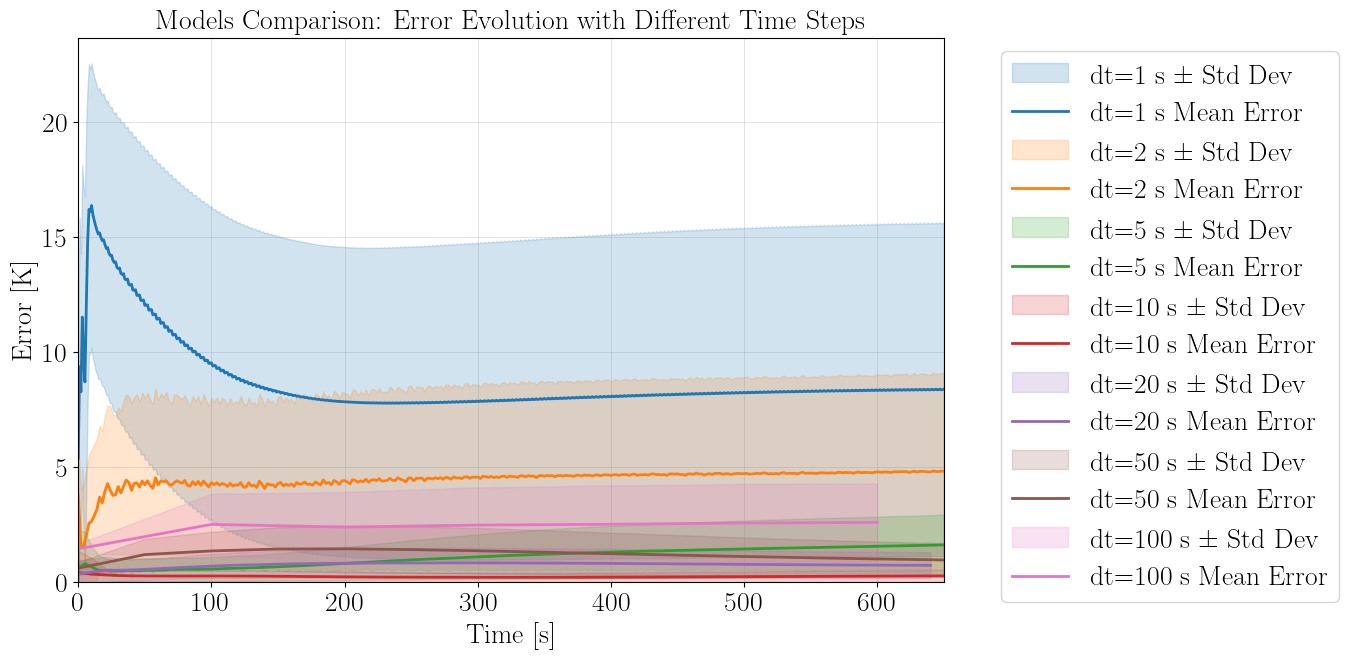


📊 Summary of plotted models:
   - dt=1 s: 651 time steps, dt=1.0000s, range=[0.00, 650.00]s
   - dt=2 s: 326 time steps, dt=2.0000s, range=[0.00, 650.00]s
   - dt=5 s: 131 time steps, dt=5.0000s, range=[0.00, 650.00]s
   - dt=10 s: 66 time steps, dt=10.0000s, range=[0.00, 650.00]s
   - dt=20 s: 33 time steps, dt=20.0000s, range=[0.00, 640.00]s
   - dt=50 s: 14 time steps, dt=50.0000s, range=[0.00, 650.00]s
   - dt=100 s: 7 time steps, dt=100.0000s, range=[0.00, 600.00]s


In [ ]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}'
    )

#### Propagating for shorter periods

In [ ]:
time_propagated = 200 

In [ ]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Iterar sobre cada valor de dt
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt}")
    
    # Calcular sequence_length para este dt específico
    sequence_length = int(time_propagated // dt + 1)
    
    # Preallocar array para este dt específico
    T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))
    
    # Crear nombre dinámico para esta configuración
    nombre_caso = f"T_transient_dt{dt}"
    
    for i in range(n_data):
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]
        
        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_propagated, dt=1,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        T_transient_dt = downsample_solver_output(T_transient, dt)  # Downsample to match sequence length
        
        # Almacenar resultado
        T_true_all[i] = T_transient_dt
    
    # Almacenar resultados para este dt
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': T_true_all,
        'shape': T_true_all.shape
    }

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

# Acceder a los resultados específicos
# Por ejemplo, para dt=0.01:
# T_results_dt1 = resultados_por_dt[f"T_transient_dt{1}"]['T_true_all']
# T_results_dt5 = resultados_por_dt["T_transient_dt5"]['T_true_all']


🔄 Procesando con dt = 1

🔄 Procesando con dt = 2

🔄 Procesando con dt = 5

🔄 Procesando con dt = 10

🔄 Procesando con dt = 20

🔄 Procesando con dt = 50

🔄 Procesando con dt = 100

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 201, 169) (dt=1)
   - T_transient_dt2: (1000, 101, 169) (dt=2)
   - T_transient_dt5: (1000, 41, 169) (dt=5)
   - T_transient_dt10: (1000, 21, 169) (dt=10)
   - T_transient_dt20: (1000, 11, 169) (dt=20)
   - T_transient_dt50: (1000, 5, 169) (dt=50)
   - T_transient_dt100: (1000, 3, 169) (dt=100)


In [ ]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt = {dt}'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_11916\3586809121.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 201
   ⏱️ dt: 1s
   🔗 Sequence length: 201
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [02:28<00:00,  6.72it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 10.205 K
   Overall RMSE: 12.285 K
   Overall STD: 6.714 K
   Initial timestep MAE: 5.401 K
   Final timestep MAE: 7.853 K
   Maximum timestep error: 16.386 K at t=10.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 101
   ⏱️ dt: 2s
   🔗 Sequence length: 101
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [01:14<00:00, 13.41it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 4.115 K
   Overall RMSE: 5.478 K
   Overall STD: 3.608 K
   Initial timestep MAE: 3.794 K
   Final timestep MAE: 4.430 K
   Maximum timestep error: 4.551 K at t=58.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 41
   ⏱️ dt: 5s
   🔗 Sequence length: 41
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:30<00:00, 32.51it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.631 K
   Overall RMSE: 0.892 K
   Overall STD: 0.621 K
   Initial timestep MAE: 0.641 K
   Final timestep MAE: 0.828 K
   Maximum timestep error: 0.828 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 21
   ⏱️ dt: 10s
   🔗 Sequence length: 21
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:16<00:00, 60.13it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.290 K
   Overall RMSE: 0.415 K
   Overall STD: 0.288 K
   Initial timestep MAE: 0.437 K
   Final timestep MAE: 0.247 K
   Maximum timestep error: 0.437 K at t=0.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 20 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 11
   ⏱️ dt: 20s
   🔗 Sequence length: 11
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:09<00:00, 107.90it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.675 K
   Overall RMSE: 0.878 K
   Overall STD: 0.555 K
   Initial timestep MAE: 0.379 K
   Final timestep MAE: 0.837 K
   Maximum timestep error: 0.837 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 5
   ⏱️ dt: 50s
   🔗 Sequence length: 5
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:04<00:00, 203.54it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.225 K
   Overall RMSE: 1.438 K
   Overall STD: 0.750 K
   Initial timestep MAE: 0.622 K
   Final timestep MAE: 1.464 K
   Maximum timestep error: 1.464 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 100 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 3
   ⏱️ dt: 100s
   🔗 Sequence length: 3
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:03<00:00, 300.43it/s]


📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 2.132 K
   Overall RMSE: 2.395 K
   Overall STD: 1.026 K
   Initial timestep MAE: 1.462 K
   Final timestep MAE: 2.410 K
   Maximum timestep error: 2.526 K at t=100.0s
   Time range: [0.0s, 200.0s]


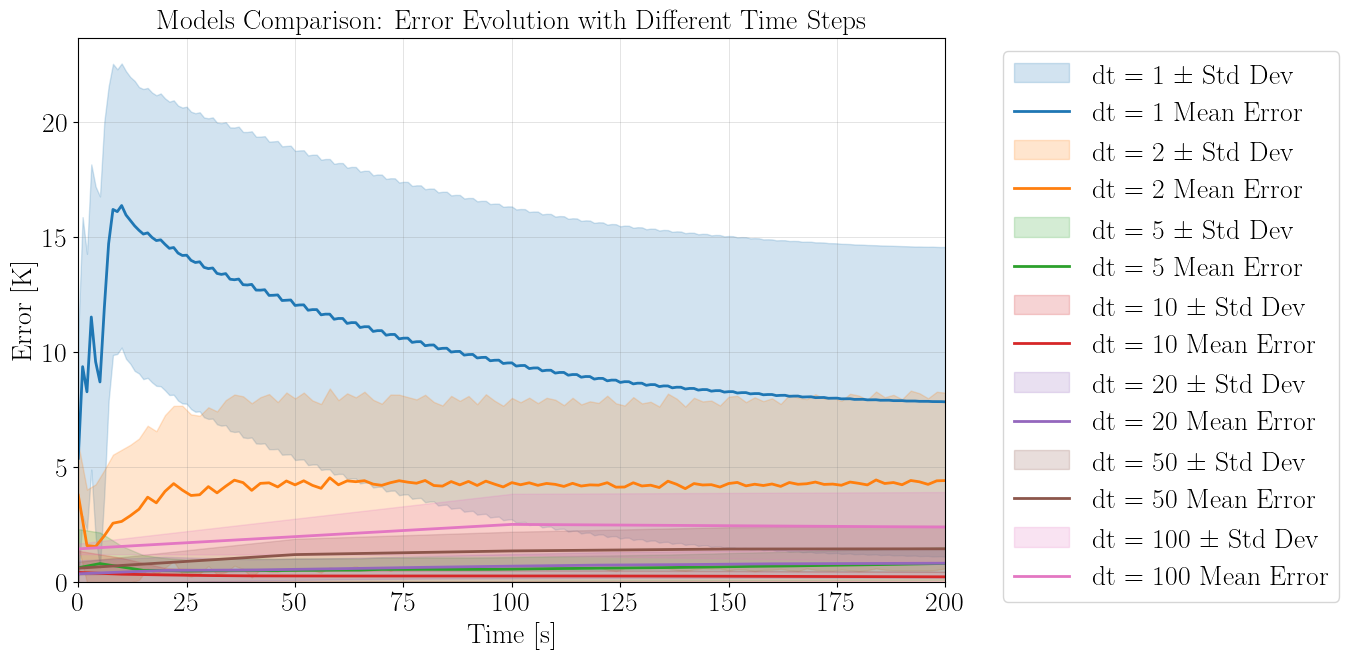


📊 Summary of plotted models:
   - dt = 1: 201 time steps, dt=1.0000s, range=[0.00, 200.00]s
   - dt = 2: 101 time steps, dt=2.0000s, range=[0.00, 200.00]s
   - dt = 5: 41 time steps, dt=5.0000s, range=[0.00, 200.00]s
   - dt = 10: 21 time steps, dt=10.0000s, range=[0.00, 200.00]s
   - dt = 20: 11 time steps, dt=20.0000s, range=[0.00, 200.00]s
   - dt = 50: 5 time steps, dt=50.0000s, range=[0.00, 200.00]s
   - dt = 100: 3 time steps, dt=100.0000s, range=[0.00, 200.00]s


In [ ]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}_prop{time_propagated}'
    )

#### Propagating for longer periods

In [ ]:
time_propagated = 600 

In [ ]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Iterar sobre cada valor de dt
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt}")
    
    # Calcular sequence_length para este dt específico
    sequence_length = int(time_propagated // dt + 1)
    
    # Preallocar array para este dt específico
    T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))
    
    # Crear nombre dinámico para esta configuración
    nombre_caso = f"T_transient_dt{dt}"
    
    for i in range(n_data):
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]
        
        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_propagated, dt=1,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        T_transient_dt = downsample_solver_output(T_transient, dt)  # Downsample to match sequence length
        
        # Almacenar resultado
        T_true_all[i] = T_transient_dt
    
    # Almacenar resultados para este dt
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': T_true_all,
        'shape': T_true_all.shape
    }

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

# Acceder a los resultados específicos
# Por ejemplo, para dt=0.01:
# T_results_dt1 = resultados_por_dt[f"T_transient_dt{1}"]['T_true_all']
# T_results_dt5 = resultados_por_dt["T_transient_dt5"]['T_true_all']


🔄 Procesando con dt = 1

🔄 Procesando con dt = 2

🔄 Procesando con dt = 5

🔄 Procesando con dt = 10

🔄 Procesando con dt = 20

🔄 Procesando con dt = 50

🔄 Procesando con dt = 100

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 601, 169) (dt=1)
   - T_transient_dt2: (1000, 301, 169) (dt=2)
   - T_transient_dt5: (1000, 121, 169) (dt=5)
   - T_transient_dt10: (1000, 61, 169) (dt=10)
   - T_transient_dt20: (1000, 31, 169) (dt=20)
   - T_transient_dt50: (1000, 13, 169) (dt=50)
   - T_transient_dt100: (1000, 7, 169) (dt=100)


In [ ]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt = {dt}'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results
    


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_11916\115891012.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loca


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 601
   ⏱️ dt: 1s
   🔗 Sequence length: 601
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [07:17<00:00,  2.28it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 8.786 K
   Overall RMSE: 11.226 K
   Overall STD: 6.913 K
   Initial timestep MAE: 5.401 K
   Final timestep MAE: 8.347 K
   Maximum timestep error: 16.386 K at t=10.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 301
   ⏱️ dt: 2s
   🔗 Sequence length: 301
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [03:40<00:00,  4.53it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 4.466 K
   Overall RMSE: 5.952 K
   Overall STD: 3.931 K
   Initial timestep MAE: 3.794 K
   Final timestep MAE: 4.814 K
   Maximum timestep error: 4.814 K at t=600.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 121
   ⏱️ dt: 5s
   🔗 Sequence length: 121
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [01:30<00:00, 11.04it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.062 K
   Overall RMSE: 1.419 K
   Overall STD: 0.936 K
   Initial timestep MAE: 0.641 K
   Final timestep MAE: 1.574 K
   Maximum timestep error: 1.574 K at t=600.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 61
   ⏱️ dt: 10s
   🔗 Sequence length: 61
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:46<00:00, 21.71it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.259 K
   Overall RMSE: 0.357 K
   Overall STD: 0.242 K
   Initial timestep MAE: 0.437 K
   Final timestep MAE: 0.276 K
   Maximum timestep error: 0.437 K at t=0.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 20 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 31
   ⏱️ dt: 20s
   🔗 Sequence length: 31
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:24<00:00, 41.40it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.766 K
   Overall RMSE: 0.973 K
   Overall STD: 0.597 K
   Initial timestep MAE: 0.379 K
   Final timestep MAE: 0.755 K
   Maximum timestep error: 0.854 K at t=280.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 13
   ⏱️ dt: 50s
   🔗 Sequence length: 13
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:10<00:00, 94.36it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.225 K
   Overall RMSE: 1.485 K
   Overall STD: 0.836 K
   Initial timestep MAE: 0.622 K
   Final timestep MAE: 1.025 K
   Maximum timestep error: 1.464 K at t=200.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 100 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 7
   ⏱️ dt: 100s
   🔗 Sequence length: 7
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:06<00:00, 163.20it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 2.374 K
   Overall RMSE: 2.773 K
   Overall STD: 1.399 K
   Initial timestep MAE: 1.462 K
   Final timestep MAE: 2.612 K
   Maximum timestep error: 2.612 K at t=600.0s
   Time range: [0.0s, 600.0s]


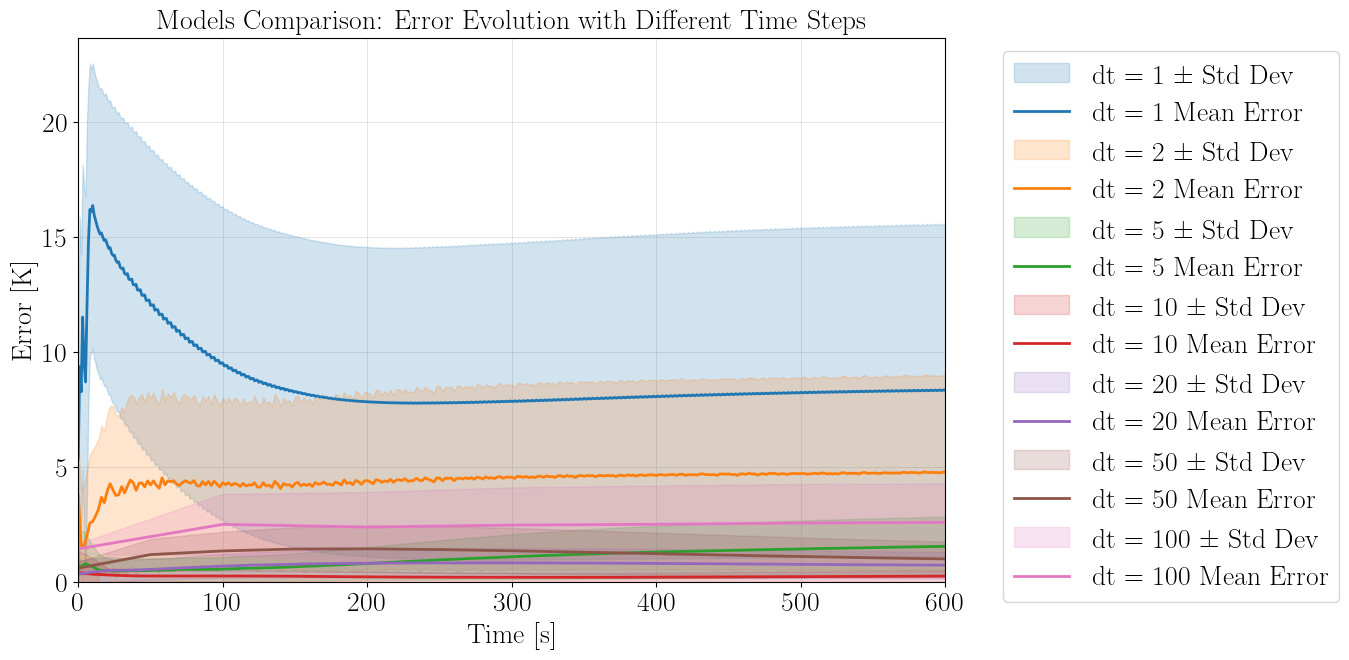


📊 Summary of plotted models:
   - dt = 1: 601 time steps, dt=1.0000s, range=[0.00, 600.00]s
   - dt = 2: 301 time steps, dt=2.0000s, range=[0.00, 600.00]s
   - dt = 5: 121 time steps, dt=5.0000s, range=[0.00, 600.00]s
   - dt = 10: 61 time steps, dt=10.0000s, range=[0.00, 600.00]s
   - dt = 20: 31 time steps, dt=20.0000s, range=[0.00, 600.00]s
   - dt = 50: 13 time steps, dt=50.0000s, range=[0.00, 600.00]s
   - dt = 100: 7 time steps, dt=100.0000s, range=[0.00, 600.00]s


In [ ]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}_prop{time_propagated}'
    )

#### Training time comparison

🚀 STARTING TRAINING vs dt ANALYSIS...
✅ Cargado dt=1s: 106.80 min, 180 épocas
✅ Cargado dt=2s: 43.30 min, 151 épocas
✅ Cargado dt=5s: 15.15 min, 130 épocas
✅ Cargado dt=10s: 15.69 min, 263 épocas
✅ Cargado dt=20s: 6.07 min, 200 épocas
✅ Cargado dt=50s: 2.08 min, 158 épocas
✅ Cargado dt=100s: 1.16 min, 169 épocas
📊 Generando gráficos individuales en figures/comparison_convlstm/...


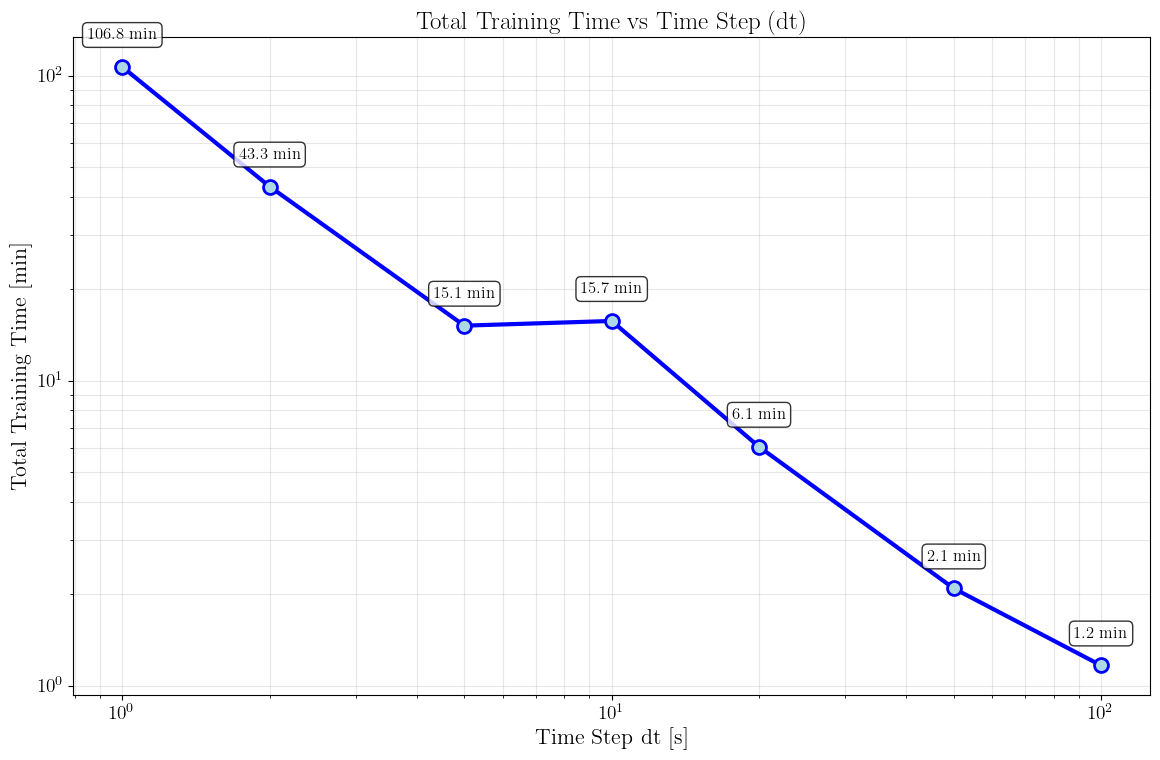

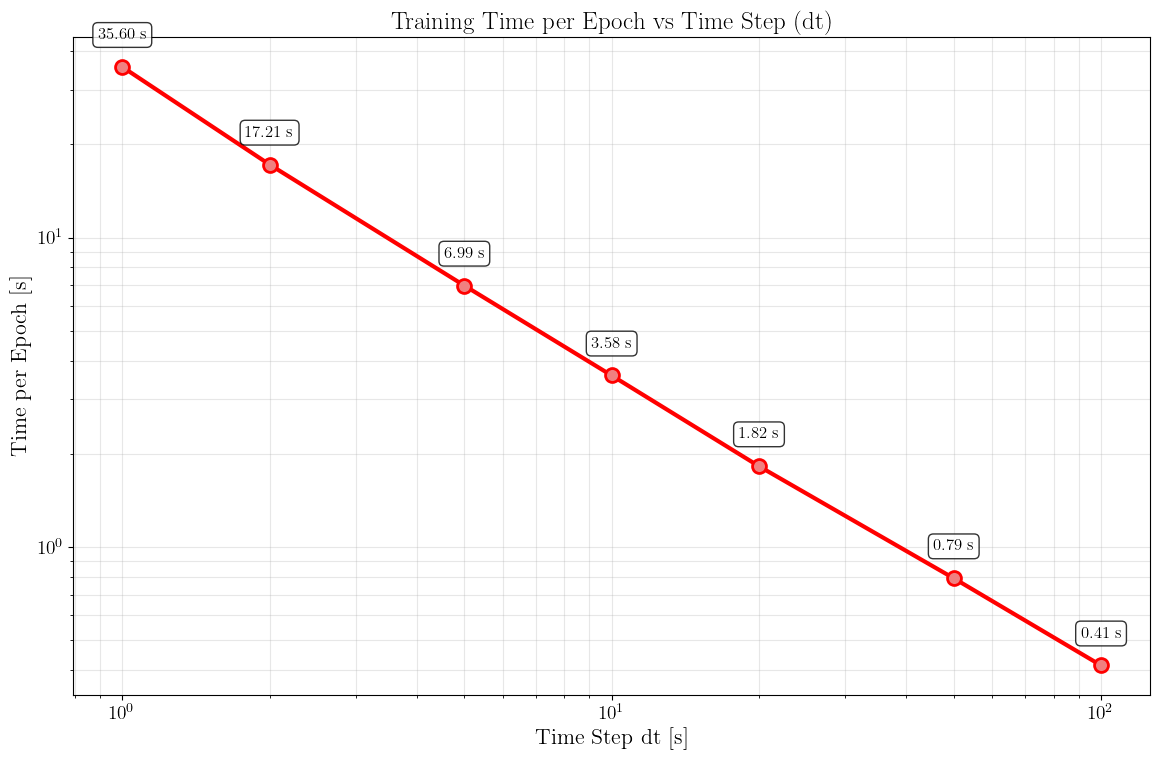

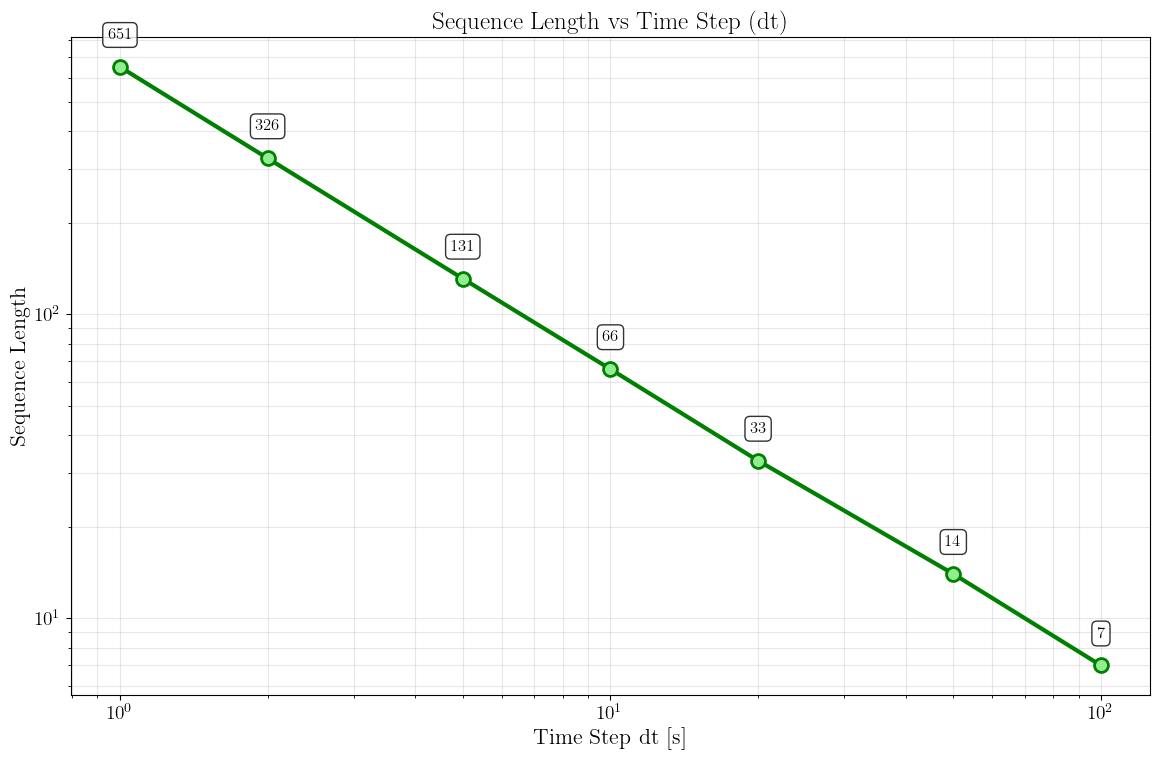

⚠️  MAE data not available in comparison_results - skipping MAE plot
❌ No hay datos válidos para análisis de eficiencia.


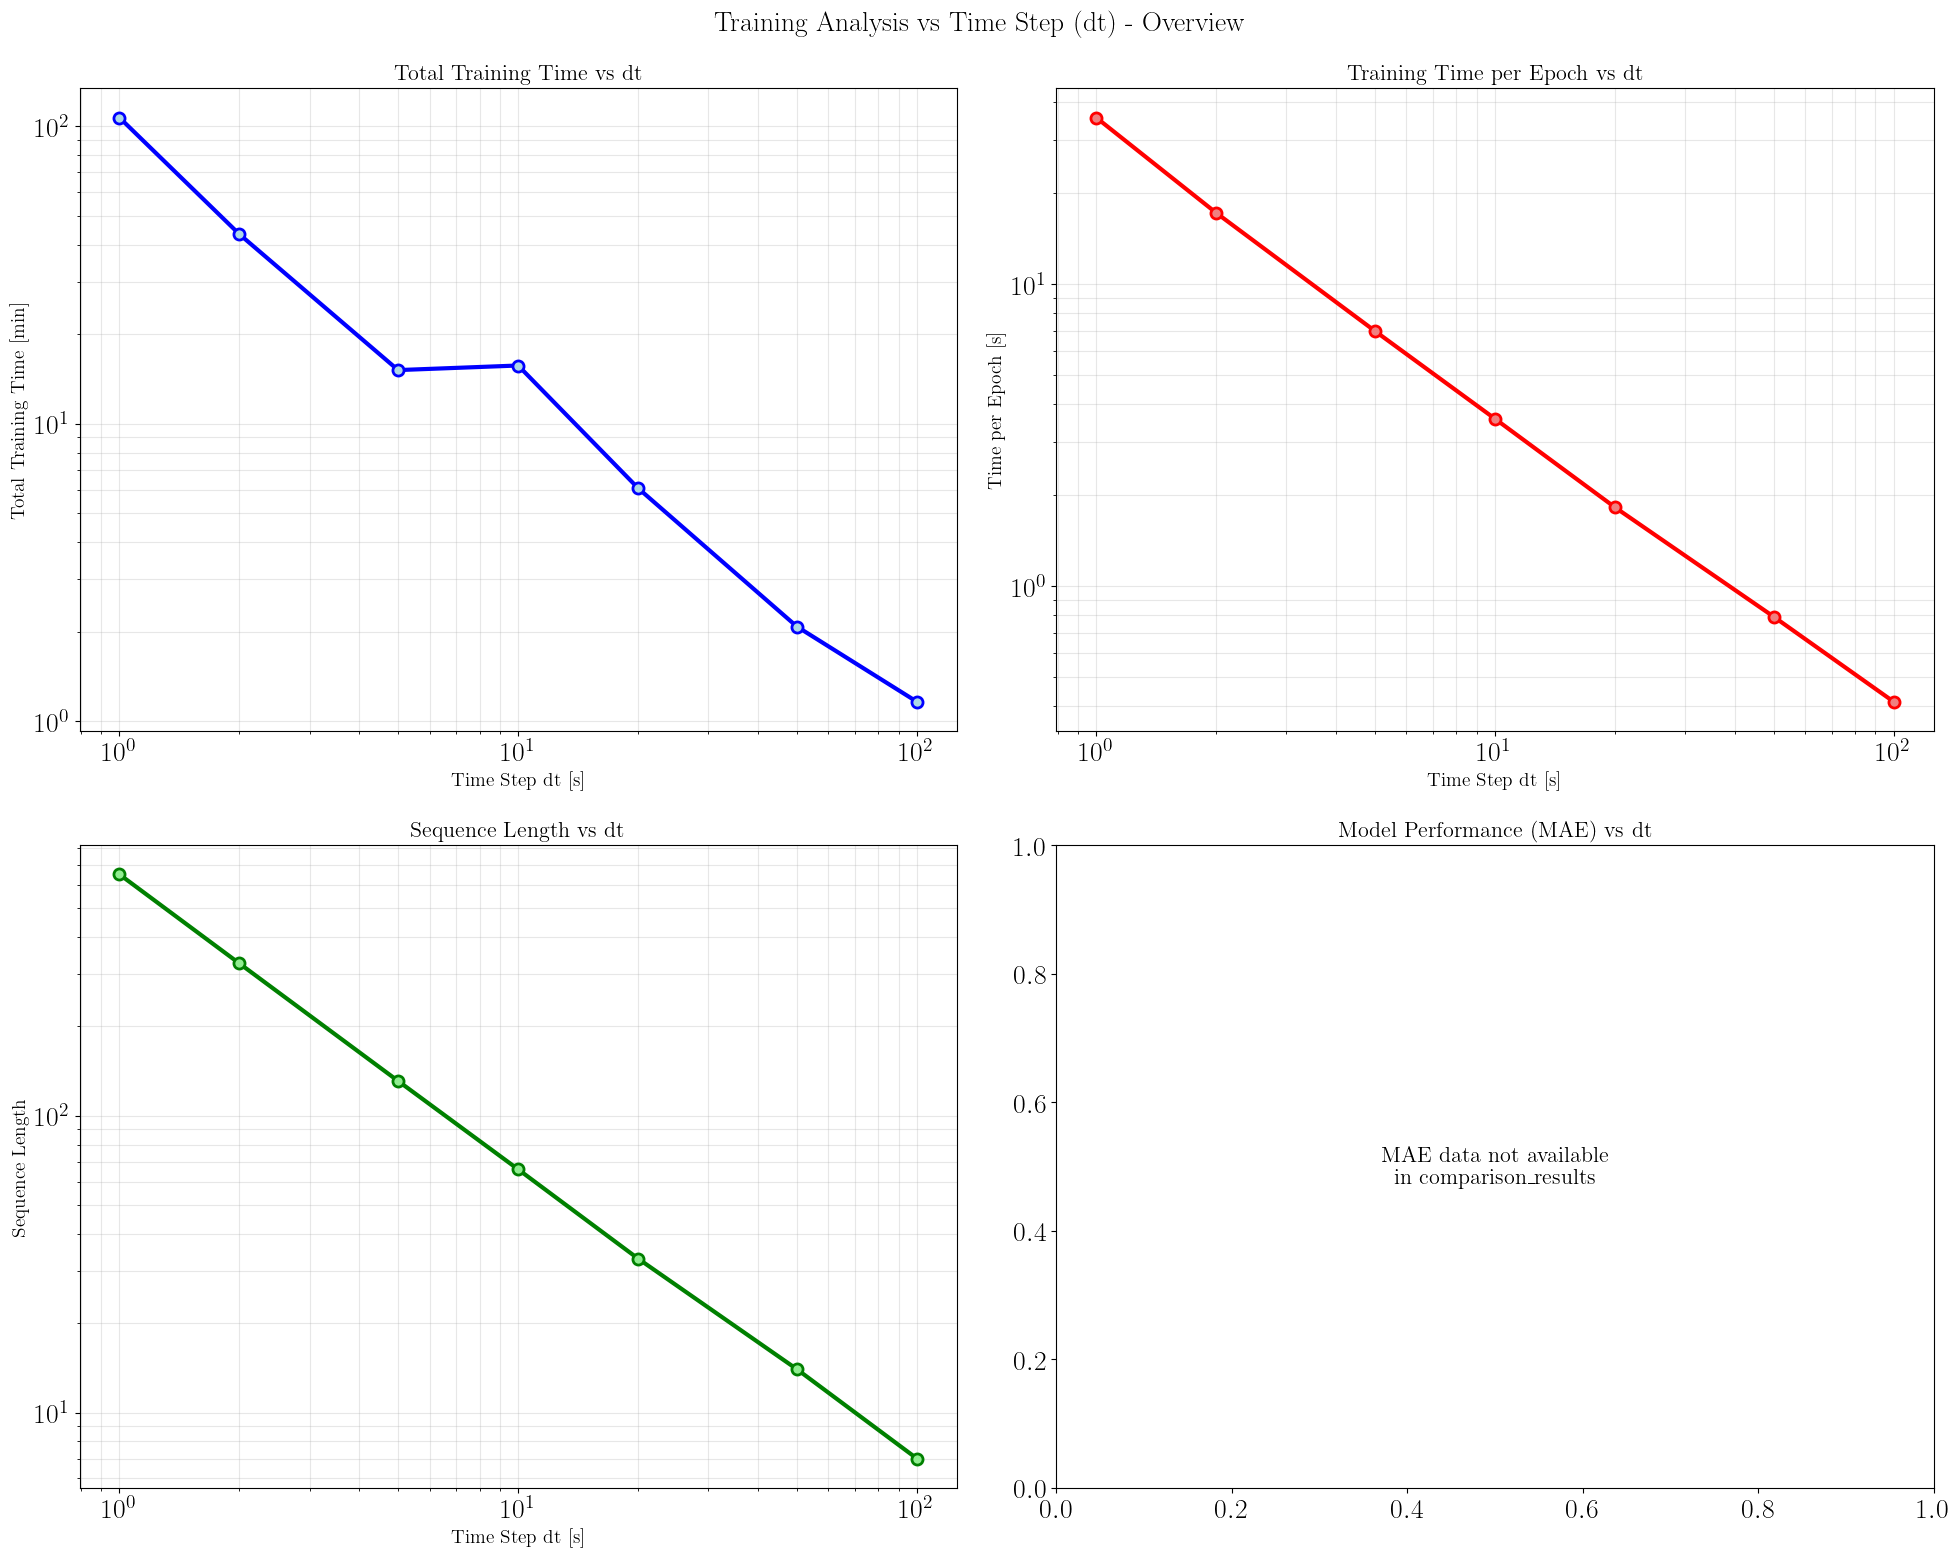


📊 TRAINING ANALYSIS BY TIME STEP (dt):
 dt [s]  Sequence Length  Training Time [min]  Time/Epoch [s]  Epochs Trained  Model Parameters MAE [K] Efficiency (MAE/Time)
      1              651             106.8025         35.6008             180            456769     N/A                   N/A
      2              326              43.3036         17.2067             151            456769     N/A                   N/A
      5              131              15.1458          6.9904             130            456769     N/A                   N/A
     10               66              15.6925          3.5800             263            456769     N/A                   N/A
     20               33               6.0725          1.8218             200            456769     N/A                   N/A
     50               14               2.0838          0.7913             158            456769     N/A                   N/A
    100                7               1.1650          0.4136             169 

In [ ]:
# Ejecutar análisis
training_data, summary_df = analyze_training_vs_dt(
    model_dir, dt_values, comparison_results, 
    time_sim, n_train, batch_size, hidden_dims, kernel_size
)

In [ ]:
# analysis_results = analyze_mae_vs_dt_complete(
#     comparison_results_time650, 
#     save_as_pdf=True
# )

### Time_sim = 200

#### Simulation of a number of cases for comparison

In [ ]:
# n_data = 10          # Número de casos a analizar
time_sim = 200         # Tiempo máximo de simulación [s]
# dt_values = [1, 2, 5, 10, 20, 50, 100]                  # Paso temporal [s]
# Calculate sequence length for each dt value in the list
sequence_lengths = [time_sim // dt + 1 for dt in dt_values]
# T_init = 298.0          # Temperatura inicial [K]

print(f"   📊 Casos a analizar: {n_data}")
print(f"   ⏱️  Tiempo máximo: {time_sim}s")
print(f"   ⏱️  Longitud de secuencia: {sequence_lengths} pasos")

Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_data)

   📊 Casos a analizar: 1000
   ⏱️  Tiempo máximo: 200s
   ⏱️  Longitud de secuencia: [201, 101, 41, 21, 11, 5, 3] pasos


In [ ]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Iterar sobre cada valor de dt
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt}")
    
    # Calcular sequence_length para este dt específico
    sequence_length = int(time_sim // dt + 1)
    
    # Preallocar array para este dt específico
    T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))
    
    # Crear nombre dinámico para esta configuración
    nombre_caso = f"T_transient_dt{dt}"
    
    for i in range(n_data):
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]
        
        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_sim, dt=1,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        T_transient_dt = downsample_solver_output(T_transient, dt)  # Downsample to match sequence length
        
        # Almacenar resultado
        T_true_all[i] = T_transient_dt
    
    # Almacenar resultados para este dt
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': T_true_all,
        'shape': T_true_all.shape
    }

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

# Acceder a los resultados específicos
# Por ejemplo, para dt=0.01:
# T_results_dt1 = resultados_por_dt[f"T_transient_dt{1}"]['T_true_all']
# T_results_dt5 = resultados_por_dt["T_transient_dt5"]['T_true_all']


🔄 Procesando con dt = 1

🔄 Procesando con dt = 2

🔄 Procesando con dt = 5

🔄 Procesando con dt = 10

🔄 Procesando con dt = 20

🔄 Procesando con dt = 50

🔄 Procesando con dt = 100

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 201, 169) (dt=1)
   - T_transient_dt2: (1000, 101, 169) (dt=2)
   - T_transient_dt5: (1000, 41, 169) (dt=5)
   - T_transient_dt10: (1000, 21, 169) (dt=10)
   - T_transient_dt20: (1000, 11, 169) (dt=20)
   - T_transient_dt50: (1000, 5, 169) (dt=50)
   - T_transient_dt100: (1000, 3, 169) (dt=100)


#### Different dt

In [ ]:
# 🧠 Arquitectura ConvLSTM
hidden_dims = [64, 64]                     # Número de filtros por capa
num_layers = len(hidden_dims)
kernel_size = [(3,3)] * num_layers        # Kernel de cada capa (igual para todas)
batch_size = 64                            # Tamaño de batch
n_train = 1000                            # Número de casos de entrenamiento

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.height = height
        self.width = width
        self.num_layers = len(hidden_dims)

        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=self.num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: preds (B, T, 1, H, W), hidden
        """
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)
        preds = dec_flat.view(B, T, 1, H, W)
        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de secuencia (seq_len=1).
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: pred (B, 1, 1, H, W), hidden
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden
    

kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

model_dir = os.path.join(BASE_PATH, 'models', 'ConvLSTM_6ch', 'stateful_O2O')

In [ ]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}
# dt_values = [2, 5, 10, 20, 50, 100]

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt={dt} s'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results
    
comparison_results_time200 = comparison_results.copy()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_11916\1371702142.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 201
   ⏱️ dt: 1s
   🔗 Sequence length: 201
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [02:29<00:00,  6.67it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.616 K
   Overall RMSE: 2.166 K
   Overall STD: 1.433 K
   Initial timestep MAE: 1.152 K
   Final timestep MAE: 1.976 K
   Maximum timestep error: 1.976 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 101
   ⏱️ dt: 2s
   🔗 Sequence length: 101
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [01:15<00:00, 13.27it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.387 K
   Overall RMSE: 2.660 K
   Overall STD: 2.268 K
   Initial timestep MAE: 1.417 K
   Final timestep MAE: 1.645 K
   Maximum timestep error: 1.645 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 41
   ⏱️ dt: 5s
   🔗 Sequence length: 41
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:31<00:00, 31.26it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.128 K
   Overall RMSE: 0.183 K
   Overall STD: 0.128 K
   Initial timestep MAE: 0.119 K
   Final timestep MAE: 0.191 K
   Maximum timestep error: 0.191 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 21
   ⏱️ dt: 10s
   🔗 Sequence length: 21
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:16<00:00, 59.79it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.181 K
   Overall RMSE: 0.239 K
   Overall STD: 0.155 K
   Initial timestep MAE: 0.166 K
   Final timestep MAE: 0.166 K
   Maximum timestep error: 0.243 K at t=10.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 20 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 11
   ⏱️ dt: 20s
   🔗 Sequence length: 11
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:09<00:00, 106.44it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.398 K
   Overall RMSE: 0.508 K
   Overall STD: 0.316 K
   Initial timestep MAE: 0.313 K
   Final timestep MAE: 0.443 K
   Maximum timestep error: 0.443 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 5
   ⏱️ dt: 50s
   🔗 Sequence length: 5
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:04<00:00, 214.95it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.766 K
   Overall RMSE: 0.919 K
   Overall STD: 0.496 K
   Initial timestep MAE: 0.626 K
   Final timestep MAE: 0.845 K
   Maximum timestep error: 0.845 K at t=200.0s
   Time range: [0.0s, 200.0s]

🔄 Procesando con dt = 100 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 3
   ⏱️ dt: 100s
   🔗 Sequence length: 3
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:03<00:00, 302.80it/s]


📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.782 K
   Overall RMSE: 2.008 K
   Overall STD: 0.836 K
   Initial timestep MAE: 1.541 K
   Final timestep MAE: 1.920 K
   Maximum timestep error: 1.920 K at t=200.0s
   Time range: [0.0s, 200.0s]


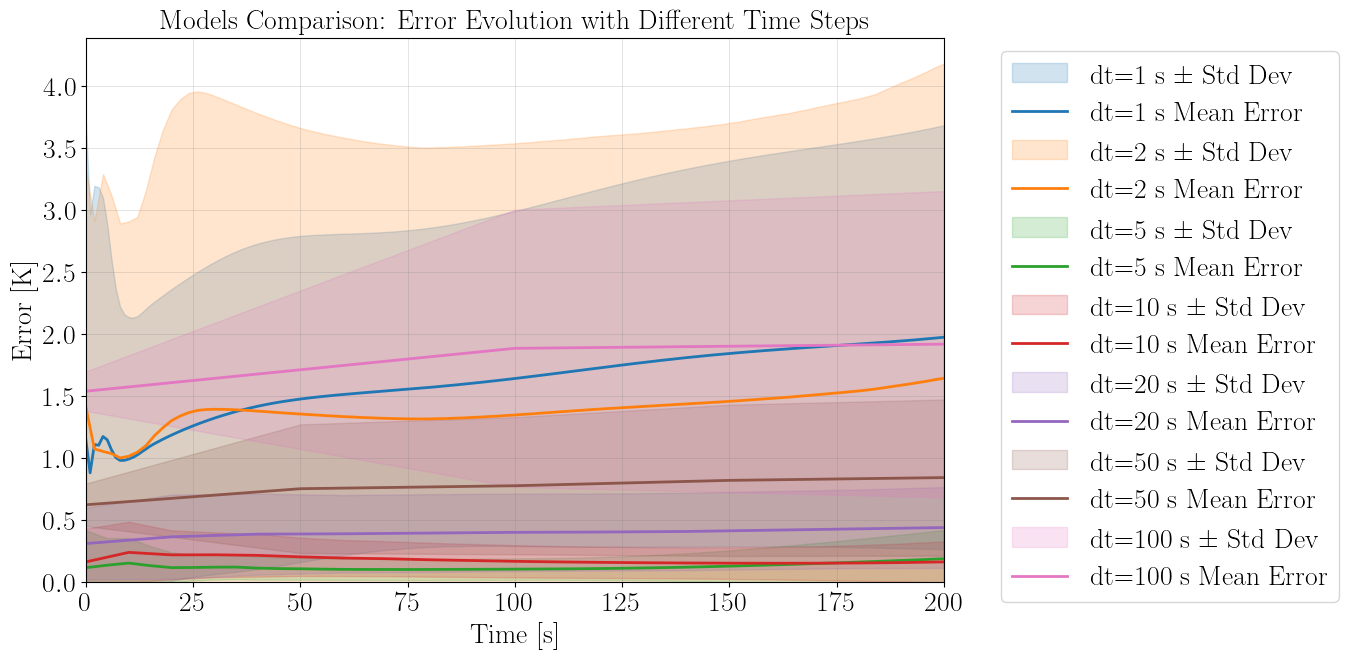


📊 Summary of plotted models:
   - dt=1 s: 201 time steps, dt=1.0000s, range=[0.00, 200.00]s
   - dt=2 s: 101 time steps, dt=2.0000s, range=[0.00, 200.00]s
   - dt=5 s: 41 time steps, dt=5.0000s, range=[0.00, 200.00]s
   - dt=10 s: 21 time steps, dt=10.0000s, range=[0.00, 200.00]s
   - dt=20 s: 11 time steps, dt=20.0000s, range=[0.00, 200.00]s
   - dt=50 s: 5 time steps, dt=50.0000s, range=[0.00, 200.00]s
   - dt=100 s: 3 time steps, dt=100.0000s, range=[0.00, 200.00]s


In [ ]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}'
    )

#### Propagating for longer periods

In [ ]:
time_propagated = 650 

In [ ]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Iterar sobre cada valor de dt
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt}")
    
    # Calcular sequence_length para este dt específico
    sequence_length = int(time_propagated // dt + 1)
    
    # Preallocar array para este dt específico
    T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))
    
    # Crear nombre dinámico para esta configuración
    nombre_caso = f"T_transient_dt{dt}"
    
    for i in range(n_data):
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]
        
        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_propagated, dt=1,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        T_transient_dt = downsample_solver_output(T_transient, dt)  # Downsample to match sequence length
        
        # Almacenar resultado
        T_true_all[i] = T_transient_dt
    
    # Almacenar resultados para este dt
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': T_true_all,
        'shape': T_true_all.shape
    }

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

# Acceder a los resultados específicos
# Por ejemplo, para dt=0.01:
# T_results_dt1 = resultados_por_dt[f"T_transient_dt{1}"]['T_true_all']
# T_results_dt5 = resultados_por_dt["T_transient_dt5"]['T_true_all']


🔄 Procesando con dt = 1

🔄 Procesando con dt = 2

🔄 Procesando con dt = 5

🔄 Procesando con dt = 10

🔄 Procesando con dt = 20

🔄 Procesando con dt = 50

🔄 Procesando con dt = 100

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 651, 169) (dt=1)
   - T_transient_dt2: (1000, 326, 169) (dt=2)
   - T_transient_dt5: (1000, 131, 169) (dt=5)
   - T_transient_dt10: (1000, 66, 169) (dt=10)
   - T_transient_dt20: (1000, 33, 169) (dt=20)
   - T_transient_dt50: (1000, 14, 169) (dt=50)
   - T_transient_dt100: (1000, 7, 169) (dt=100)


In [ ]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt = {dt}'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_11916\3586809121.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 651
   ⏱️ dt: 1s
   🔗 Sequence length: 651
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [07:49<00:00,  2.13it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 4.628 K
   Overall RMSE: 5.437 K
   Overall STD: 2.800 K
   Initial timestep MAE: 1.152 K
   Final timestep MAE: 10.139 K
   Maximum timestep error: 10.139 K at t=650.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 326
   ⏱️ dt: 2s
   🔗 Sequence length: 326
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [03:59<00:00,  4.18it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 3.253 K
   Overall RMSE: 5.184 K
   Overall STD: 4.013 K
   Initial timestep MAE: 1.417 K
   Final timestep MAE: 6.305 K
   Maximum timestep error: 6.305 K at t=650.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 131
   ⏱️ dt: 5s
   🔗 Sequence length: 131
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [01:35<00:00, 10.48it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.322 K
   Overall RMSE: 2.756 K
   Overall STD: 2.413 K
   Initial timestep MAE: 0.119 K
   Final timestep MAE: 4.475 K
   Maximum timestep error: 4.475 K at t=650.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 66
   ⏱️ dt: 10s
   🔗 Sequence length: 66
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:50<00:00, 19.99it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.612 K
   Overall RMSE: 0.834 K
   Overall STD: 0.566 K
   Initial timestep MAE: 0.166 K
   Final timestep MAE: 1.492 K
   Maximum timestep error: 1.492 K at t=650.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 20 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 33
   ⏱️ dt: 20s
   🔗 Sequence length: 33
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:25<00:00, 39.28it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 1.623 K
   Overall RMSE: 2.076 K
   Overall STD: 1.293 K
   Initial timestep MAE: 0.313 K
   Final timestep MAE: 4.672 K
   Maximum timestep error: 4.672 K at t=640.0s
   Time range: [0.0s, 640.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 14
   ⏱️ dt: 50s
   🔗 Sequence length: 14
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:11<00:00, 86.98it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 3.467 K
   Overall RMSE: 5.257 K
   Overall STD: 3.905 K
   Initial timestep MAE: 0.626 K
   Final timestep MAE: 8.152 K
   Maximum timestep error: 9.135 K at t=600.0s
   Time range: [0.0s, 650.0s]

🔄 Procesando con dt = 100 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 7
   ⏱️ dt: 100s
   🔗 Sequence length: 7
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:06<00:00, 157.35it/s]


📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 7.327 K
   Overall RMSE: 9.041 K
   Overall STD: 5.231 K
   Initial timestep MAE: 1.541 K
   Final timestep MAE: 19.219 K
   Maximum timestep error: 19.219 K at t=600.0s
   Time range: [0.0s, 600.0s]


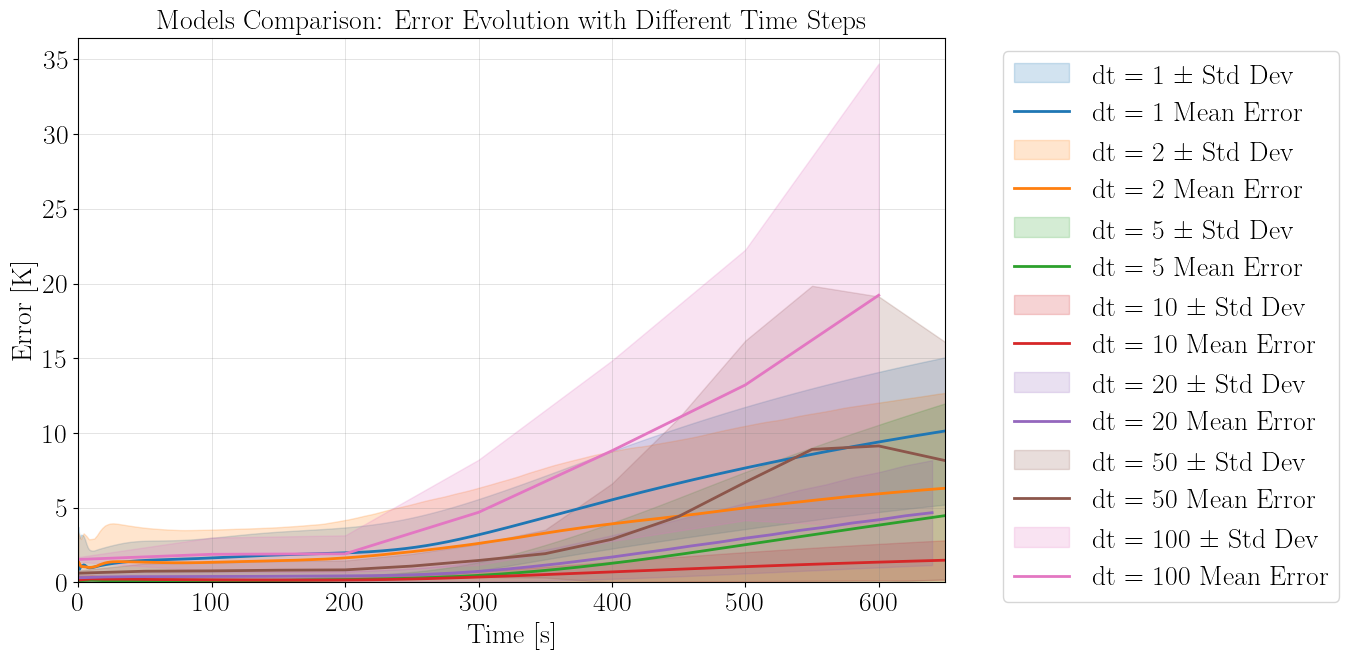


📊 Summary of plotted models:
   - dt = 1: 651 time steps, dt=1.0000s, range=[0.00, 650.00]s
   - dt = 2: 326 time steps, dt=2.0000s, range=[0.00, 650.00]s
   - dt = 5: 131 time steps, dt=5.0000s, range=[0.00, 650.00]s
   - dt = 10: 66 time steps, dt=10.0000s, range=[0.00, 650.00]s
   - dt = 20: 33 time steps, dt=20.0000s, range=[0.00, 640.00]s
   - dt = 50: 14 time steps, dt=50.0000s, range=[0.00, 650.00]s
   - dt = 100: 7 time steps, dt=100.0000s, range=[0.00, 600.00]s


In [ ]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}_prop{time_propagated}'
    )

#### Training time comparison

🚀 STARTING TRAINING vs dt ANALYSIS...
✅ Cargado dt=1s: 23.07 min, 130 épocas
✅ Cargado dt=2s: 13.32 min, 149 épocas
✅ Cargado dt=5s: 12.70 min, 339 épocas
✅ Cargado dt=10s: 9.02 min, 459 épocas
✅ Cargado dt=20s: 4.45 min, 415 épocas
✅ Cargado dt=50s: 1.13 min, 207 épocas
✅ Cargado dt=100s: 0.74 min, 208 épocas
📊 Generando gráficos individuales en figures/comparison_convlstm/...


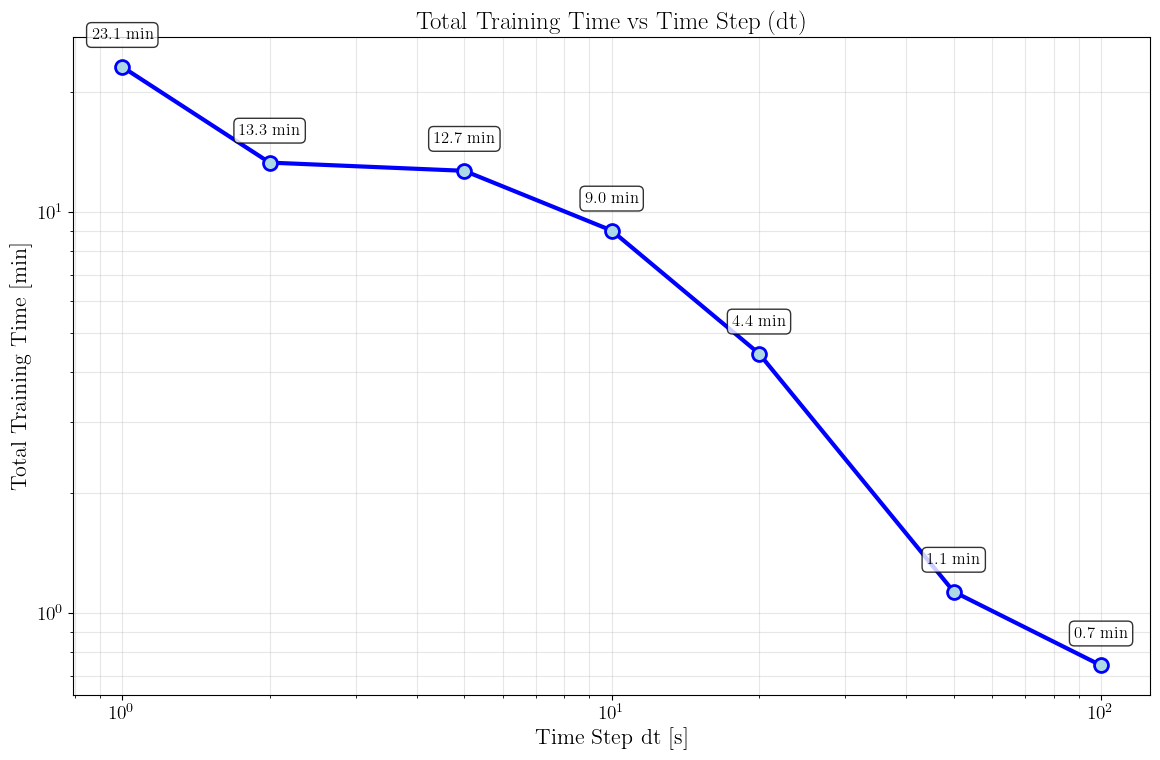

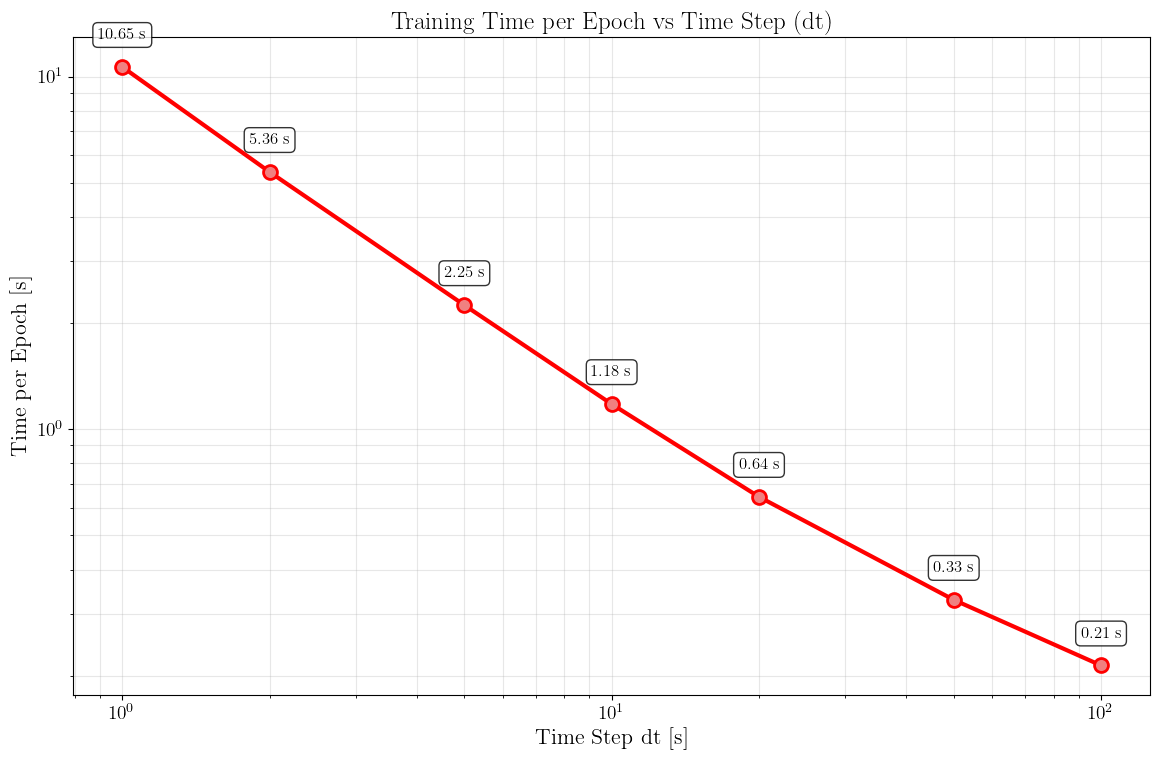

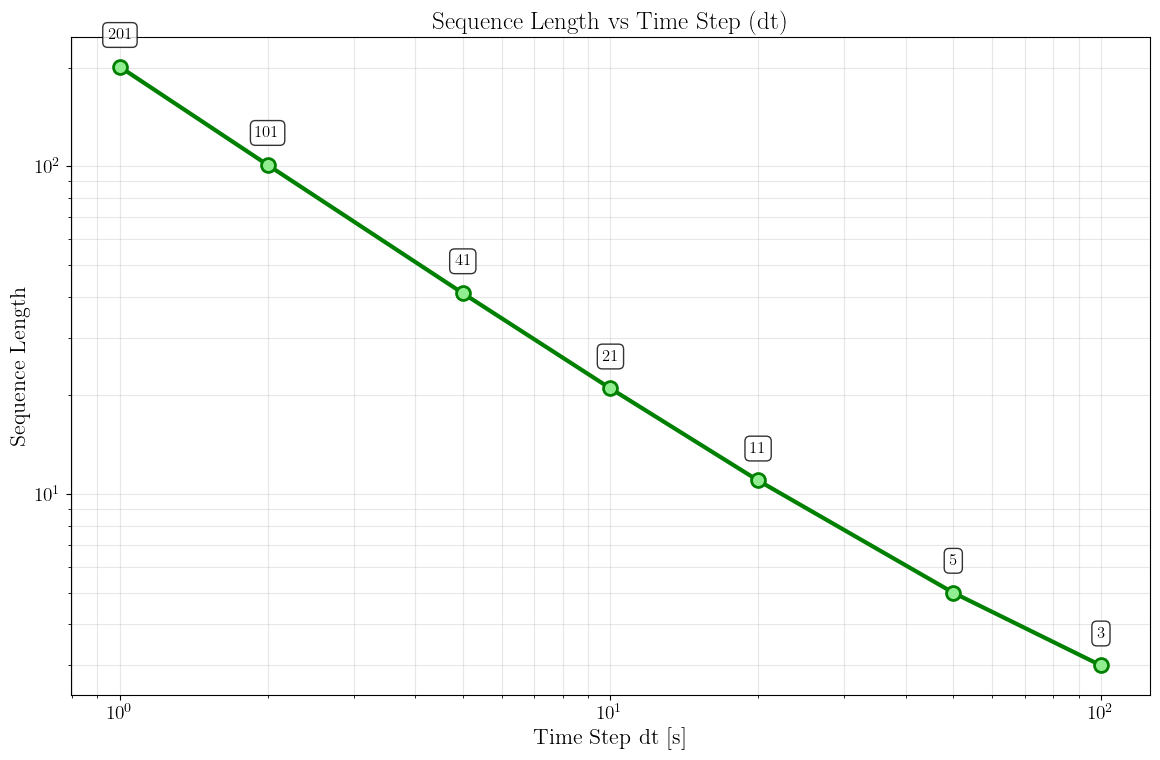

⚠️  MAE data not available in comparison_results - skipping MAE plot
❌ No hay datos válidos para análisis de eficiencia.


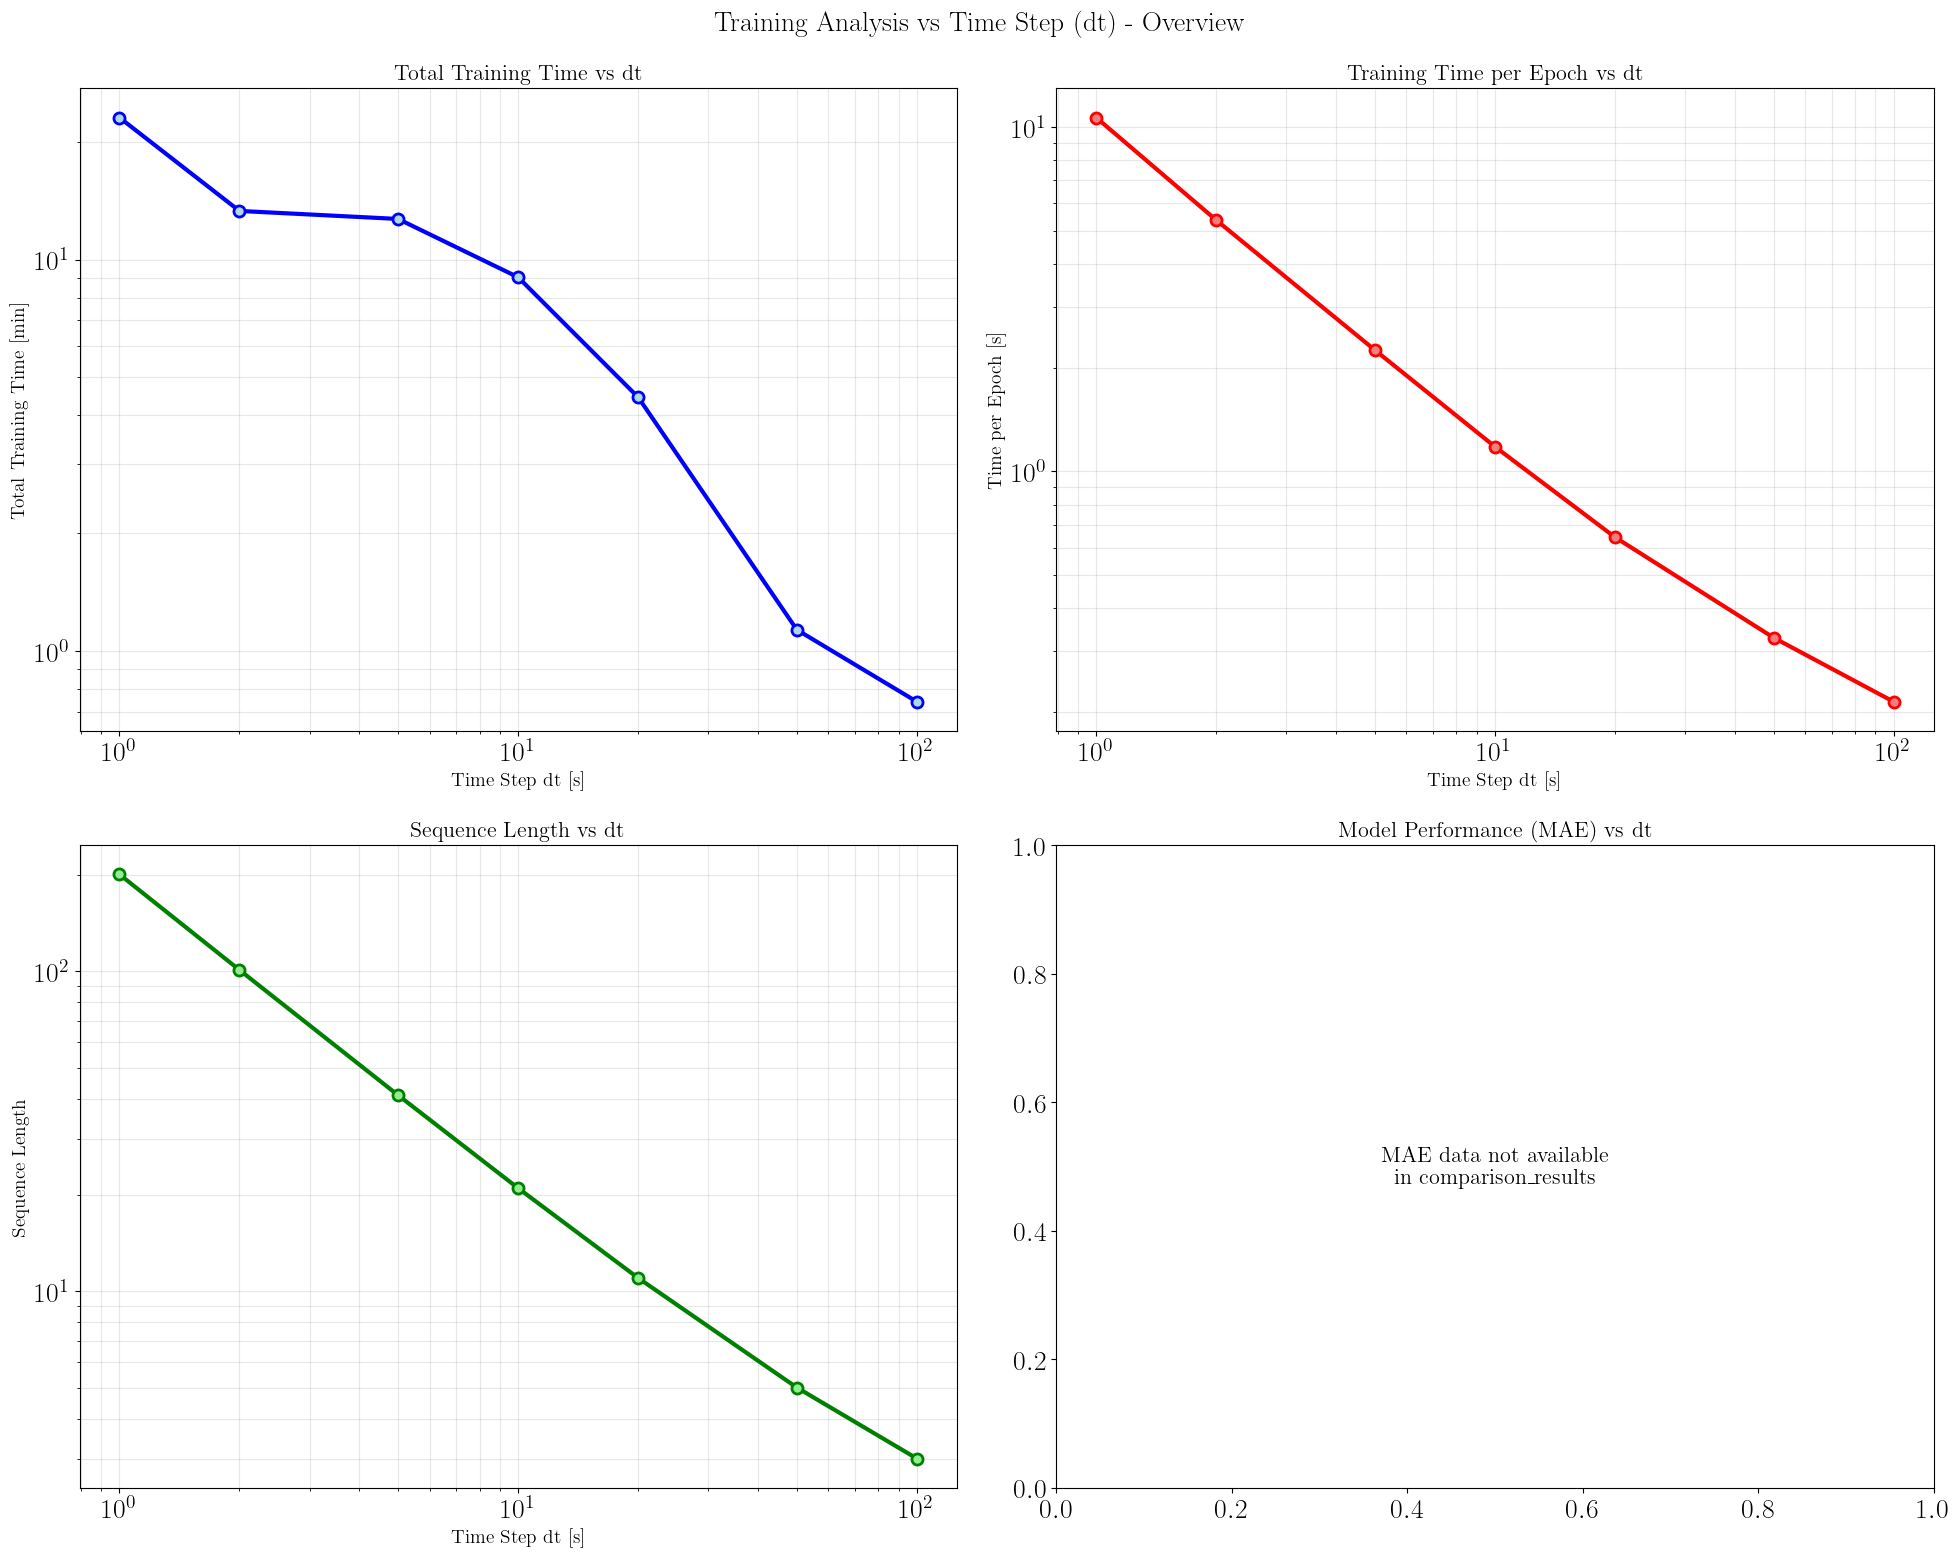


📊 TRAINING ANALYSIS BY TIME STEP (dt):
 dt [s]  Sequence Length  Training Time [min]  Time/Epoch [s]  Epochs Trained  Model Parameters MAE [K] Efficiency (MAE/Time)
      1              201              23.0720         10.6486             130            456769     N/A                   N/A
      2              101              13.3185          5.3632             149            456769     N/A                   N/A
      5               41              12.7042          2.2485             339            456769     N/A                   N/A
     10               21               9.0156          1.1785             459            456769     N/A                   N/A
     20               11               4.4492          0.6433             415            456769     N/A                   N/A
     50                5               1.1330          0.3284             207            456769     N/A                   N/A
    100                3               0.7419          0.2140             208 

In [ ]:
# Ejecutar análisis
training_data, summary_df = analyze_training_vs_dt(
    model_dir, dt_values, comparison_results, 
    time_sim, n_train, batch_size, hidden_dims, kernel_size
)

In [ ]:
# analysis_results = analyze_mae_vs_dt_complete(
#     comparison_results_time200, 
#     save_as_pdf=True
# )

### Time_sim = 50

#### Simulation of a number of cases for comparison

In [ ]:
# n_data = 10          # Número de casos a analizar
time_sim = 50         # Tiempo máximo de simulación [s]
dt_values = [1, 2, 5, 10, 20, 50]                  # Paso temporal [s]
# Calculate sequence length for each dt value in the list
sequence_lengths = [time_sim // dt + 1 for dt in dt_values]
# T_init = 298.0          # Temperatura inicial [K]

print(f"   📊 Casos a analizar: {n_data}")
print(f"   ⏱️  Tiempo máximo: {time_sim}s")
print(f"   ⏱️  Longitud de secuencia: {sequence_lengths} pasos")

Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_data)

   📊 Casos a analizar: 1000
   ⏱️  Tiempo máximo: 50s
   ⏱️  Longitud de secuencia: [51, 26, 11, 6, 3, 2] pasos


In [ ]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Iterar sobre cada valor de dt
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt}")
    
    # Calcular sequence_length para este dt específico
    sequence_length = int(time_sim // dt + 1)
    
    # Preallocar array para este dt específico
    T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))
    
    # Crear nombre dinámico para esta configuración
    nombre_caso = f"T_transient_dt{dt}"
    
    for i in range(n_data):
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]
        
        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_sim, dt=1,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        T_transient_dt = downsample_solver_output(T_transient, dt)  # Downsample to match sequence length
        
        # Almacenar resultado
        T_true_all[i] = T_transient_dt
    
    # Almacenar resultados para este dt
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': T_true_all,
        'shape': T_true_all.shape
    }

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

# Acceder a los resultados específicos
# Por ejemplo, para dt=0.01:
# T_results_dt1 = resultados_por_dt[f"T_transient_dt{1}"]['T_true_all']
# T_results_dt5 = resultados_por_dt["T_transient_dt5"]['T_true_all']


🔄 Procesando con dt = 1

🔄 Procesando con dt = 2

🔄 Procesando con dt = 5

🔄 Procesando con dt = 10

🔄 Procesando con dt = 20

🔄 Procesando con dt = 50

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 51, 169) (dt=1)
   - T_transient_dt2: (1000, 26, 169) (dt=2)
   - T_transient_dt5: (1000, 11, 169) (dt=5)
   - T_transient_dt10: (1000, 6, 169) (dt=10)
   - T_transient_dt20: (1000, 3, 169) (dt=20)
   - T_transient_dt50: (1000, 2, 169) (dt=50)


#### Different dt

In [ ]:
# 🧠 Arquitectura ConvLSTM
hidden_dims = [64, 64]                     # Número de filtros por capa
num_layers = len(hidden_dims)
kernel_size = [(3,3)] * num_layers        # Kernel de cada capa (igual para todas)
batch_size = 64                            # Tamaño de batch
n_train = 1000                            # Número de casos de entrenamiento

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.height = height
        self.width = width
        self.num_layers = len(hidden_dims)

        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=self.num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: preds (B, T, 1, H, W), hidden
        """
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)
        preds = dec_flat.view(B, T, 1, H, W)
        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de secuencia (seq_len=1).
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: pred (B, 1, 1, H, W), hidden
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden
    

kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

model_dir = os.path.join(BASE_PATH, 'models', 'ConvLSTM_6ch', 'stateful_O2O')

In [ ]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}
# dt_values = [2, 5, 10, 20, 50, 100]

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt={dt} s'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results
    
comparison_results_time50 = comparison_results.copy()


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_11916\3020654787.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 51
   ⏱️ dt: 1s
   🔗 Sequence length: 51
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:38<00:00, 25.65it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.065 K
   Overall RMSE: 0.099 K
   Overall STD: 0.074 K
   Initial timestep MAE: 0.092 K
   Final timestep MAE: 0.113 K
   Maximum timestep error: 0.113 K at t=50.0s
   Time range: [0.0s, 50.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 26
   ⏱️ dt: 2s
   🔗 Sequence length: 26
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:20<00:00, 48.15it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.109 K
   Overall RMSE: 0.256 K
   Overall STD: 0.231 K
   Initial timestep MAE: 0.062 K
   Final timestep MAE: 0.158 K
   Maximum timestep error: 0.158 K at t=50.0s
   Time range: [0.0s, 50.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 11
   ⏱️ dt: 5s
   🔗 Sequence length: 11
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:09<00:00, 105.89it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.082 K
   Overall RMSE: 0.126 K
   Overall STD: 0.094 K
   Initial timestep MAE: 0.083 K
   Final timestep MAE: 0.085 K
   Maximum timestep error: 0.088 K at t=5.0s
   Time range: [0.0s, 50.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 6
   ⏱️ dt: 10s
   🔗 Sequence length: 6
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:05<00:00, 177.69it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.182 K
   Overall RMSE: 0.301 K
   Overall STD: 0.236 K
   Initial timestep MAE: 0.157 K
   Final timestep MAE: 0.234 K
   Maximum timestep error: 0.234 K at t=50.0s
   Time range: [0.0s, 50.0s]

🔄 Procesando con dt = 20 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 3
   ⏱️ dt: 20s
   🔗 Sequence length: 3
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:03<00:00, 298.31it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.338 K
   Overall RMSE: 0.438 K
   Overall STD: 0.279 K
   Initial timestep MAE: 0.323 K
   Final timestep MAE: 0.336 K
   Maximum timestep error: 0.355 K at t=20.0s
   Time range: [0.0s, 40.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 2
   ⏱️ dt: 50s
   🔗 Sequence length: 2
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:02<00:00, 402.44it/s]


📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.652 K
   Overall RMSE: 0.761 K
   Overall STD: 0.379 K
   Initial timestep MAE: 0.648 K
   Final timestep MAE: 0.656 K
   Maximum timestep error: 0.656 K at t=50.0s
   Time range: [0.0s, 50.0s]


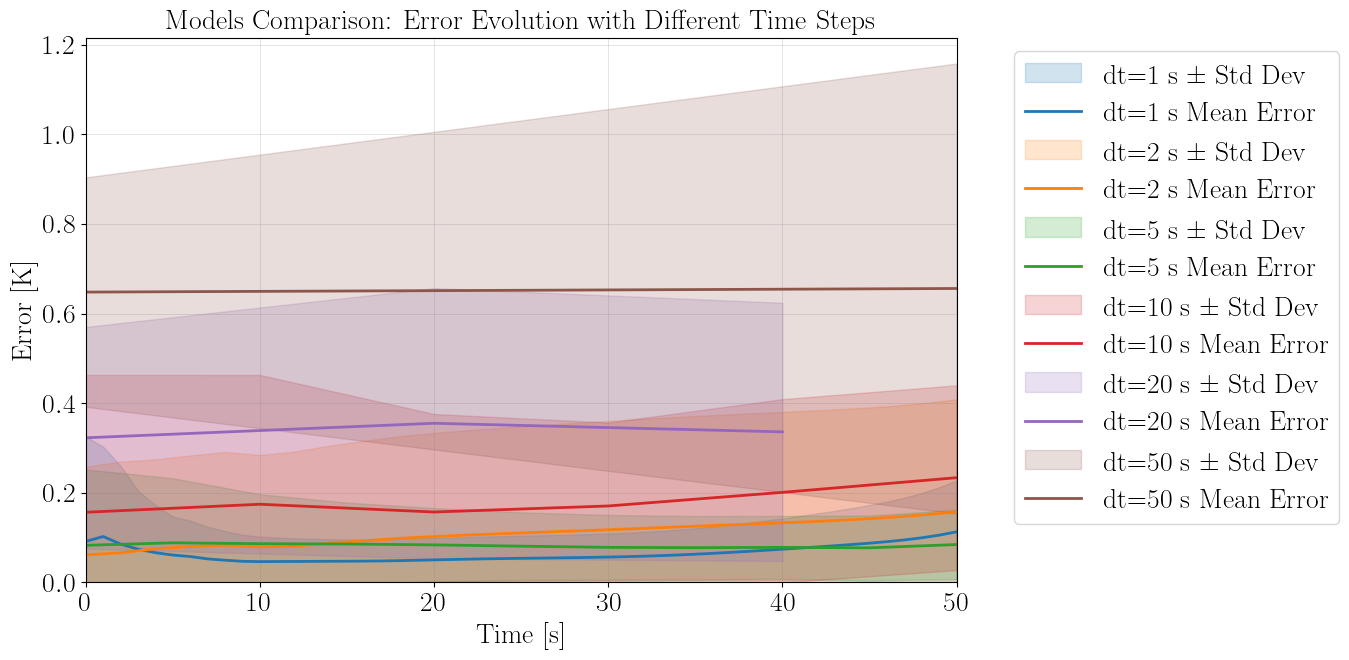


📊 Summary of plotted models:
   - dt=1 s: 51 time steps, dt=1.0000s, range=[0.00, 50.00]s
   - dt=2 s: 26 time steps, dt=2.0000s, range=[0.00, 50.00]s
   - dt=5 s: 11 time steps, dt=5.0000s, range=[0.00, 50.00]s
   - dt=10 s: 6 time steps, dt=10.0000s, range=[0.00, 50.00]s
   - dt=20 s: 3 time steps, dt=20.0000s, range=[0.00, 40.00]s
   - dt=50 s: 2 time steps, dt=50.0000s, range=[0.00, 50.00]s


In [ ]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}'
    )

#### Propagating for longer periods

In [ ]:
time_propagated = 600 

In [ ]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

# Diccionario para almacenar resultados de cada dt
resultados_por_dt = {}

# Iterar sobre cada valor de dt
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt}")
    
    # Calcular sequence_length para este dt específico
    sequence_length = int(time_propagated // dt + 1)
    
    # Preallocar array para este dt específico
    T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))
    
    # Crear nombre dinámico para esta configuración
    nombre_caso = f"T_transient_dt{dt}"
    
    for i in range(n_data):
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]
        
        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_propagated, dt=1,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        T_transient_dt = downsample_solver_output(T_transient, dt)  # Downsample to match sequence length
        
        # Almacenar resultado
        T_true_all[i] = T_transient_dt
    
    # Almacenar resultados para este dt
    resultados_por_dt[nombre_caso] = {
        'dt': dt,
        'sequence_length': sequence_length,
        'T_true_all': T_true_all,
        'shape': T_true_all.shape
    }

print(f"\n🎉 Análisis completado para todos los dt!")
print(f"📋 Configuraciones procesadas:")
for nombre, datos in resultados_por_dt.items():
    print(f"   - {nombre}: {datos['shape']} (dt={datos['dt']})")

# Acceder a los resultados específicos
# Por ejemplo, para dt=0.01:
# T_results_dt1 = resultados_por_dt[f"T_transient_dt{1}"]['T_true_all']
# T_results_dt5 = resultados_por_dt["T_transient_dt5"]['T_true_all']


🔄 Procesando con dt = 1

🔄 Procesando con dt = 2

🔄 Procesando con dt = 5

🔄 Procesando con dt = 10

🔄 Procesando con dt = 20

🔄 Procesando con dt = 50

🎉 Análisis completado para todos los dt!
📋 Configuraciones procesadas:
   - T_transient_dt1: (1000, 601, 169) (dt=1)
   - T_transient_dt2: (1000, 301, 169) (dt=2)
   - T_transient_dt5: (1000, 121, 169) (dt=5)
   - T_transient_dt10: (1000, 61, 169) (dt=10)
   - T_transient_dt20: (1000, 31, 169) (dt=20)
   - T_transient_dt50: (1000, 13, 169) (dt=50)


In [ ]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results = {}

# Ahora puedes usar la función con dt en tu pipeline
for dt in dt_values:
    print(f"\n🔄 Procesando con dt = {dt} s")
    
    # Cargar modelo
    filename = f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
    model_path = os.path.join(model_dir, filename)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    T_true_all = resultados_por_dt[f"T_transient_dt{dt}"]['T_true_all']
    sequence_length = resultados_por_dt[f"T_transient_dt{dt}"]['sequence_length']
    
    # Llamar función con dt específico
    results_dt = f'dt = {dt}'
    results = calculate_convlstm_error_by_timestep(
        model=model,
        dataset=dataset,
        T_transient_all=T_true_all,
        Q_cases=Q_random,
        T_interfaces_cases=T_interfaces_random,
        T_env_cases=T_env_random,
        dt=dt,  # ¡Ahora puedes pasar dt!
        device=device,
        sequence_length=sequence_length,
    )
    
    comparison_results[results_dt] = results


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_11916\3586809121.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc


🔄 Procesando con dt = 1 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 601
   ⏱️ dt: 1s
   🔗 Sequence length: 601
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [07:31<00:00,  2.21it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 7.583 K
   Overall RMSE: 8.753 K
   Overall STD: 4.368 K
   Initial timestep MAE: 0.092 K
   Final timestep MAE: 10.825 K
   Maximum timestep error: 10.830 K at t=577.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 2 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 301
   ⏱️ dt: 2s
   🔗 Sequence length: 301
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 6.094 K
   Overall RMSE: 8.235 K
   Overall STD: 5.533 K
   Initial timestep MAE: 0.062 K
   Final timestep MAE: 11.535 K
   Maximum timestep error: 11.535 K at t=600.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 5 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 121
   ⏱️ dt: 5s
   🔗 Sequence length: 121
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [01:32<00:00, 10.86it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 4.862 K
   Overall RMSE: 6.029 K
   Overall STD: 3.526 K
   Initial timestep MAE: 0.083 K
   Final timestep MAE: 8.867 K
   Maximum timestep error: 8.867 K at t=600.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 10 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 61
   ⏱️ dt: 10s
   🔗 Sequence length: 61
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:46<00:00, 21.32it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 6.844 K
   Overall RMSE: 8.476 K
   Overall STD: 4.982 K
   Initial timestep MAE: 0.157 K
   Final timestep MAE: 9.337 K
   Maximum timestep error: 9.696 K at t=580.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 20 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 31
   ⏱️ dt: 20s
   🔗 Sequence length: 31
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:24<00:00, 41.21it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 18.866 K
   Overall RMSE: 20.831 K
   Overall STD: 8.792 K
   Initial timestep MAE: 0.323 K
   Final timestep MAE: 26.592 K
   Maximum timestep error: 29.898 K at t=240.0s
   Time range: [0.0s, 600.0s]

🔄 Procesando con dt = 50 s
🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 13
   ⏱️ dt: 50s
   🔗 Sequence length: 13
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:10<00:00, 92.16it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 14.281 K
   Overall RMSE: 17.489 K
   Overall STD: 9.864 K
   Initial timestep MAE: 0.648 K
   Final timestep MAE: 19.460 K
   Maximum timestep error: 22.281 K at t=500.0s
   Time range: [0.0s, 600.0s]


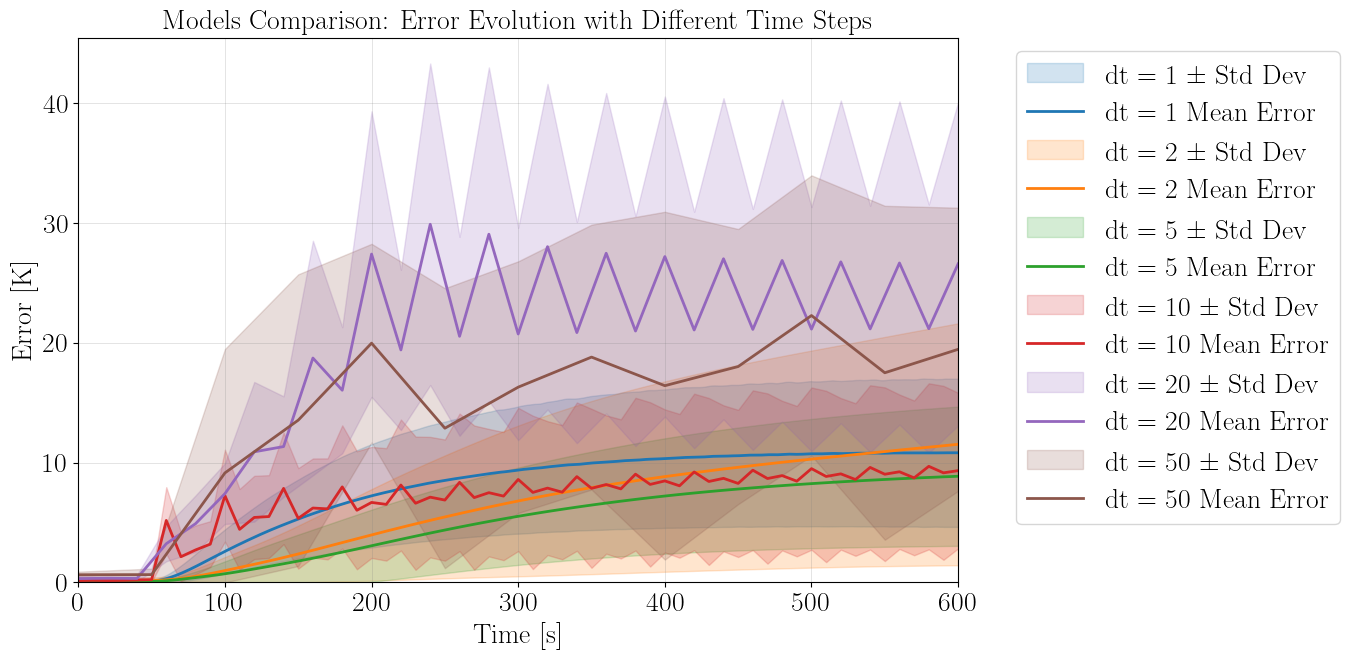


📊 Summary of plotted models:
   - dt = 1: 601 time steps, dt=1.0000s, range=[0.00, 600.00]s
   - dt = 2: 301 time steps, dt=2.0000s, range=[0.00, 600.00]s
   - dt = 5: 121 time steps, dt=5.0000s, range=[0.00, 600.00]s
   - dt = 10: 61 time steps, dt=10.0000s, range=[0.00, 600.00]s
   - dt = 20: 31 time steps, dt=20.0000s, range=[0.00, 600.00]s
   - dt = 50: 13 time steps, dt=50.0000s, range=[0.00, 600.00]s


In [ ]:
if comparison_results:
    plot_models_comparison_with_std_bands(
        comparison_results, 
        save_as_pdf=True, 
        filename=f'comparison_convlstm_different_dt_time{time_sim}_prop{time_propagated}'
    )

#### Training time comparison

🚀 STARTING TRAINING vs dt ANALYSIS...
✅ Cargado dt=1s: 18.87 min, 409 épocas
✅ Cargado dt=2s: 16.37 min, 685 épocas
✅ Cargado dt=5s: 6.89 min, 647 épocas
✅ Cargado dt=10s: 1.20 min, 187 épocas
✅ Cargado dt=20s: 1.14 min, 320 épocas
✅ Cargado dt=50s: 0.92 min, 342 épocas
📊 Generando gráficos individuales en figures/comparison_convlstm/...


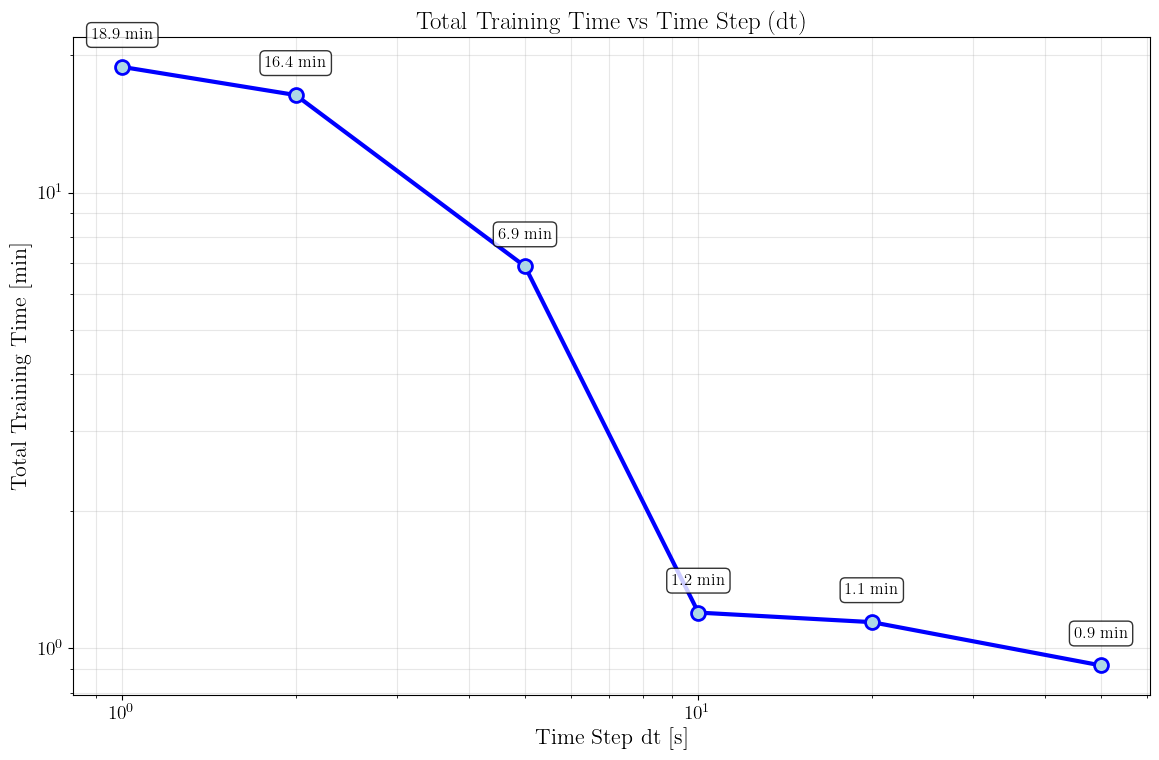

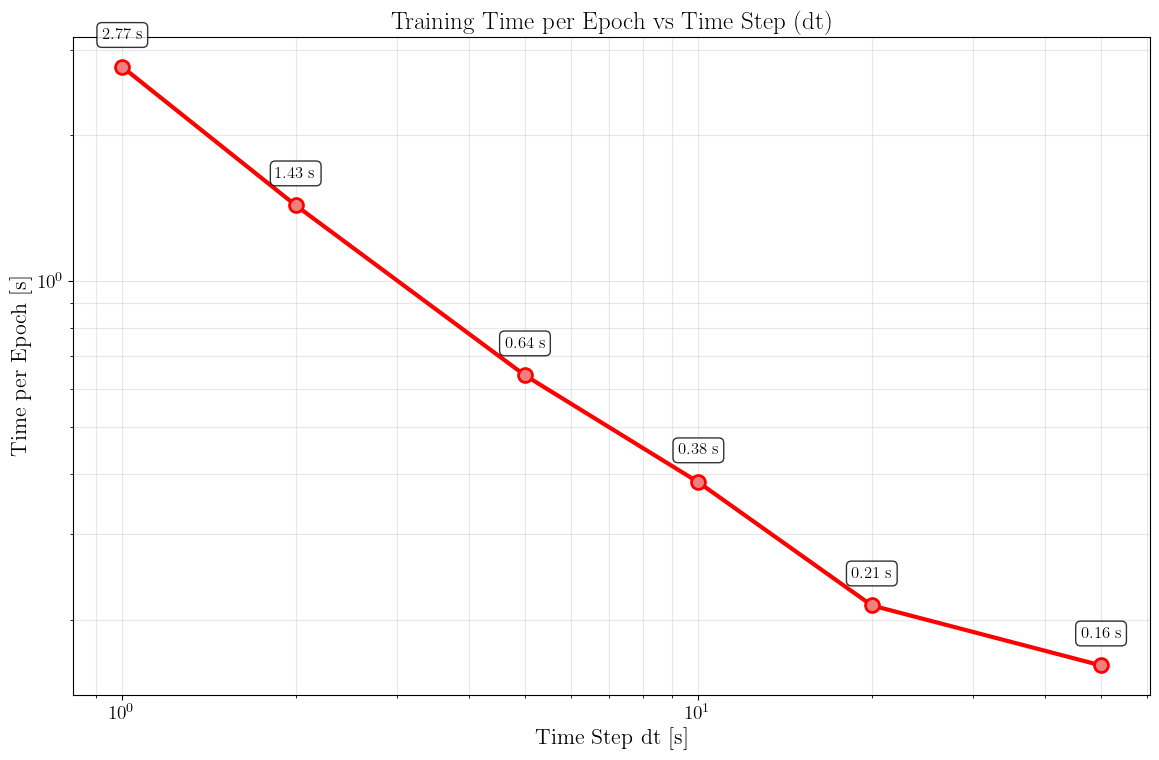

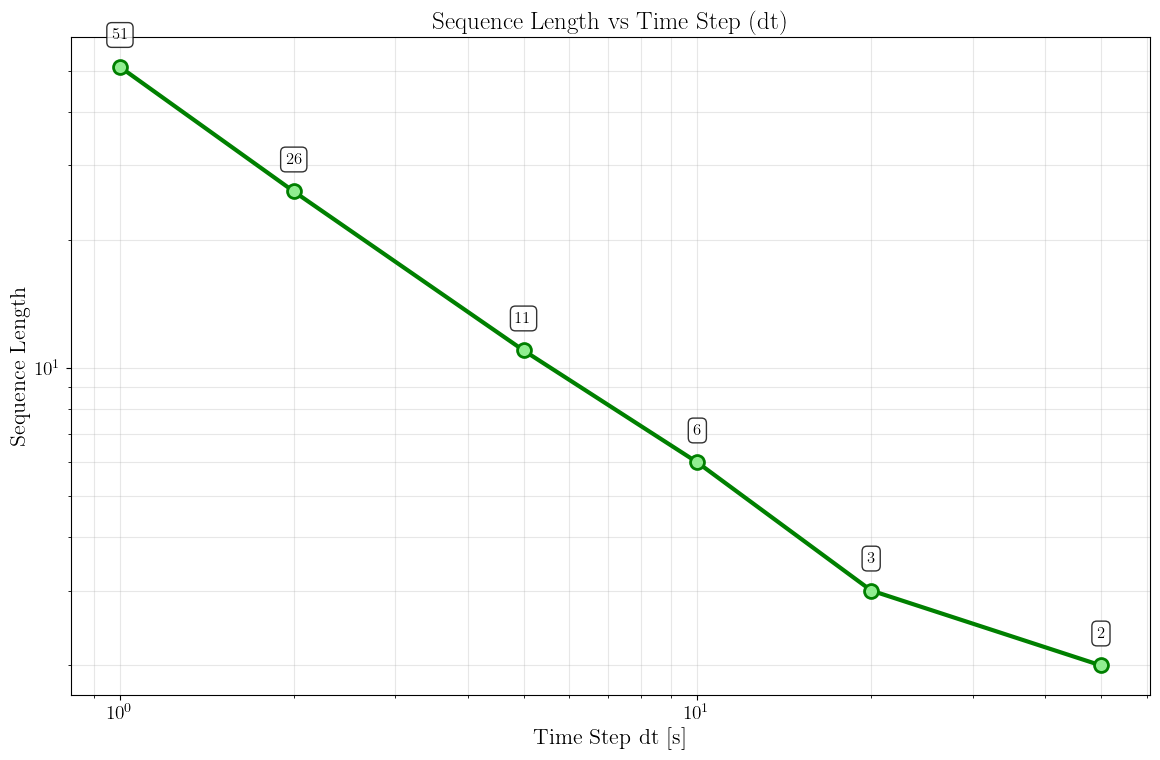

⚠️  MAE data not available in comparison_results - skipping MAE plot
❌ No hay datos válidos para análisis de eficiencia.


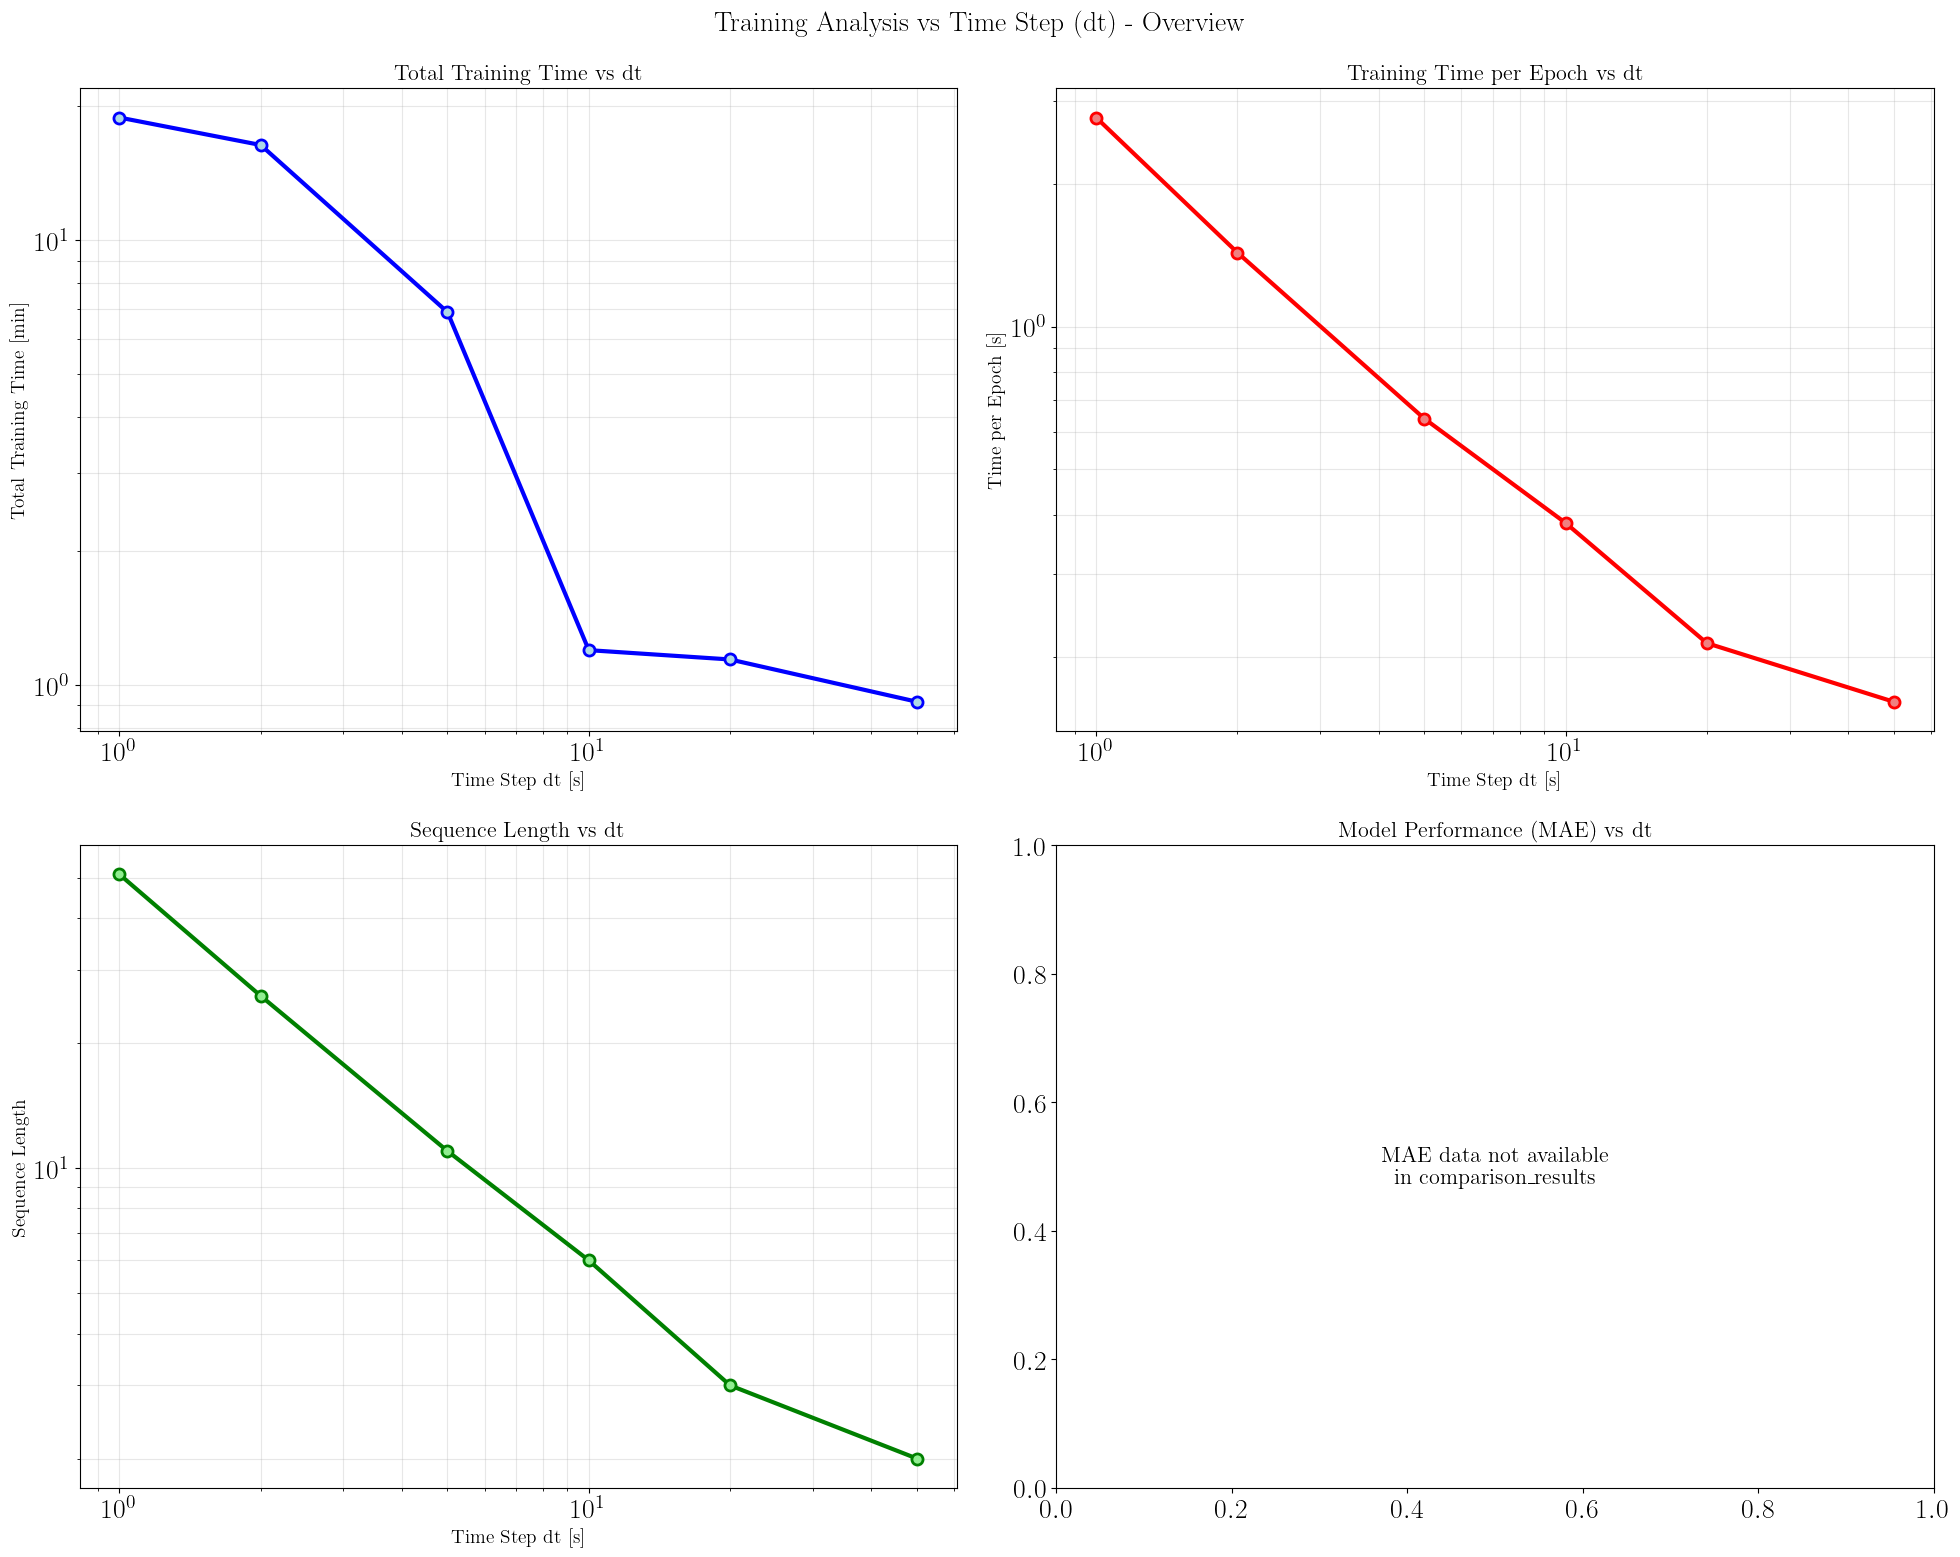


📊 TRAINING ANALYSIS BY TIME STEP (dt):
 dt [s]  Sequence Length  Training Time [min]  Time/Epoch [s]  Epochs Trained  Model Parameters MAE [K] Efficiency (MAE/Time)
      1               51              18.8715          2.7684             409            456769     N/A                   N/A
      2               26              16.3710          1.4340             685            456769     N/A                   N/A
      5               11               6.8924          0.6392             647            456769     N/A                   N/A
     10                6               1.1984          0.3845             187            456769     N/A                   N/A
     20                3               1.1420          0.2141             320            456769     N/A                   N/A
     50                2               0.9176          0.1610             342            456769     N/A                   N/A
✅ Gráficos guardados en figures/comparison_convlstm/:
   • training_total_time

In [ ]:
# Ejecutar análisis
training_data, summary_df = analyze_training_vs_dt(
    model_dir, dt_values, comparison_results, 
    time_sim, n_train, batch_size, hidden_dims, kernel_size
)

In [ ]:
# analysis_results = analyze_mae_vs_dt_complete(
#     comparison_results_time50, 
#     save_as_pdf=True
# )

### Comparison of all training times

✅ Matplotlib configured to use LaTeX rendering (safe mode)
🚀 STARTING MAE vs DT ANALYSIS WITH LATEX...

🔍 Processing configuration: 650 s
✅ 650 s processed:
   Best dt: 10.0s
   Best MAE: 0.2609K
   dt range: 1.0s - 100.0s
   MAE improvement: 97.0%

🔍 Processing configuration: 200 s
✅ 200 s processed:
   Best dt: 5.0s
   Best MAE: 0.1277K
   dt range: 1.0s - 100.0s
   MAE improvement: 92.8%

🔍 Processing configuration: 50 s
✅ 50 s processed:
   Best dt: 1.0s
   Best MAE: 0.0651K
   dt range: 1.0s - 50.0s
   MAE improvement: 90.0%

📊 Generando gráficos...
📄 Saved (no title/textbox): figures/comparison_convlstm/combined_mae_vs_dt.pdf


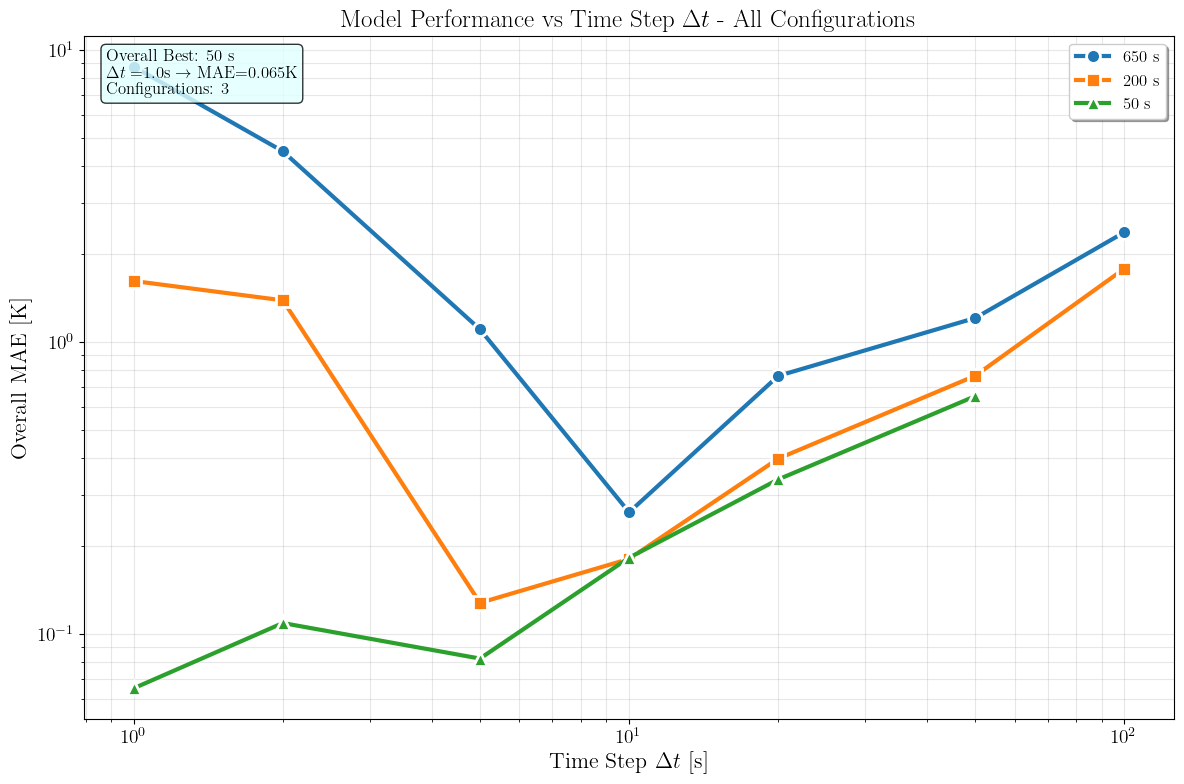

📄 Saved (no title): figures/comparison_convlstm/combined_mae_vs_sequence_length.pdf


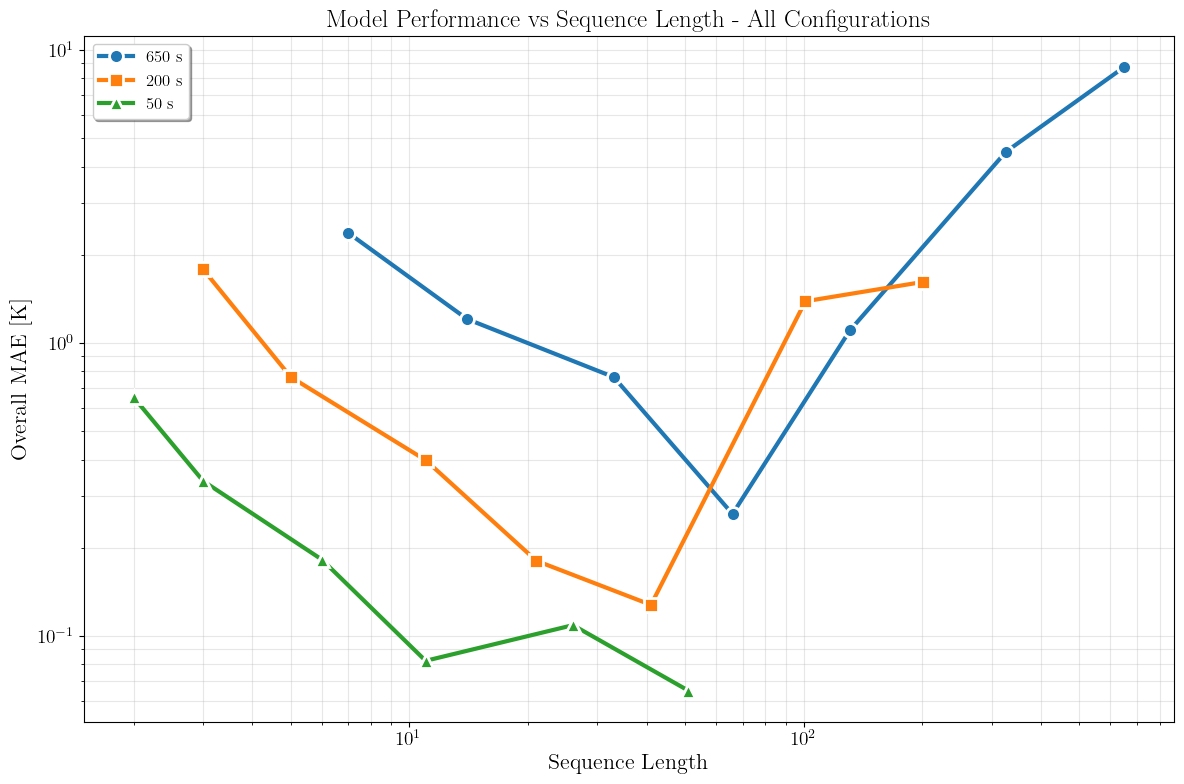

📄 Saved (no title/textbox): figures/comparison_convlstm/combined_mae_vs_sequence_scatter.pdf


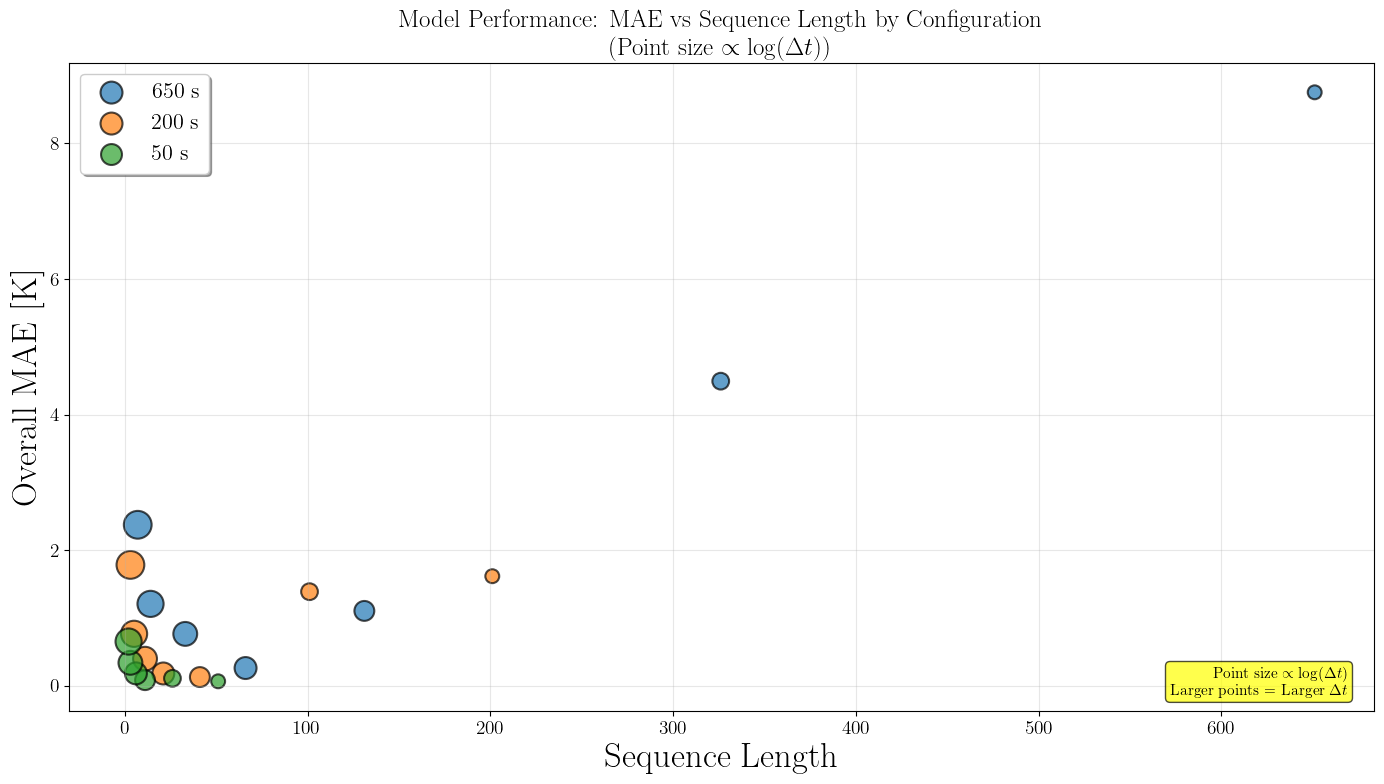


COMPARATIVE SUMMARY - ALL CONFIGURATIONS:
Configuration                  Best dt [s]  Best MAE [K]    dt Range        Improvement [%]
----------------------------------------------------------------------------------------------------
650 s                          10.0         0.2609          1.0-100.0       97.0           
200 s                          5.0          0.1277          1.0-100.0       92.8           
50 s                           1.0          0.0651          1.0-50.0        90.0           
----------------------------------------------------------------------------------------------------

HIGHLIGHTS:
   Best Overall: 50 s (MAE: 0.0651K, dt: 1.0s)
   Worst Overall: 650 s (MAE: 0.2609K)
   Most Improved: 650 s (97.0% improvement)

✅ Análisis completado!
📁 Archivos guardados en figures/comparison_convlstm/ (sin títulos ni recuadros)

🎯 KEY INSIGHTS - ALL CONFIGURATIONS:
   Overall Best: 50 s (MAE: 0.0651K)
   Performance Range: 0.0651K - 0.2609K
   Total Configurations: 

In [ ]:
# Organizar todos tus resultados
all_comparison_results = {
    '650 s': comparison_results_time650,
    '200 s': comparison_results_time200,
    '50 s': comparison_results_time50,
    # Agregar más configuraciones...
}

# Ejecutar análisis con las modificaciones (puntos más diferenciados + PDFs sin título/recuadros)
analysis_results = analyze_mae_vs_dt_complete_all_configs_latex_fixed(
    all_comparison_results, 
    save_as_pdf=True
)

## Comparison for different weights of physics-loss terms

### Simulation of different cases

In [ ]:
n_data = 1000        # Número de casos a analizar
time_sim = 650         # Tiempo máximo de simulación [s]
dt = 10                 # Paso temporal [s]
# Calculate sequence length for each dt value in the list
sequence_length = time_sim // dt + 1 
T_init = 298.0          # Temperatura inicial [K]

print(f"   📊 Casos a analizar: {n_data}")
print(f"   ⏱️  Tiempo máximo: {time_sim}s")
print(f"   ⏱️  Longitud de secuencia: {sequence_length} pasos")

Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_data)

   📊 Casos a analizar: 10
   ⏱️  Tiempo máximo: 650s
   ⏱️  Longitud de secuencia: 66 pasos


In [37]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

T_true_all = np.zeros((n_data, sequence_length, spatial_nodes))

for i in range(n_data):
    if i % 100 == 0:  # Progress indicator
        print(f"   📊 Procesando caso {i}/{n_data}...")
        
    # Condiciones para este caso
    Q = Q_random[i]
    T_int = T_interfaces_random[i]
    T_env = T_env_random[i]
    
    # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
    T_transient, _, _, _ = PCB_case_2(
        solver='transient', display=False, time=time_sim, dt=1,
        T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
    )
    
    T_transient_dt = downsample_solver_output(T_transient, dt)
    
    # Almacenar resultado
    T_true_all[i] = T_transient_dt

print(f"🎉 Análisis completado!")
print(f"📦 Array de temperaturas: {T_true_all.shape}")
print(f"   - {n_data} casos")
print(f"   - {sequence_length} pasos temporales")
print(f"   - {spatial_nodes} nodos espaciales")

   📊 Procesando caso 0/10...
🎉 Análisis completado!
📦 Array de temperaturas: (10, 66, 169)
   - 10 casos
   - 66 pasos temporales
   - 169 nodos espaciales


### n_train = 200

In [ ]:
n_train = 200

In [32]:
mse_weights = [1.0, 0.0]
phy_weights = [0.0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e2, 1e3]
bnd_weights = [0.0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e2, 1e3]

In [ ]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results_phy = {}
total_combinations = len(mse_weights) * len(phy_weights) * len(bnd_weights)
case_counter = 0

# Iterar sobre combinaciones de pesos de física
for mse_w in mse_weights:
    for phy_w in phy_weights:
        for bnd_w in bnd_weights:
            case_counter += 1
            print(f"\n🔄 [{case_counter}/{total_combinations}] Procesando MSE={mse_w}, PHY={phy_w}, BND={bnd_w}")
            
            # Construir nombre del archivo del modelo
            filename = (f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_"
                       f"h{layer_string}_k{kernel_string}_mse{mse_w}_phy{phy_w}_bnd{bnd_w}.pth")
            model_path = os.path.join(model_dir, filename)
            
            # Verificar si el modelo existe
            if not os.path.exists(model_path):
                print(f"⚠️ [{case_counter}/{total_combinations}] Modelo no encontrado: {filename}")
                continue
            
            try:
                # Cargar modelo
                model.load_state_dict(torch.load(model_path, map_location=device))
                model.eval()
                
                # Llamar función de evaluación
                results_name = f'MSE={mse_w}, PHY={phy_w}, BND={bnd_w}'
                results = calculate_convlstm_error_by_timestep(
                    model=model,
                    dataset=dataset_phy,
                    T_transient_all=T_true_all,
                    Q_cases=Q_random,
                    T_interfaces_cases=T_interfaces_random,
                    T_env_cases=T_env_random,
                    dt=dt,
                    device=device,
                    sequence_length=sequence_length,
                    display=False
                )
                
                comparison_results_phy[results_name] = results
                print(f"✅ Evaluado: {results_name}")
                
            except Exception as e:
                print(f"❌ Error evaluando {filename}: {e}")
                continue

print(f"\n🎉 Evaluación completada para {len(comparison_results_phy)}/{total_combinations} modelos con física")


🔄 [1/242] Procesando MSE=1.0, PHY=0.0, BND=0.0


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_6200\4293954076.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loca

✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.0

🔄 [2/242] Procesando MSE=1.0, PHY=0.0, BND=1e-07
⚠️ [2/242] Modelo no encontrado: PCB_ConvLSTM_6ch_nt200_650s_dt10_bs64_h64-64_k3x3_mse1.0_phy0.0_bnd1e-07.pth

🔄 [3/242] Procesando MSE=1.0, PHY=0.0, BND=1e-06
⚠️ [3/242] Modelo no encontrado: PCB_ConvLSTM_6ch_nt200_650s_dt10_bs64_h64-64_k3x3_mse1.0_phy0.0_bnd1e-06.pth

🔄 [4/242] Procesando MSE=1.0, PHY=0.0, BND=1e-05
✅ Evaluado: MSE=1.0, PHY=0.0, BND=1e-05

🔄 [5/242] Procesando MSE=1.0, PHY=0.0, BND=0.0001
✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.0001

🔄 [6/242] Procesando MSE=1.0, PHY=0.0, BND=0.001
✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.001

🔄 [7/242] Procesando MSE=1.0, PHY=0.0, BND=0.01
✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.01

🔄 [8/242] Procesando MSE=1.0, PHY=0.0, BND=0.1
✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.1

🔄 [9/242] Procesando MSE=1.0, PHY=0.0, BND=1.0
✅ Evaluado: MSE=1.0, PHY=0.0, BND=1.0

🔄 [10/242] Procesando MSE=1.0, PHY=0.0, BND=100.0
✅ Evaluado: MSE=1.0, PHY=0.0, BND=100.0

🔄 [11/242] Procesa

📊 PLOTTING SELECTION:
   Total available models: 127
   Models to plot: 11 (Top 10 + Baseline)
   Baseline included: Yes


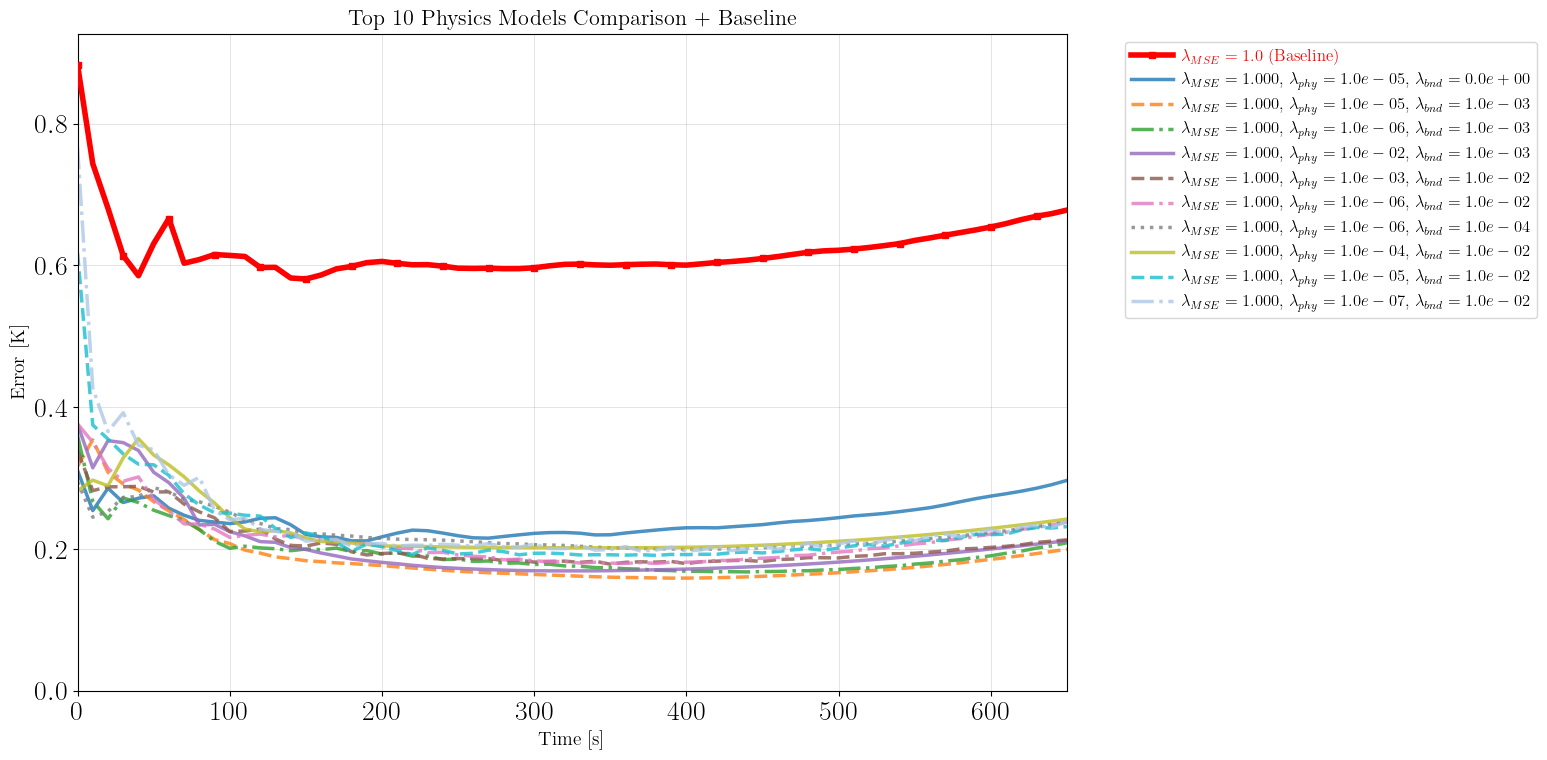


🏆 TOP 10 MODELS PLOTTED (by Overall MAE):
    1. MSE=1.0, PHY=1e-05, BND=0.001 → MAE: 0.1887 K
    2. MSE=1.0, PHY=1e-06, BND=0.001 → MAE: 0.1948 K
    3. MSE=1.0, PHY=0.01, BND=0.001 → MAE: 0.2032 K
    4. MSE=1.0, PHY=0.001, BND=0.01 → MAE: 0.2066 K
    5. MSE=1.0, PHY=1e-06, BND=0.01 → MAE: 0.2130 K
    6. MSE=1.0, PHY=1e-06, BND=0.0001 → MAE: 0.2220 K
    7. MSE=1.0, PHY=0.0001, BND=0.01 → MAE: 0.2264 K
    8. MSE=1.0, PHY=1e-05, BND=0.01 → MAE: 0.2267 K
    9. MSE=1.0, PHY=1e-07, BND=0.01 → MAE: 0.2365 K
   10. MSE=1.0, PHY=1e-05, BND=0.0 → MAE: 0.2419 K


In [ ]:
# Ahora ejecuta tu función
if comparison_results_phy:
    plot_physics_models_comparison_with_std_bands(
        comparison_results_phy, 
        save_as_pdf=True, 
        filename=f'comparison_physics_time{time_sim}_dt{dt}_nt{n_train}',
    )

In [ ]:
print_physics_models_ranking(comparison_results_phy)


🏆 PHYSICS MODELS RANKING (Ordered by Overall MAE - Best to Worst)
Rank Model Configuration                 Overall MAE  Overall RMSE  Final MAE    Max Error    Improvement 
------------------------------------------------------------------------------------------------------------------------
1    MSE=1.0, PHY=1e-05, BND=0.001       0.1887       0.2517        0.1996       0.3540       +69.7%      
2    MSE=1.0, PHY=1e-06, BND=0.001       0.1948       0.2593        0.2088       0.3598       +68.7%      
3    MSE=1.0, PHY=0.01, BND=0.001        0.2032       0.2793        0.2117       0.3760       +67.3%      
4    MSE=1.0, PHY=0.001, BND=0.01        0.2066       0.2796        0.2129       0.3388       +66.8%      
5    MSE=1.0, PHY=1e-06, BND=0.01        0.2130       0.2874        0.2380       0.3766       +65.7%      
6    MSE=1.0, PHY=1e-06, BND=0.0001      0.2220       0.2941        0.2381       0.2949       +64.3%      
7    MSE=1.0, PHY=0.0001, BND=0.01       0.2264       0.2982   

In [ ]:
# Función detallada con rankings separados
print_physics_models_ranking_detailed(comparison_results_phy)


🏆 PHYSICS MODELS DETAILED RANKING ANALYSIS
📋 RANKING METRICS EXPLANATION:
   MAE    = Position in Overall MAE ranking
   RMSE   = Position in Overall RMSE ranking
   Final  = Position in Final MAE ranking
   Max    = Position in Maximum Error ranking
   Position Format = MAE-RMSE-Final-Max (e.g., 1-2-1-3)

🌟 OUTSTANDING MODELS:
--------------------------------------------------------------------------------
🎯 Most Consistent: MSE=1.0, PHY=1e-05, BND=0.001
   Position: 1-1-1-5 | Sum of positions: 8

🏆 METRIC CHAMPIONS:
   • MSE=1.0, PHY=1e-05, BND=0.001
     Position: 1-1-1-5 | Champion in: MAE, RMSE, Final
   • MSE=1.0, PHY=1e-06, BND=0.0001
     Position: 6-6-7-1 | Champion in: Max

🥇 TOP 3 BY METRIC:

📊 Overall MAE:
   🥇 MSE=1.0, PHY=1e-05, BND=0.001
       Value: 0.1887 | Position: 1-1-1-5
   🥈 MSE=1.0, PHY=1e-06, BND=0.001
       Value: 0.1948 | Position: 2-2-2-7
   🥉 MSE=1.0, PHY=0.01, BND=0.001
       Value: 0.2032 | Position: 3-3-3-9

📊 Overall RMSE:
   🥇 MSE=1.0, PHY=1e-05, BN

### n_train = 50

In [ ]:
n_train = 50

In [ ]:
# mse_weights = [1.0, 0.0]
# phy_weights = [0.0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e2, 1e3]
# bnd_weights = [0.0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e2, 1e3]

In [ ]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results_phy = {}
total_combinations = len(mse_weights) * len(phy_weights) * len(bnd_weights)
case_counter = 0

# Iterar sobre combinaciones de pesos de física
for mse_w in mse_weights:
    for phy_w in phy_weights:
        for bnd_w in bnd_weights:
            case_counter += 1
            print(f"\n🔄 [{case_counter}/{total_combinations}] Procesando MSE={mse_w}, PHY={phy_w}, BND={bnd_w}")
            
            # Construir nombre del archivo del modelo
            filename = (f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_"
                       f"h{layer_string}_k{kernel_string}_mse{mse_w}_phy{phy_w}_bnd{bnd_w}.pth")
            model_path = os.path.join(model_dir, filename)
            
            # Verificar si el modelo existe
            if not os.path.exists(model_path):
                print(f"⚠️ [{case_counter}/{total_combinations}] Modelo no encontrado: {filename}")
                continue
            
            try:
                # Cargar modelo
                model.load_state_dict(torch.load(model_path, map_location=device))
                model.eval()
                
                # Llamar función de evaluación
                results_name = f'MSE={mse_w}, PHY={phy_w}, BND={bnd_w}'
                results = calculate_convlstm_error_by_timestep(
                    model=model,
                    dataset=dataset_phy,
                    T_transient_all=T_true_all,
                    Q_cases=Q_random,
                    T_interfaces_cases=T_interfaces_random,
                    T_env_cases=T_env_random,
                    dt=dt,
                    device=device,
                    sequence_length=sequence_length,
                    display=False
                )
                
                comparison_results_phy[results_name] = results
                print(f"✅ Evaluado: {results_name}")
                
            except Exception as e:
                print(f"❌ Error evaluando {filename}: {e}")
                continue

print(f"\n🎉 Evaluación completada para {len(comparison_results_phy)}/{total_combinations} modelos con física")


🔄 [1/242] Procesando MSE=1.0, PHY=0.0, BND=0.0


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_6200\4293954076.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loca

✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.0

🔄 [2/242] Procesando MSE=1.0, PHY=0.0, BND=1e-07
⚠️ [2/242] Modelo no encontrado: PCB_ConvLSTM_6ch_nt50_650s_dt10_bs64_h64-64_k3x3_mse1.0_phy0.0_bnd1e-07.pth

🔄 [3/242] Procesando MSE=1.0, PHY=0.0, BND=1e-06
⚠️ [3/242] Modelo no encontrado: PCB_ConvLSTM_6ch_nt50_650s_dt10_bs64_h64-64_k3x3_mse1.0_phy0.0_bnd1e-06.pth

🔄 [4/242] Procesando MSE=1.0, PHY=0.0, BND=1e-05
✅ Evaluado: MSE=1.0, PHY=0.0, BND=1e-05

🔄 [5/242] Procesando MSE=1.0, PHY=0.0, BND=0.0001
✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.0001

🔄 [6/242] Procesando MSE=1.0, PHY=0.0, BND=0.001
✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.001

🔄 [7/242] Procesando MSE=1.0, PHY=0.0, BND=0.01
✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.01

🔄 [8/242] Procesando MSE=1.0, PHY=0.0, BND=0.1
✅ Evaluado: MSE=1.0, PHY=0.0, BND=0.1

🔄 [9/242] Procesando MSE=1.0, PHY=0.0, BND=1.0
✅ Evaluado: MSE=1.0, PHY=0.0, BND=1.0

🔄 [10/242] Procesando MSE=1.0, PHY=0.0, BND=100.0
✅ Evaluado: MSE=1.0, PHY=0.0, BND=100.0

🔄 [11/242] Procesand

📊 PLOTTING SELECTION:
   Total available models: 162
   Models to plot: 11 (Top 10 + Baseline)
   Baseline included: Yes


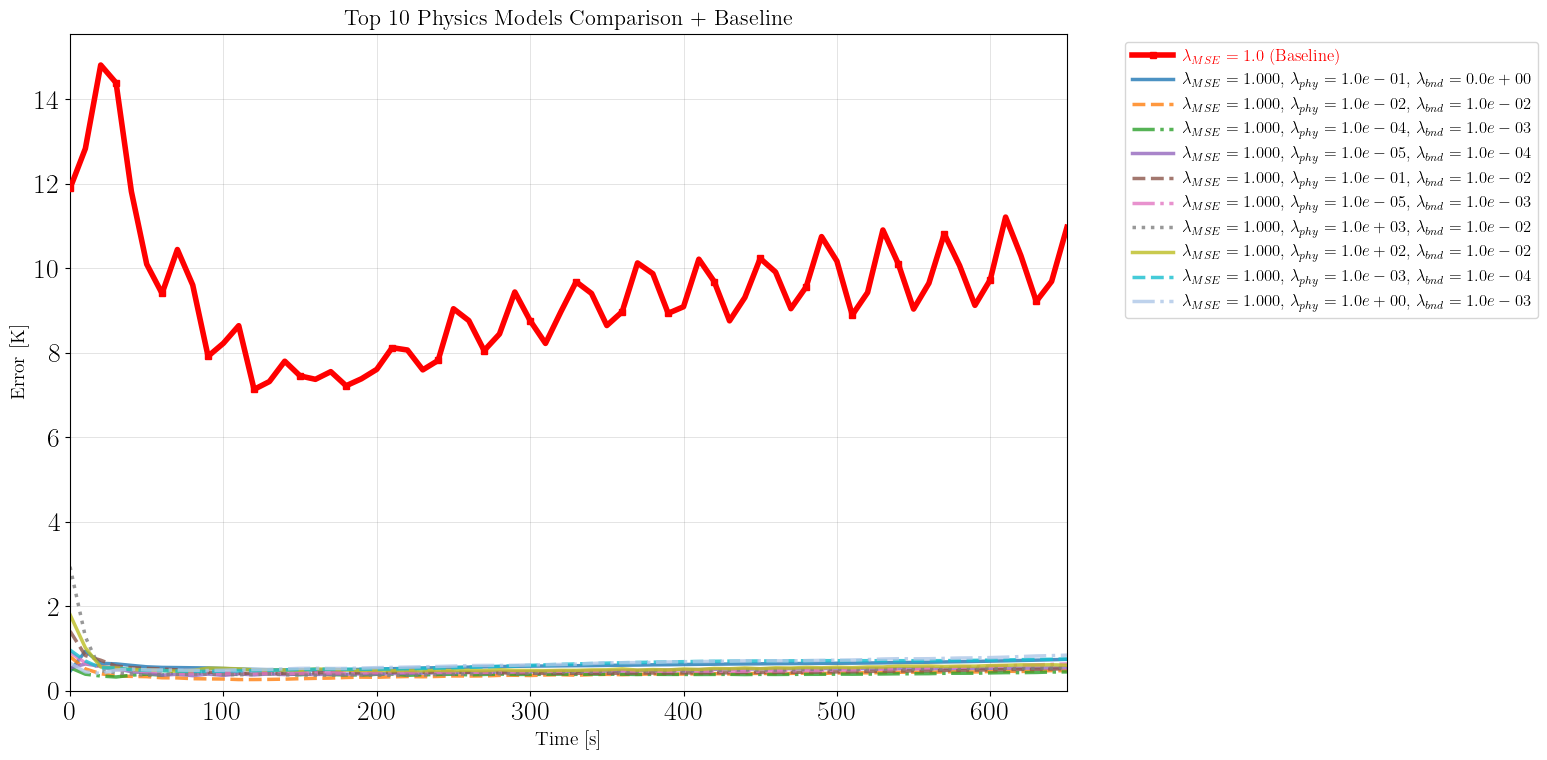


🏆 TOP 10 MODELS PLOTTED (by Overall MAE):
    1. MSE=1.0, PHY=0.01, BND=0.01 → MAE: 0.3826 K
    2. MSE=1.0, PHY=0.0001, BND=0.001 → MAE: 0.3966 K
    3. MSE=1.0, PHY=1e-05, BND=0.0001 → MAE: 0.4711 K
    4. MSE=1.0, PHY=0.1, BND=0.01 → MAE: 0.4736 K
    5. MSE=1.0, PHY=1e-05, BND=0.001 → MAE: 0.4846 K
    6. MSE=1.0, PHY=1000.0, BND=0.01 → MAE: 0.4955 K
    7. MSE=1.0, PHY=100.0, BND=0.01 → MAE: 0.5493 K
    8. MSE=1.0, PHY=0.1, BND=0.0 → MAE: 0.6044 K
    9. MSE=1.0, PHY=0.001, BND=0.0001 → MAE: 0.6214 K
   10. MSE=1.0, PHY=1.0, BND=0.001 → MAE: 0.6335 K


In [ ]:
# Usar la función adaptada
if comparison_results_phy:
    plot_physics_models_comparison_with_std_bands(
        comparison_results_phy, 
        save_as_pdf=True, 
        filename=f'comparison_physics_time{time_sim}_dt{dt}_nt{n_train}',
    )

In [ ]:
print_physics_models_ranking(comparison_results_phy)


🏆 PHYSICS MODELS RANKING (Ordered by Overall MAE - Best to Worst)
Rank Model Configuration                 Overall MAE  Overall RMSE  Final MAE    Max Error    Improvement 
------------------------------------------------------------------------------------------------------------------------
1    MSE=1.0, PHY=0.01, BND=0.01         0.3826       0.6185        0.4724       0.8073       +95.9%      
2    MSE=1.0, PHY=0.0001, BND=0.001      0.3966       0.5583        0.4453       0.5466       +95.8%      
3    MSE=1.0, PHY=1e-05, BND=0.0001      0.4711       0.6737        0.5431       0.6339       +95.0%      
4    MSE=1.0, PHY=0.1, BND=0.01          0.4736       0.6366        0.5209       1.4101       +95.0%      
5    MSE=1.0, PHY=1e-05, BND=0.001       0.4846       0.6492        0.6355       0.9080       +94.8%      
6    MSE=1.0, PHY=1000.0, BND=0.01       0.4955       0.6891        0.5476       2.9343       +94.7%      
7    MSE=1.0, PHY=100.0, BND=0.01        0.5493       0.7731   

In [ ]:
# Función detallada con rankings separados
print_physics_models_ranking_detailed(comparison_results_phy)


🏆 PHYSICS MODELS DETAILED RANKING ANALYSIS
📋 RANKING METRICS EXPLANATION:
   MAE    = Position in Overall MAE ranking
   RMSE   = Position in Overall RMSE ranking
   Final  = Position in Final MAE ranking
   Max    = Position in Maximum Error ranking
   Position Format = MAE-RMSE-Final-Max (e.g., 1-2-1-3)

🌟 OUTSTANDING MODELS:
--------------------------------------------------------------------------------
🎯 Most Consistent: MSE=1.0, PHY=0.0001, BND=0.001
   Position: 2-1-1-1 | Sum of positions: 5

🏆 METRIC CHAMPIONS:
   • MSE=1.0, PHY=0.0001, BND=0.001
     Position: 2-1-1-1 | Champion in: RMSE, Final, Max
   • MSE=1.0, PHY=0.01, BND=0.01
     Position: 1-2-2-3 | Champion in: MAE

🥇 TOP 3 BY METRIC:

📊 Overall MAE:
   🥇 MSE=1.0, PHY=0.01, BND=0.01
       Value: 0.3826 | Position: 1-2-2-3
   🥈 MSE=1.0, PHY=0.0001, BND=0.001
       Value: 0.3966 | Position: 2-1-1-1
   🥉 MSE=1.0, PHY=1e-05, BND=0.0001
       Value: 0.4711 | Position: 3-5-4-2

📊 Overall RMSE:
   🥇 MSE=1.0, PHY=0.0001, B

### n_train = 10

In [65]:
n_train = 10

In [66]:
mse_weights = [1.0]
phy_weights = [1e-4]
bnd_weights = [0.0]

In [67]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)

comparison_results_phy = {}
total_combinations = len(mse_weights) * len(phy_weights) * len(bnd_weights)
case_counter = 0

# Iterar sobre combinaciones de pesos de física
for mse_w in mse_weights:
    for phy_w in phy_weights:
        for bnd_w in bnd_weights:
            case_counter += 1
            print(f"\n🔄 [{case_counter}/{total_combinations}] Procesando MSE={mse_w}, PHY={phy_w}, BND={bnd_w}")
            
            # Construir nombre del archivo del modelo
            filename = (f"PCB_ConvLSTM_6ch_nt{n_train}_{time_sim}s_dt{dt}_bs{batch_size}_"
                       f"h{layer_string}_k{kernel_string}_mse{mse_w}_phy{phy_w}_bnd{bnd_w}.pth")
            model_path = os.path.join(model_dir, filename)
            
            # Verificar si el modelo existe
            if not os.path.exists(model_path):
                print(f"⚠️ [{case_counter}/{total_combinations}] Modelo no encontrado: {filename}")
                continue
            
            try:
                # Cargar modelo
                model.load_state_dict(torch.load(model_path, map_location=device))
                model.eval()
                
                # Llamar función de evaluación
                results_name = f'MSE={mse_w}, PHY={phy_w}, BND={bnd_w}'
                results = calculate_convlstm_error_by_timestep(
                    model=model,
                    dataset=dataset_phy,
                    T_transient_all=T_true_all,
                    Q_cases=Q_random,
                    T_interfaces_cases=T_interfaces_random,
                    T_env_cases=T_env_random,
                    dt=dt,
                    device=device,
                    sequence_length=sequence_length,
                    display=False
                )
                
                comparison_results_phy[results_name] = results
                print(f"✅ Evaluado: {results_name}")
                
            except Exception as e:
                print(f"❌ Error evaluando {filename}: {e}")
                continue

print(f"\n🎉 Evaluación completada para {len(comparison_results_phy)}/{total_combinations} modelos con física")


🔄 [1/1] Procesando MSE=1.0, PHY=0.0001, BND=0.0


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_2852\4293954076.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loca

✅ Evaluado: MSE=1.0, PHY=0.0001, BND=0.0

🎉 Evaluación completada para 1/1 modelos con física


📊 PLOTTING SELECTION:
   Total available models: 1
   Models to plot: 1 (Top 10 + Baseline)
   Baseline included: No


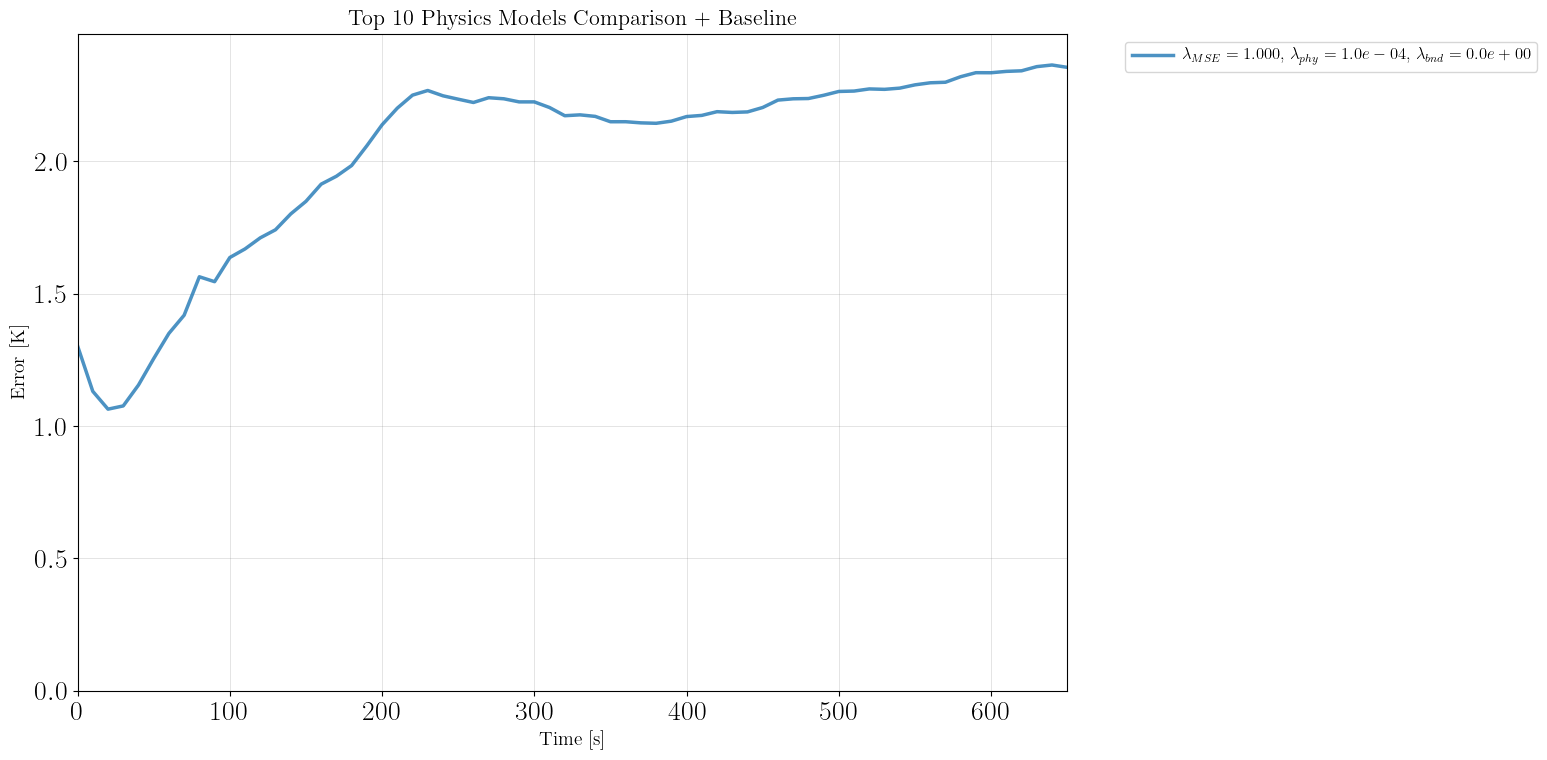


🏆 TOP 10 MODELS PLOTTED (by Overall MAE):
    1. MSE=1.0, PHY=0.0001, BND=0.0 → MAE: 2.0320 K


In [68]:
# Usar la función adaptada
if comparison_results_phy:
    plot_physics_models_comparison_with_std_bands(
        comparison_results_phy, 
        save_as_pdf=True, 
        filename=f'comparison_physics_time{time_sim}_dt{dt}_nt{n_train}',
    )

In [69]:
print_physics_models_ranking(comparison_results_phy)


🏆 PHYSICS MODELS RANKING (Ordered by Overall MAE - Best to Worst)
Rank Model Configuration                 Overall MAE  Overall RMSE  Final MAE    Max Error    Improvement 
------------------------------------------------------------------------------------------------------------------------
1    MSE=1.0, PHY=0.0001, BND=0.0        2.0320       2.6966        2.3542       19.0086      N/A         

📊 SUMMARY:
🥇 Best Overall MAE:  MSE=1.0, PHY=0.0001, BND=0.0 → 2.0320 K
🎯 Best Final MAE:    MSE=1.0, PHY=0.0001, BND=0.0 → 2.3542 K
� Best Max Error:    MSE=1.0, PHY=0.0001, BND=0.0 → 2.3631 K
�🔴 Worst Overall MAE: MSE=1.0, PHY=0.0001, BND=0.0 → 2.0320 K

📈 Statistics across all 1 models:
   Mean MAE:     2.0320 K
   Std MAE:      0.0000 K
   MAE Range:    2.0320 - 2.0320 K
   Mean Max Err: 2.3631 K
   Max Err Range:2.3631 - 2.3631 K
